## Description of this notebook
- This notebook assumes access to my WandB API key and Dashiell's AWS bucket.
- This is a 5-state (10 total), 3-layer, 4-heads-per-layer HookedTransformer transformer with layernorm and MLPs.
- WandB run this pertains to (private): https://wandb.ai/wu-cindyx/devinterp-automata/runs/89pbzt28?nw=nwuserwucindyx.

This contains:
- Logit fourier transforms for suspected closest checkpoints to forms (i.e. vertices)
- Logit fourier transforms for forms (made with 3 PCA components)
    - Both of the above have bases as the conjugacy class irreducible representations of the dihedral group
- Hand-crafted label evaluation comparisons (predicted and actual) for sequences of all 0s, all 1s, all 0s with a 1 injected at a single position, and the inverse of the latter (all 1s with a 0 injected at a single position)
    - These are done for all forms and also at end of the training process: we have 4 forms and a final model. model_0 is a comparison for very early on in training.- 

In [1]:
try:
    import google.colab # type: ignore
    IN_COLAB = True
except:
    IN_COLAB = False

import os, sys

if IN_COLAB:
    # Code to download the necessary files (e.g. solutions, test funcs)
    if not os.path.exists("chapter1_transformers"):
        !curl -o /content/main.zip https://codeload.github.com/callummcdougall/ARENA_2.0/zip/refs/heads/main
        !unzip /content/main.zip 'ARENA_2.0-main/chapter1_transformers/exercises/*'
        sys.path.append("/content/ARENA_2.0-main/chapter1_transformers/exercises")
        os.remove("/content/main.zip")
        os.rename("ARENA_2.0-main/chapter1_transformers", "chapter1_transformers")
        os.rmdir("ARENA_2.0-main")

         # Install packages
        %pip install einops
        %pip install jaxtyping
        %pip install transformer_lens
        %pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
        %pip install s3fs
        %pip install omegaconf
        %pip install git+https://github.com/CindyXWu/devinterp-automata.git
        %pip install torch-ema

        !curl -o /content/main.zip https://codeload.github.com/CindyXWu/devinterp-automata/zip/refs/heads/main
        !unzip -o /content/main.zip -d /content/

        sys.path.append("/content/devinterp-automata/")
        os.remove("/content/main.zip")

        os.chdir("chapter1_transformers/exercises")
else:
    from IPython import get_ipython
    ipython = get_ipython()
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

    CHAPTER = r"chapter1_transformers"
    CHAPTER_DIR = r"./" if CHAPTER in os.listdir() else os.getcwd().split(CHAPTER)[0]
    EXERCISES_DIR = CHAPTER_DIR + f"{CHAPTER}/exercises"
    sys.path.append(EXERCISES_DIR)

In [2]:
import plotly.express as px
from typing import List, Union, Optional, Dict, Tuple
from jaxtyping import Int, Float

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
import numpy as np
import pandas as pd
import einops
import re
import functools
from tqdm import tqdm
from IPython.display import display
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
from transformer_lens.utils import to_numpy

# Plotting
import circuitsvis as cv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# For Dashiell's groups code
from copy import deepcopy
from functools import reduce
from itertools import product
import math
import numpy as np
from operator import mul
import torch

torch.set_grad_enabled(False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAIN = __name__ == "__main__"

import wandb
from pathlib import Path
import os
import yaml
import s3fs
from omegaconf import OmegaConf

from di_automata.config_setup import *
from di_automata.constructors import (
    construct_model,
    create_dataloader_hf,
)
from di_automata.tasks.data_utils import take_n
import plotly.io as pio

# AWS
#AWS_KEY, AWS_SECRET = os.getenv("AWS_KEY"), os.getenv("AWS_SECRET")
s3 = s3fs.S3FileSystem()

/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_type" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_save_method" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
from di_automata.interp_utils import (
    imshow_attention,
    line,
    scatter,
    imshow,
    reorder_list_in_plotly_way,
    get_pca,
    get_vars,
    plot_tensor_heatmap,
    get_activations,
    LN_hook_names,
    get_ln_fit,
    cos_sim_with_MLP_weights,
    avg_squared_cos_sim,
    hook_fn_display_attn_patterns,
    hook_fn_patch_qk,
)

from di_automata.tasks.dashiell_groups import (
    DihedralElement,
    DihedralIrrep, 
    ProductDihedralIrrep,
    dihedral_conjugacy_classes, 
    generate_subgroup,
    actions_to_labels,
    get_all_bits,
    dihedral_fourier,
    get_fourier_spectrum,
    analyse_power,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dihedral representations

In [4]:
group = DihedralElement.full_group(5)
translation = {
    (0,0):0,
    (1,0):1,
    (2,0):2,
    (3,0):3,
    (4,0):4,
    (0,1):5,
    (1,1):6,
    (2,1):7,
    (3,1):8,
    (4,1):9,
}

In [5]:
dihedral_conjugacy_classes(5)

[(0, 0), (0, 1), (1, 0), (2, 0)]

In [6]:
group

[(0, 0),
 (0, 1),
 (1, 0),
 (1, 1),
 (2, 0),
 (2, 1),
 (3, 0),
 (3, 1),
 (4, 0),
 (4, 1)]

In [7]:
DihedralIrrep(5, (0, 0)).dim

1

In [8]:
dihedral_fn = torch.tensor([-1, 1, -1, 1, -1, 1, -1, 1, -1, 1])

This sequence is the 'anti' of the parity irreducible representation of the dihedral group

In [9]:
(dihedral_fn * DihedralIrrep(5, (0, 1)).tensors()).sum()

tensor(0.)

In [10]:
def dihedral_fourier(fn_values, n):
    irreps = {conj: DihedralIrrep(n, conj).tensors() for conj in dihedral_conjugacy_classes(n)}
    return {conj: (fn_values * irrep).sum(dim=0) for conj, irrep in irreps.items()}

In [11]:
rep_list = [
    DihedralIrrep(5, (0, 0)).tensors(), 
    DihedralIrrep(5, (0, 1)).tensors(),
    DihedralIrrep(5, (1, 0)).tensors(),
    DihedralIrrep(5, (2, 0)).tensors(),
]
for rep in rep_list: print(rep)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]])
tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]])
tensor([[ 1.0000,  0.0000,  0.0000,  1.0000],
        [ 1.0000,  0.0000,  0.0000, -1.0000],
        [ 0.3090, -0.9511,  0.9511,  0.3090],
        [ 0.3090, -0.9511, -0.9511, -0.3090],
        [-0.8090, -0.5878,  0.5878, -0.8090],
        [-0.8090, -0.5878, -0.5878,  0.8090],
        [-0.8090,  0.5878, -0.5878, -0.8090],
        [-0.8090,  0.5878,  0.5878,  0.8090],
        [ 0.3090,  0.9511, -0.9511,  0.3090],
        [ 0.3090,  0.9511,  0.9511, -0.3090]])
tensor([[ 1.0000,  0.0000,  0.0000,  1.0000],
        [ 1.0000,  0.0000,  0.0000, -1.0000],
        [-0.8090, -0.5878,  0.5878, -0.8090],
        [-0.8090, -0.5878, -0.5878,  0.8090],
        [ 0.3090,  0.9511, -0.9511,  0.3090],
        [ 0.3090,

In [12]:
dihedral_fourier(torch.randn((10, 1)), 5)

{(0, 0): tensor([2.2288]),
 (0, 1): tensor([1.6992]),
 (1, 0): tensor([0.9713, 0.1595, 1.8496, 1.1841]),
 (2, 0): tensor([-2.6615,  2.3321,  2.2205, -1.2395])}

In [13]:
DihedralIrrep(5, (0, 1)).tensors()

tensor([[ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.],
        [ 1.],
        [-1.]])

In [14]:
def imshow_attention(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)


In [15]:
DI_ROOT = Path("/content/devinterp-automata-main/") if IN_COLAB else Path("../")
config_file_path = DI_ROOT / f"scripts/configs/slt_config.yaml"
slt_config = OmegaConf.load(config_file_path)

with open(DI_ROOT / f"scripts/configs/task_config/{slt_config.dataset_type}.yaml", 'r') as file:
    task_config = yaml.safe_load(file)

In [16]:
OmegaConf.set_struct(slt_config, False) # Allow new configuration values to be added
# Because we are in Colab and not VSCode, here is where you want to edit your config values
slt_config["task_config"] = task_config
slt_config["lr"] = 0.0005
slt_config["num_training_iter"] = 100000
slt_config["n_layers"] = 3

# Convert OmegaConf object to MainConfig Pydantic model for dynamic type validation - NECESSARY DO NOT SKIP
pydantic_config = PostRunSLTConfig(**slt_config)
# Convert back to OmegaConf object for compatibility with existing code
slt_config = OmegaConf.create(pydantic_config.model_dump())

print(task_config["dataset_type"])

dihedral


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Run path and name for easy referral later
run_path = f"{slt_config.entity_name}/{slt_config.wandb_project_name}"
run_name = slt_config.run_name
print(run_name)

dihedral_TF_LENS_LR0.0005_its100000_layers3_seqlen25_nstates5_prob1None_nactionsNone


In [18]:
# Get run information
api = wandb.Api(timeout=3000)
run_list = api.runs(
    path=run_path,
    filters={
        "display_name": run_name,
        "state": "finished",
        },
    order="created_at", # Default descending order so backwards in time
)
assert run_list, f"Specified run {run_name} does not exist"
run_api = run_list[slt_config.run_idx]
try: history = run_api.history()
except: history = run_api.history
loss_history = history["Train Loss"]
accuracy_history = history["Train Acc"]
steps = history["_step"]
time = run_api.config["time"]

In [19]:
def get_config() -> MainConfig:
    """"
    Manually get config from run as artifact.
    WandB also logs automatically for each run, but it doesn't log enums correctly.
    """
    artifact = api.artifact(f"{run_path}/config:{run_name}_{time}")
    data_dir = artifact.download()
    config_path = Path(data_dir) / "config.yaml"
    return OmegaConf.load(config_path)

### Make dataloaders

In [20]:
config = get_config()

# Set total number of unique samples seen (n). If this is not done it will break LLC estimator.
slt_config.rlct_config.sgld_kwargs.num_samples = slt_config.rlct_config.num_samples = config.rlct_config.sgld_kwargs.num_samples
slt_config.nano_gpt_config = config.nano_gpt_config

wandb:   1 of 1 files downloaded.  


### Restoring logits and checkpointed states

In [21]:
def restore_state_single_cp(cp_idx: int) -> dict:
    """Restore model state from a single checkpoint.
    Used in _load_logits_states() and _calculate_rlct().

    Args:
        idx_cp: index of checkpoint.

    Returns:
        model state dictionary.
    """
    idx = cp_idx * config.rlct_config.ed_config.eval_frequency * slt_config.skip_cps
    print(f"Getting checkpoint {idx}")
    print(config.model_save_method)
    match config.model_save_method:
        case "wandb":
            artifact = api.artifact(f"{run_path}/states:idx{idx}_{run_name}_{time}")
            data_dir = artifact.download()
            state_path = Path(data_dir) / f"states_{idx}.torch"
            states = torch.load(state_path)
        case "aws":
            with s3.open(f'{config.aws_bucket}/{run_name}_{time}/states_{idx}.pth', mode='rb') as file:
                states = torch.load(file, map_location=device)
    return states["model"]


def load_logits_single_cp(cp_idx: int) -> None:
    """Load just a single cp. 
    This function is designed to be called in multithreading and is called by the above function.
    """
    idx = cp_idx * config.rlct_config.ed_config.eval_frequency * slt_config.skip_cps

    try:
        match config.model_save_method:
            case "wandb":
                artifact = api.artifact(f"{run_path}/logits:logits_cp_{idx}_{run_name}_{time}")
                data_dir = artifact.download()
                logit_path = Path(data_dir) / f"logits_cp_{idx}.torch"
                return torch.load(logit_path)
            case "aws":
                with s3.open(f'{config.aws_bucket}/{run_name}_{time}/logits_cp_{idx}.pth', mode='rb') as file:
                    return torch.load(file)
                
    except Exception as e:
        print(f"Error fetching logits at step {idx}: {e}")

In [22]:
current_directory = Path().absolute()
logits_file_path = current_directory.parent / f"di_automata/logits_{run_name}_{time}"
print(logits_file_path)

/workspace/devinterp-automata/di_automata/logits_dihedral_TF_LENS_LR0.0005_its100000_layers3_seqlen25_nstates5_prob1None_nactionsNone_03_06_04_17


The `ed_loader` below has seed=42 set, so can recreate the data!

In [23]:
ed_loader = create_dataloader_hf(config, deterministic=True) # Make sure deterministic to see same data
eval_loader = create_dataloader_hf(config, batch_size=256)

### Functions to display attention

In [24]:
def display_layer_heads(att, batch_idx=0):
    """For generic inputs, display attention for particular index in batch.
    """
    display(cv.attention.attention_patterns(
        tokens=list_of_strings(inputs[batch_idx,...]),
        attention=att[batch_idx,...],
        attention_head_names=[f"L0H{i}" for i in range(4)],
    ))
    # 0 is toggle action
    # 1 is drive action
    print(inputs[batch_idx,...])
    print(labels[batch_idx,...])


def list_of_strings(tensor):
    return tensor.numpy().astype(str).tolist()


def display_layer_heads_batch(att: torch.Tensor, cache: ActivationCache, toks: list[str]):
    """TODO: refactor"""
    cv.attention.from_cache(
      cache = cache,
      tokens = toks,
      batch_idx = list(range(10)),
      attention_type = "info-weighted",
      radioitems = True,
      return_mode = "view",
      batch_labels = lambda batch_idx, str_tok_list: format_sequence(str_tok_list, dataset.str_tok_labels[batch_idx]),
      mode = "small",
    )

# Get checkpoints

In [25]:
cp_idxs = [20, 220, 520, 855, 1150, 1500]

In [26]:
# Pre-form

pre_analysis = True

if pre_analysis:
    cp_idx_0 = 20
    state_0 = restore_state_single_cp(cp_idx_0)
    model_0, _ = construct_model(config)
    model_0.load_state_dict(state_0)
    
    # Form 1
    cp_idx_1 = 220
    state_1 = restore_state_single_cp(cp_idx_1)
    model_1, _ = construct_model(config)
    model_1.load_state_dict(state_1)
    
    # Form 2
    cp_idx_2 = 520
    state_2 = restore_state_single_cp(cp_idx_2)
    model_2, _ = construct_model(config)
    model_2.load_state_dict(state_2)
    
    # Form 3
    cp_idx_3 = 855
    state_3 = restore_state_single_cp(cp_idx_3)
    model_3, _ = construct_model(config)
    model_3.load_state_dict(state_3)
    
    # Form 4
    cp_idx_4 = 1150
    state_4 = restore_state_single_cp(cp_idx_4)
    model_4, _ = construct_model(config)
    model_4.load_state_dict(state_4)

# End
cp_idx_5 = 1500
state_5 = restore_state_single_cp(cp_idx_5)
model_5, _ = construct_model(config)
model_5.load_state_dict(state_5)

Getting checkpoint 400
aws
Getting checkpoint 4400
aws
Getting checkpoint 10400
aws
Getting checkpoint 17100
aws
Getting checkpoint 23000
aws
Getting checkpoint 30000
aws


<All keys matched successfully>

In [27]:
# Pass data through
for data in take_n(ed_loader, 1):
    inputs = data["input_ids"]
    labels = data["label_ids"]
    break

#logits_0, cache_0 = model_0.run_with_cache(inputs)
#logits_1, cache_1 = model_1.run_with_cache(inputs)
#logits_2, cache_2 = model_2.run_with_cache(inputs)
#logits_3, cache_3 = model_3.run_with_cache(inputs)
#logits_4, cache_4 = model_4.run_with_cache(inputs)


logits_5, cache_5 = model_5.run_with_cache(inputs)

In [28]:
from itertools import accumulate

def actions_to_labels(tensor, dtype: str = "float32"):
    translation = {
        (0,0): 0,
        (1,0): 1,
        (2,0): 2,
        (3,0): 3,
        (4,0): 4,
        (0,1): 5,
        (1,1): 6,
        (2,1): 7,
        (3,1): 8,
        (4,1): 9,
    }
    actions = {
        0: DihedralElement(0, 1, 5),
        1: DihedralElement(1, 0, 5)
    }
    action_list = []
    for i in tensor:
        if i ==  torch.tensor(0):
            action_list.append(actions[0])
        else:
            action_list.append(actions[1])
    states = accumulate(action_list, mul)
    dtype = torch.float32 if dtype == "float" else torch.int32
    return torch.tensor([translation[s.sigma] for s in states], dtype=dtype)


def get_all_bits(m):
    """Generate every possible m-length binary sequence."""
    d = np.arange(2 ** m)
    bits = (((d[:,None] & (1 << np.arange(m)))) > 0).astype(int)
    return torch.asarray(bits)





In [29]:
all_seqs = get_all_bits(15)
all_labels = torch.stack([actions_to_labels(t, translation) for t in all_seqs], dim= 0)

In [30]:
all_labels[0]

tensor([5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5, 0, 5], dtype=torch.int32)

In [38]:


def get_activations(model, data, layers, batch_size=2**9):
    activations = {layer_idx: [] for layer_idx in layers}

    for batch in data.split(batch_size):
        _, cache_5 = model.run_with_cache(batch.to('cuda'))
        for idx in layers:
            activations[idx].append(cache_5['mlp_out', idx][:, -1, :].detach().cpu())
        
    return {k: torch.concat(v, dim=0) for k, v in activations.items()}

In [34]:
#model0_activations = get_activations(model_0)
#model1_activations = get_activations(model_1)
#model2_activations = get_activations(model_2)
#model3_activations = get_activations(model_3)
#model4_activations = get_activations(model_4)
#model5_activations = get_activations(model_5)

In [35]:
torch._dynamo.config.verbose=True

def hadamard_transform_torch(u, normalize=True):
    """Multiply H_n @ u where H_n is the Hadamard matrix of dimension n x n.
    n must be a power of 2.
    Parameters:
        u: Tensor of shape (..., n)
        normalize: if True, divide the result by 2^{m/2} where m = log_2(n).
    Returns:
        product: Tensor of shape (..., n)
    """
    batch_size, n = u.shape
    m = int(np.log2(n))
    assert n == 1 << m, 'n must be a power of 2'
    x = u[..., np.newaxis]
    for _ in range(m):
        x = torch.cat((x[..., ::2, :] + x[..., 1::2, :], x[..., ::2, :] - x[..., 1::2, :]), dim=-1)
    return x.squeeze(-2) / 2**(m / 2) if normalize else x.squeeze(-2)


hadamard = torch.compile(hadamard_transform_torch)

In [62]:
import polars as pl

def actions_to_elements(actions):
    return ['r' if act else 's' for act in actions]


def hadamard_df(tensor, labels, m):
    inputs = get_all_bits(m)
    
    degrees = inputs.sum(axis=1).numpy()
    parity = degrees % 2
    bits = inputs.tolist()
    bits_df = pl.DataFrame({'bits': bits, 'degree': degrees, 'parity': parity})

    #pl.Series('bits', upto13.detach().cpu().tolist())
    #bits_df = pl.DataFrame(inputs.sum(dim=1)detach().cpu().numpy(), schema=[f'bit{i}' for i in range(n)])
    #bits_df.insert_column(n, bits_df.sum_horizontal().alias('degree'))
    fourier = hadamard_transform_torch(tensor.T.to('cuda'), True)
    data = pl.DataFrame(tensor.detach().cpu().numpy(),  schema=[str(i) for i in range(tensor.shape[-1])])
    fourier_data = pl.DataFrame(fourier.T.detach().cpu().numpy(), schema=[str(i) for i in range(tensor.shape[-1])])
    fourier_df = pl.concat([bits_df, fourier_data], how='horizontal')
    #basic_df = pl.concat([bits_df, data], how='horizontal').with_row_index()

    idx_to_el = {
        0: 'e', #(0,0),
        1: 'r', #(1,0),
        2: 'r**2', #(2,0),
        3: 'r**3', #(3,0),
        4: 'r**4', #(4,0),
        5: 's', #(0,1),
        6: 'sr', #(1,1),
        7: 'sr**2', #(2,1),
        8: 'sr**3', #(3,1),
        9: 'sr**4', #(4,1)
    }
    actions = [actions_to_elements(seq) for seq in bits]
    label_df = (
        pl.DataFrame({'label': labels.cpu().numpy(), 'actions': actions})
        .with_columns([
            pl.col('label').replace(idx_to_el)
        ])
    )
    return pl.concat([label_df, fourier_df], how='horizontal').with_row_index()


def calculate_hadamard_power_df(fourier_df):
    power = (
        fourier_df
        .filter(pl.col('degree') != 0)
        .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity', 'mlp_layer']))
        .melt(variable_name='column').group_by('column')
        .agg(pl.col('value').pow(2).sum().alias('total_power'))
    )
    
    data = (
        fourier_df
        .filter(pl.col('degree') != 0)    
        .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity', 'mlp_layer']))
        #.select(['degree'] + randcols)
        #.filter(pl.col('degree') != 0)
        .melt(id_vars='degree', variable_name='column')
        .group_by(['degree', 'column'])
        .agg(
            [
                pl.col('value').pow(2).sum().alias('power')
            ]
        )
        .join(power, on='column')
        .with_columns((pl.col('power') / pl.col('total_power')).alias('pcnt_power'))
    )
    return data





def get_checkpoint_parity_power_spectrum(model, sequence_length: int, mlp_layers: list[int]) -> pl.DataFrame:
    all_seqs = get_all_bits(sequence_length)
    all_labels = torch.stack([actions_to_labels(t) for t in all_seqs], dim= 0)
    activations = get_activations(model, all_seqs, mlp_layers)
    spectrum_data = []
    fourier_data = []
    for layer_idx, tensor in activations.items():
        fourier_df = hadamard_df(tensor, all_labels[:, -1], sequence_length)
        fourier_df = fourier_df.with_columns(pl.lit(layer_idx).alias('mlp_layer'))
        fourier_data.append(fourier_df)
        power_df = calculate_hadamard_power_df(fourier_df).with_columns(pl.lit(layer_idx).alias('mlp_layer'))
        spectrum_data.append(power_df)
    return pl.concat(spectrum_data), pl.concat(fourier_data)
        

In [63]:
spectrum0_df, fourier0_df = get_checkpoint_parity_power_spectrum(model_0, 15, [0, 1, 2])
spectrum1_df, fourier1_df = get_checkpoint_parity_power_spectrum(model_1, 15, [0, 1, 2])
spectrum2_df, fourier2_df = get_checkpoint_parity_power_spectrum(model_2, 15, [0, 1, 2])
spectrum3_df, fourier3_df = get_checkpoint_parity_power_spectrum(model_3, 15, [0, 1, 2])
spectrum4_df, fourier4_df = get_checkpoint_parity_power_spectrum(model_4, 15, [0, 1, 2])
spectrum5_df, fourier5_df = get_checkpoint_parity_power_spectrum(model_5, 15, [0, 1, 2])


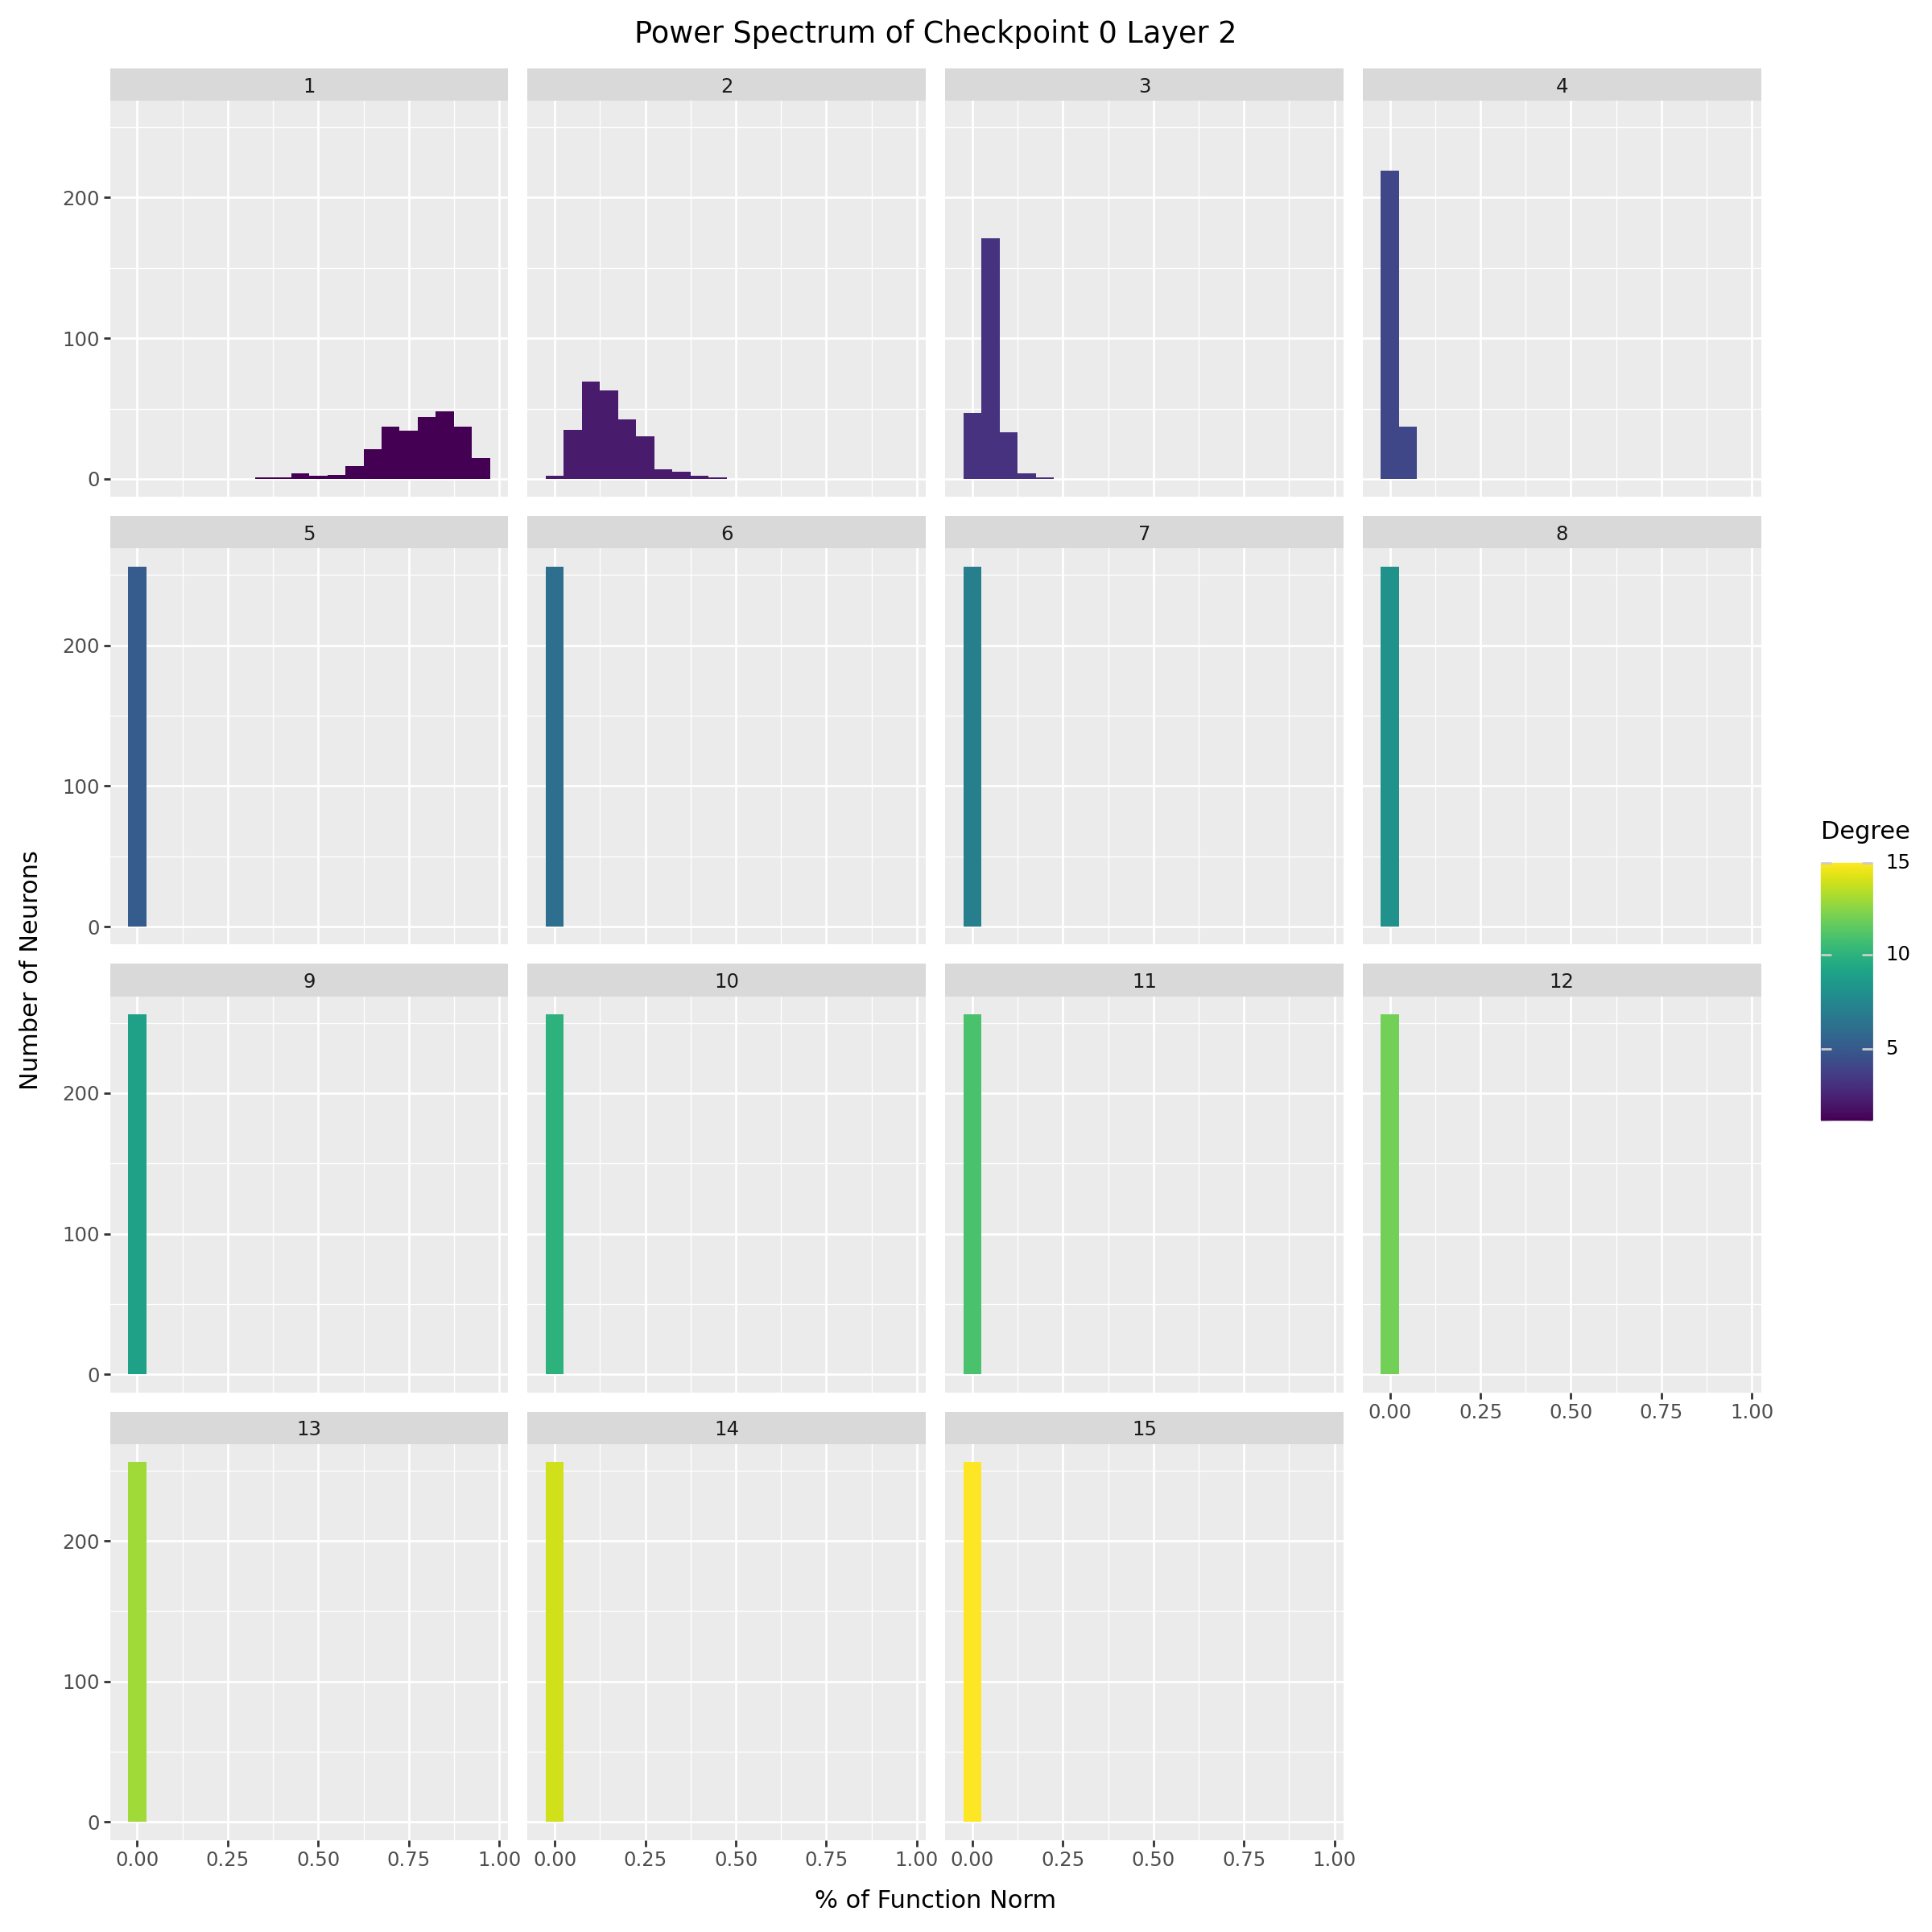

In [53]:
from plotnine import labs, ggplot, aes, geom_histogram, theme, facet_wrap

(
    ggplot(spectrum0_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 0 Layer 2')
)

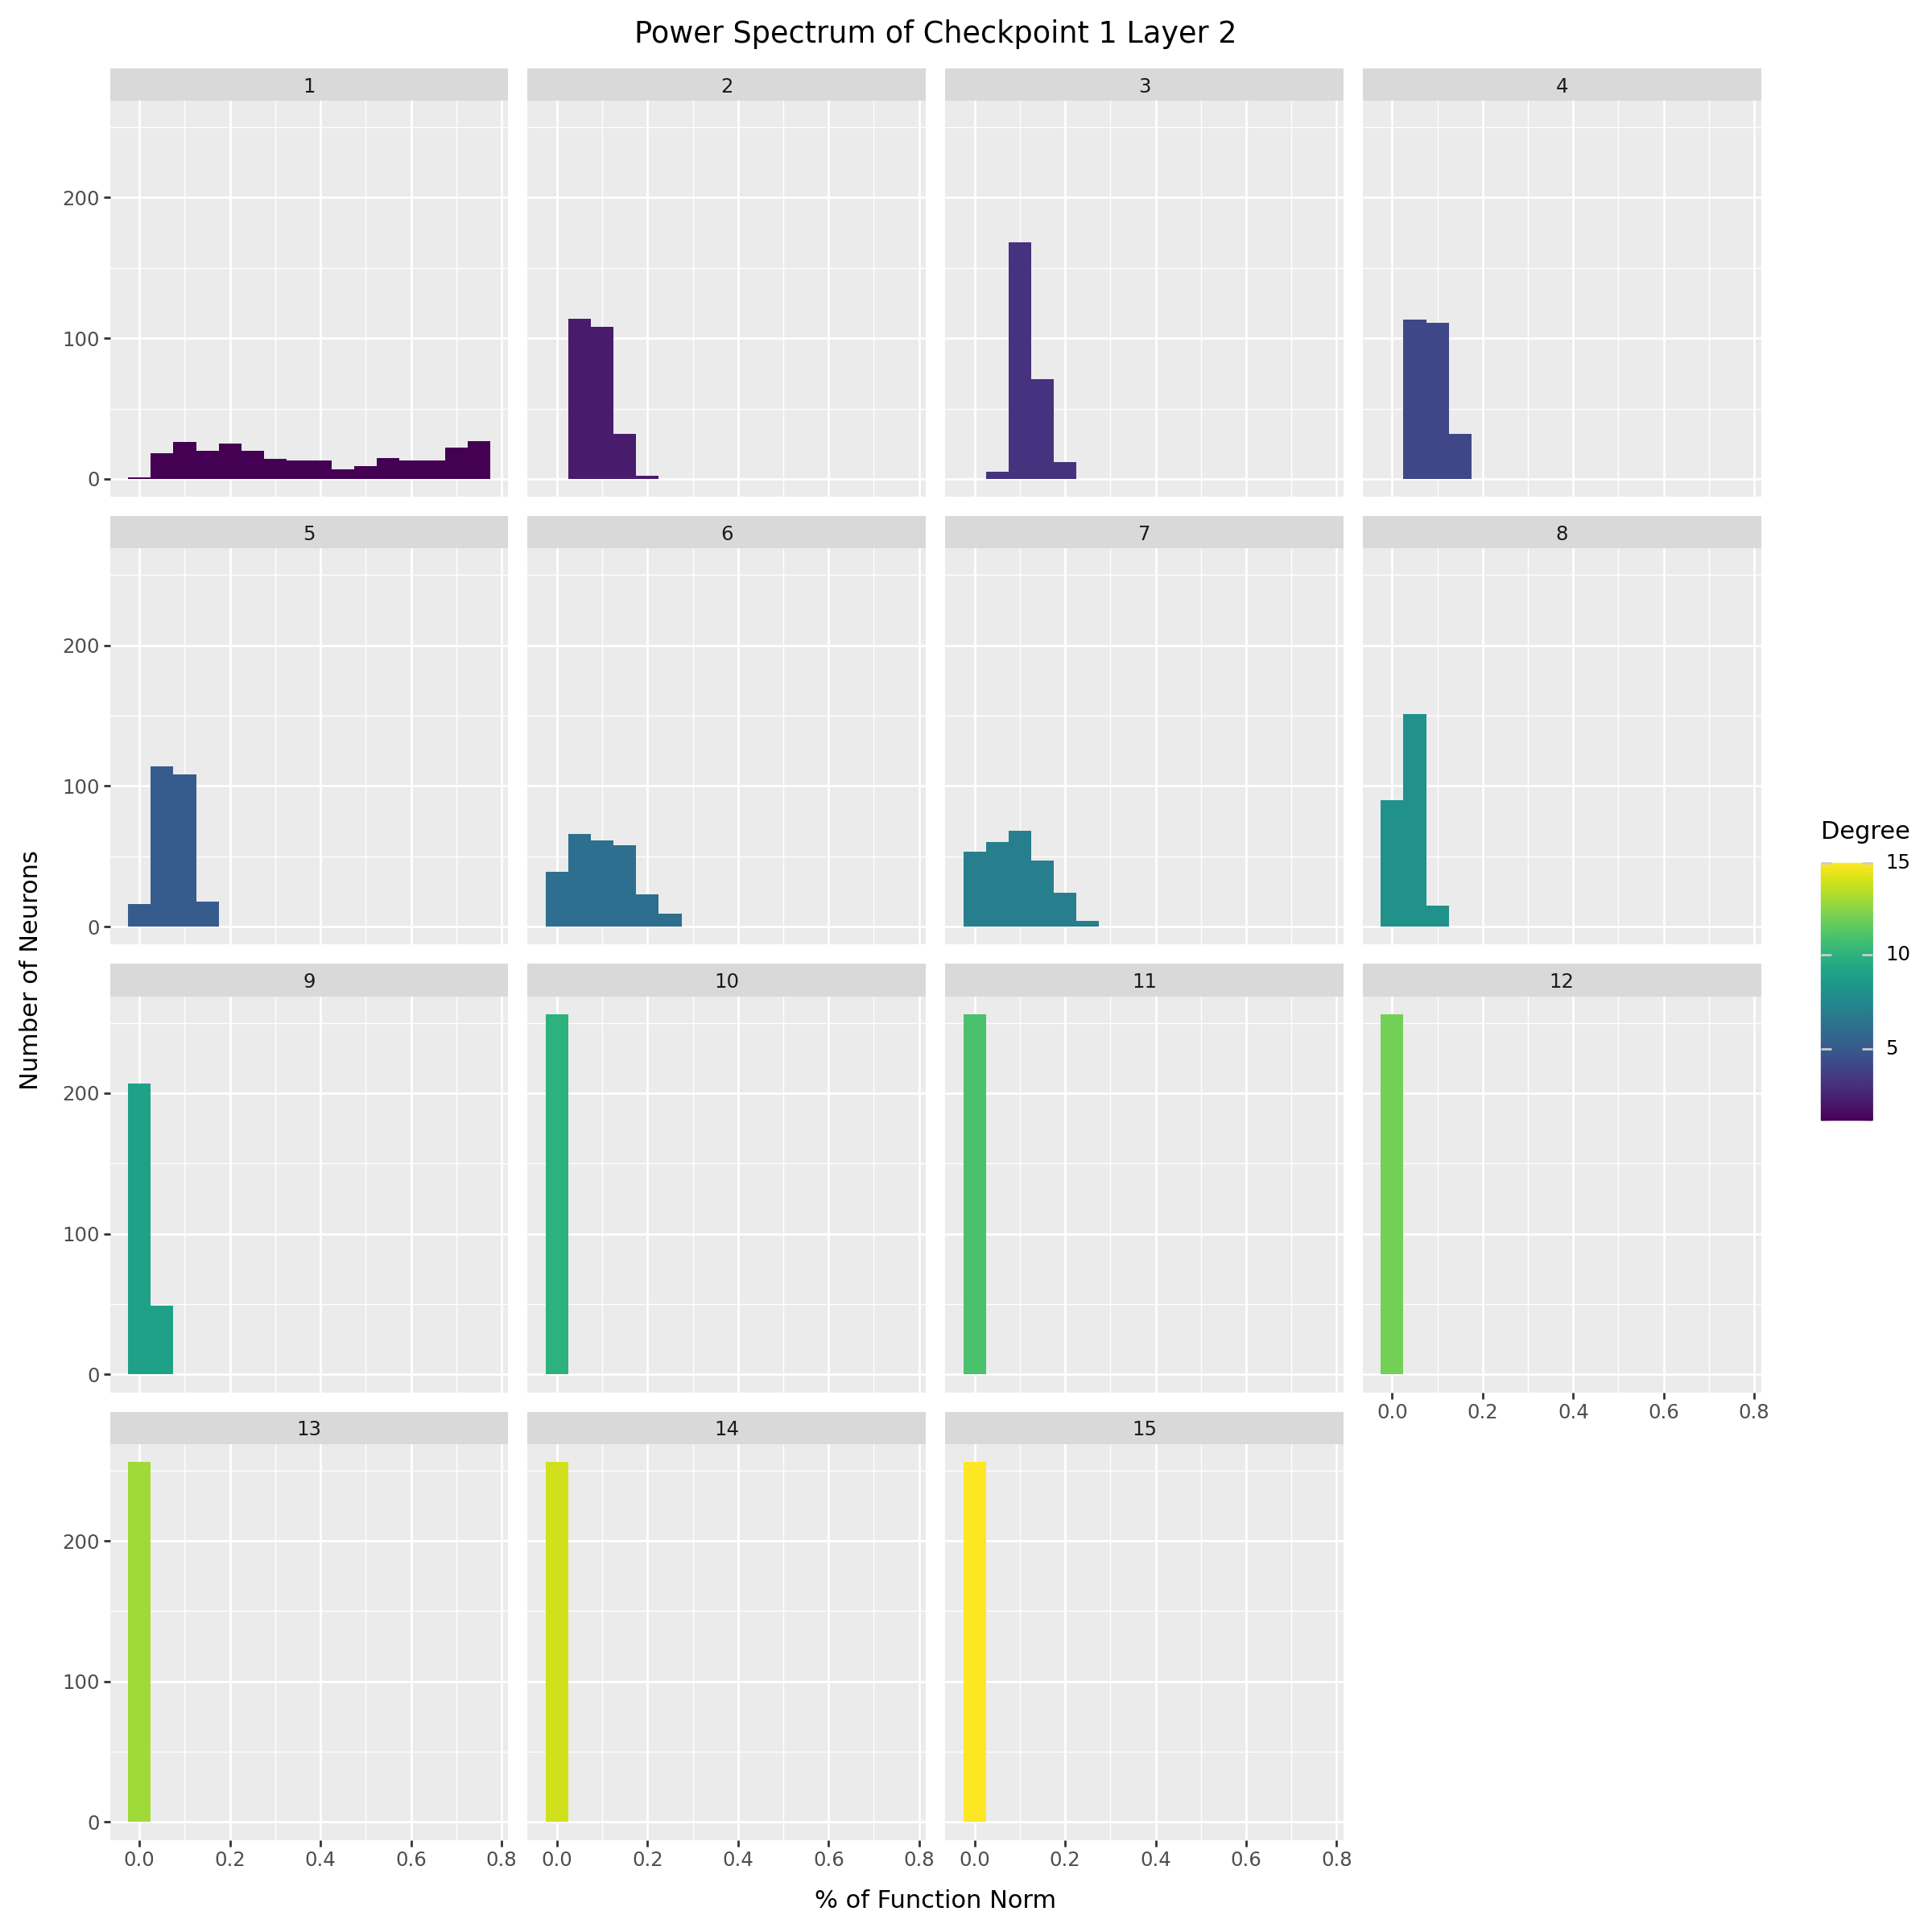

In [54]:
(
    ggplot(spectrum1_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 1 Layer 2')
)

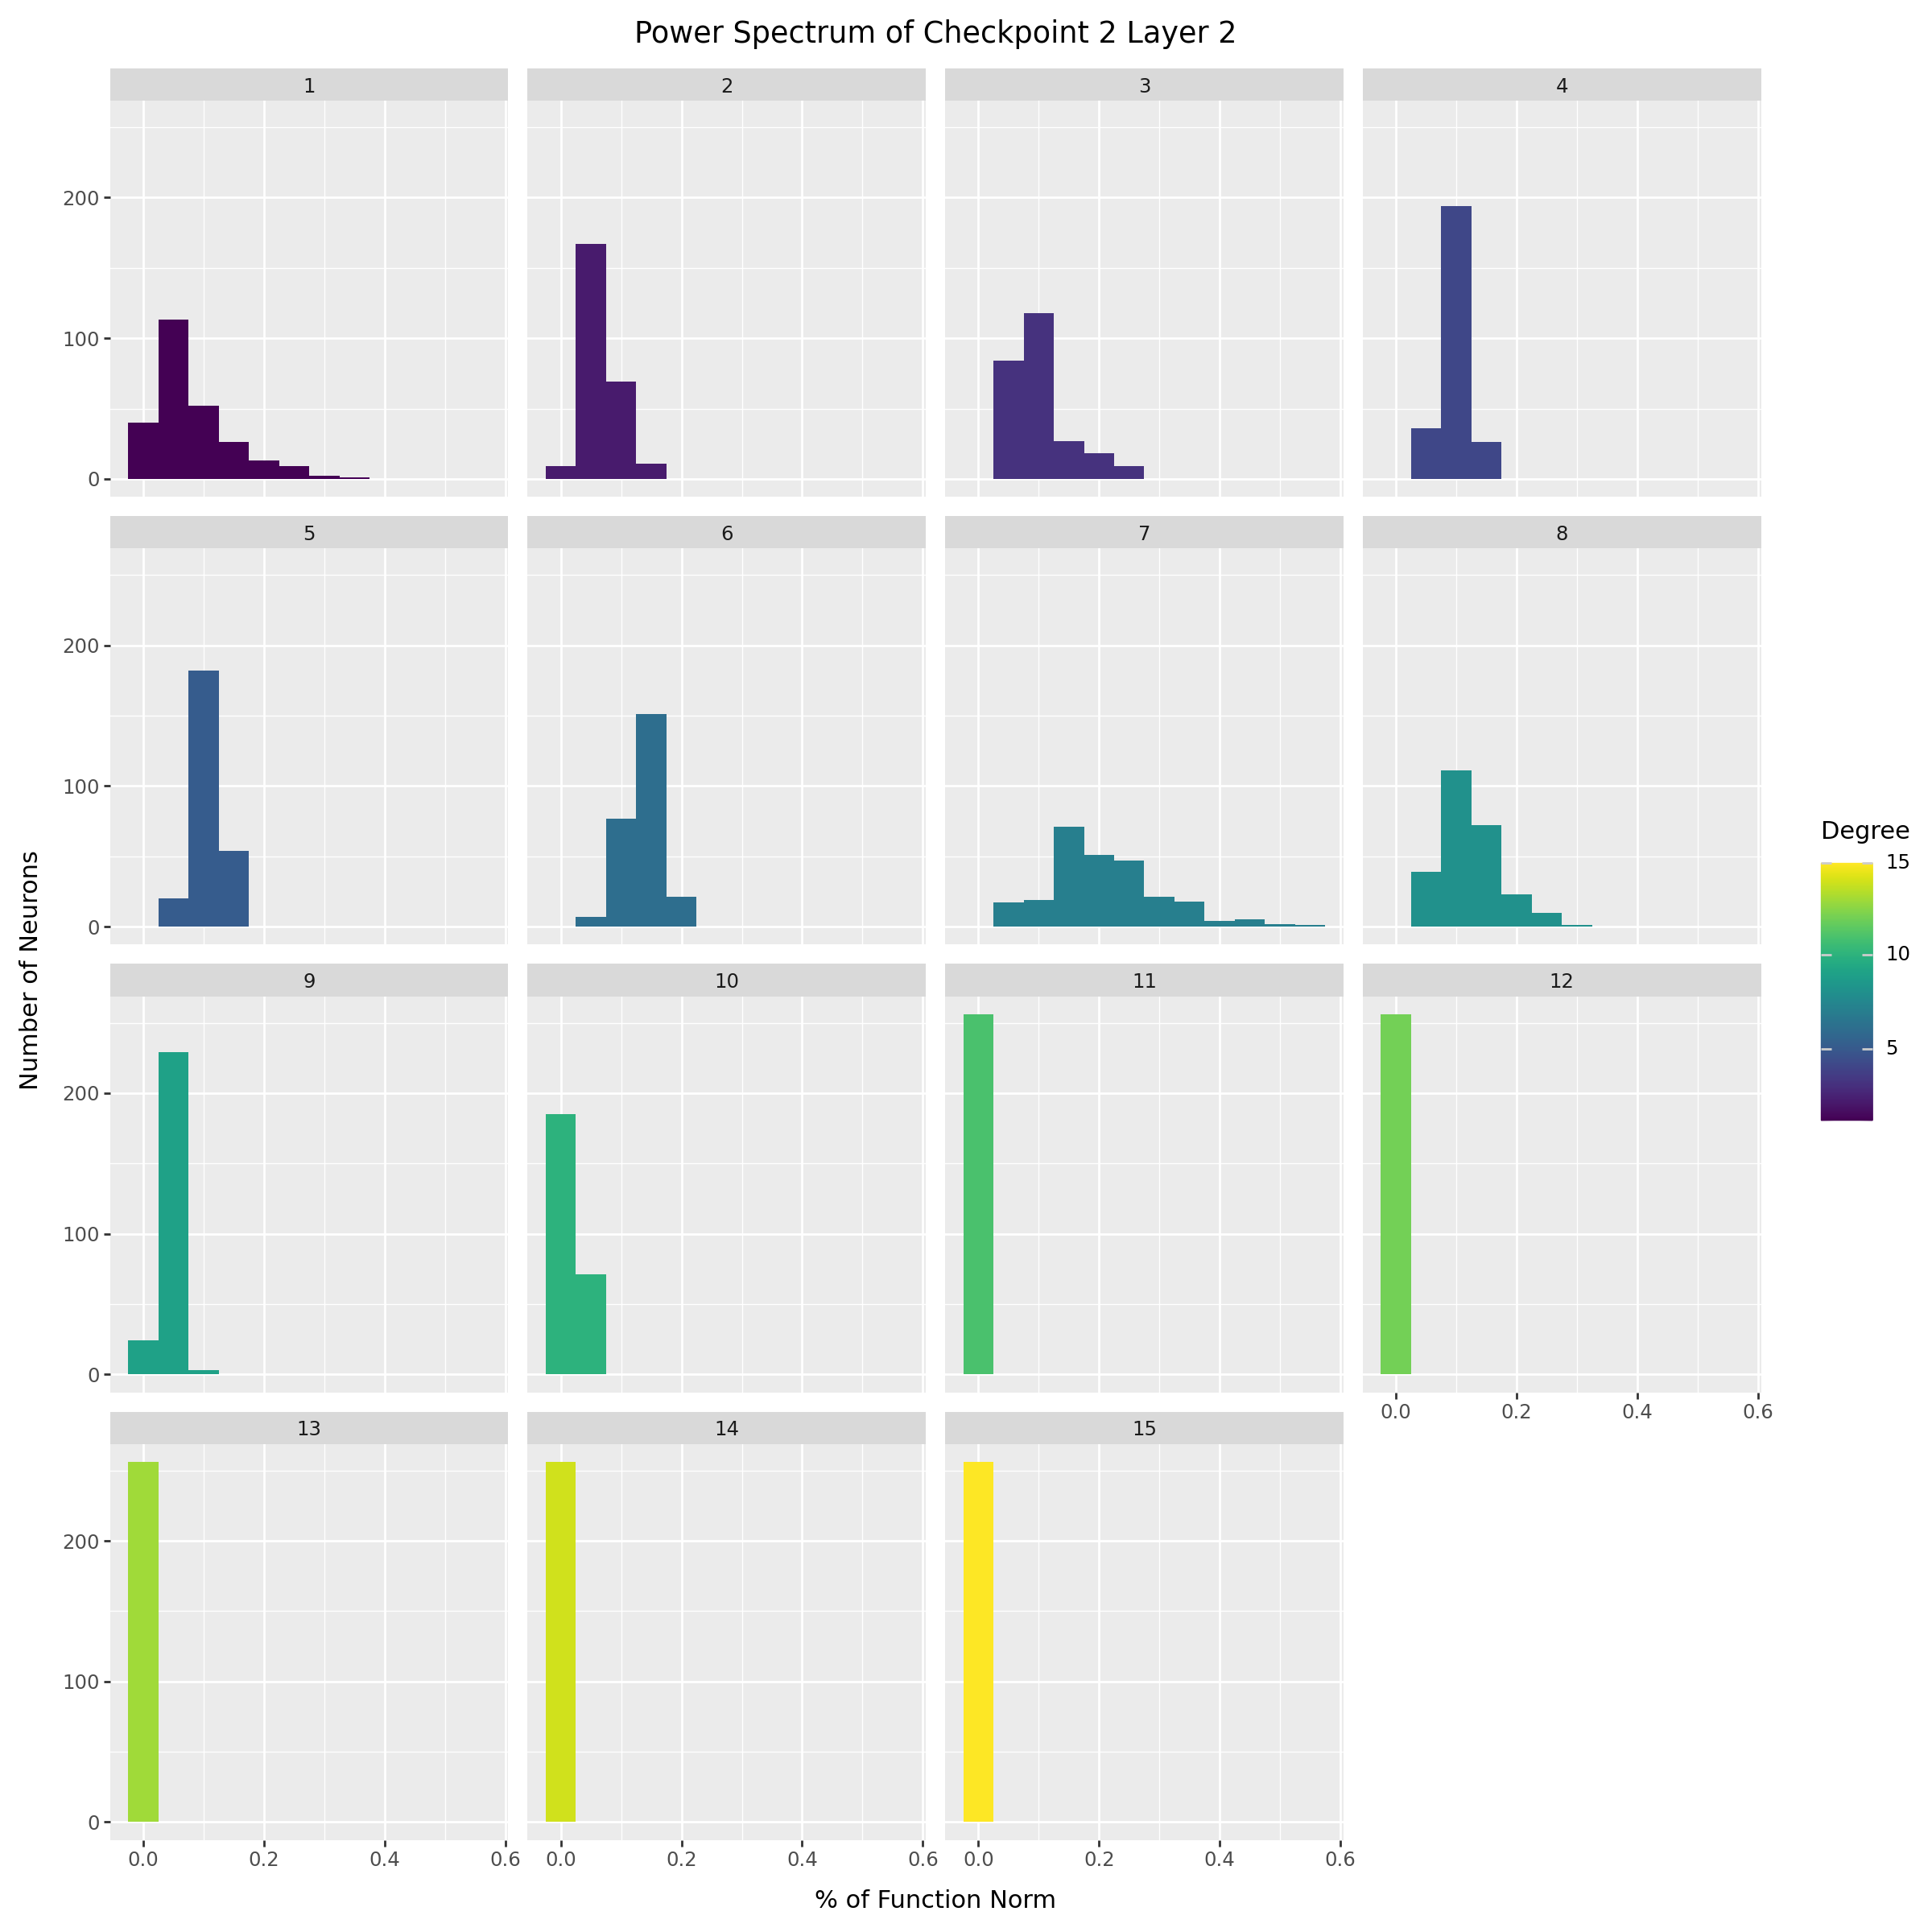

In [55]:
(
    ggplot(spectrum2_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 2 Layer 2')
)

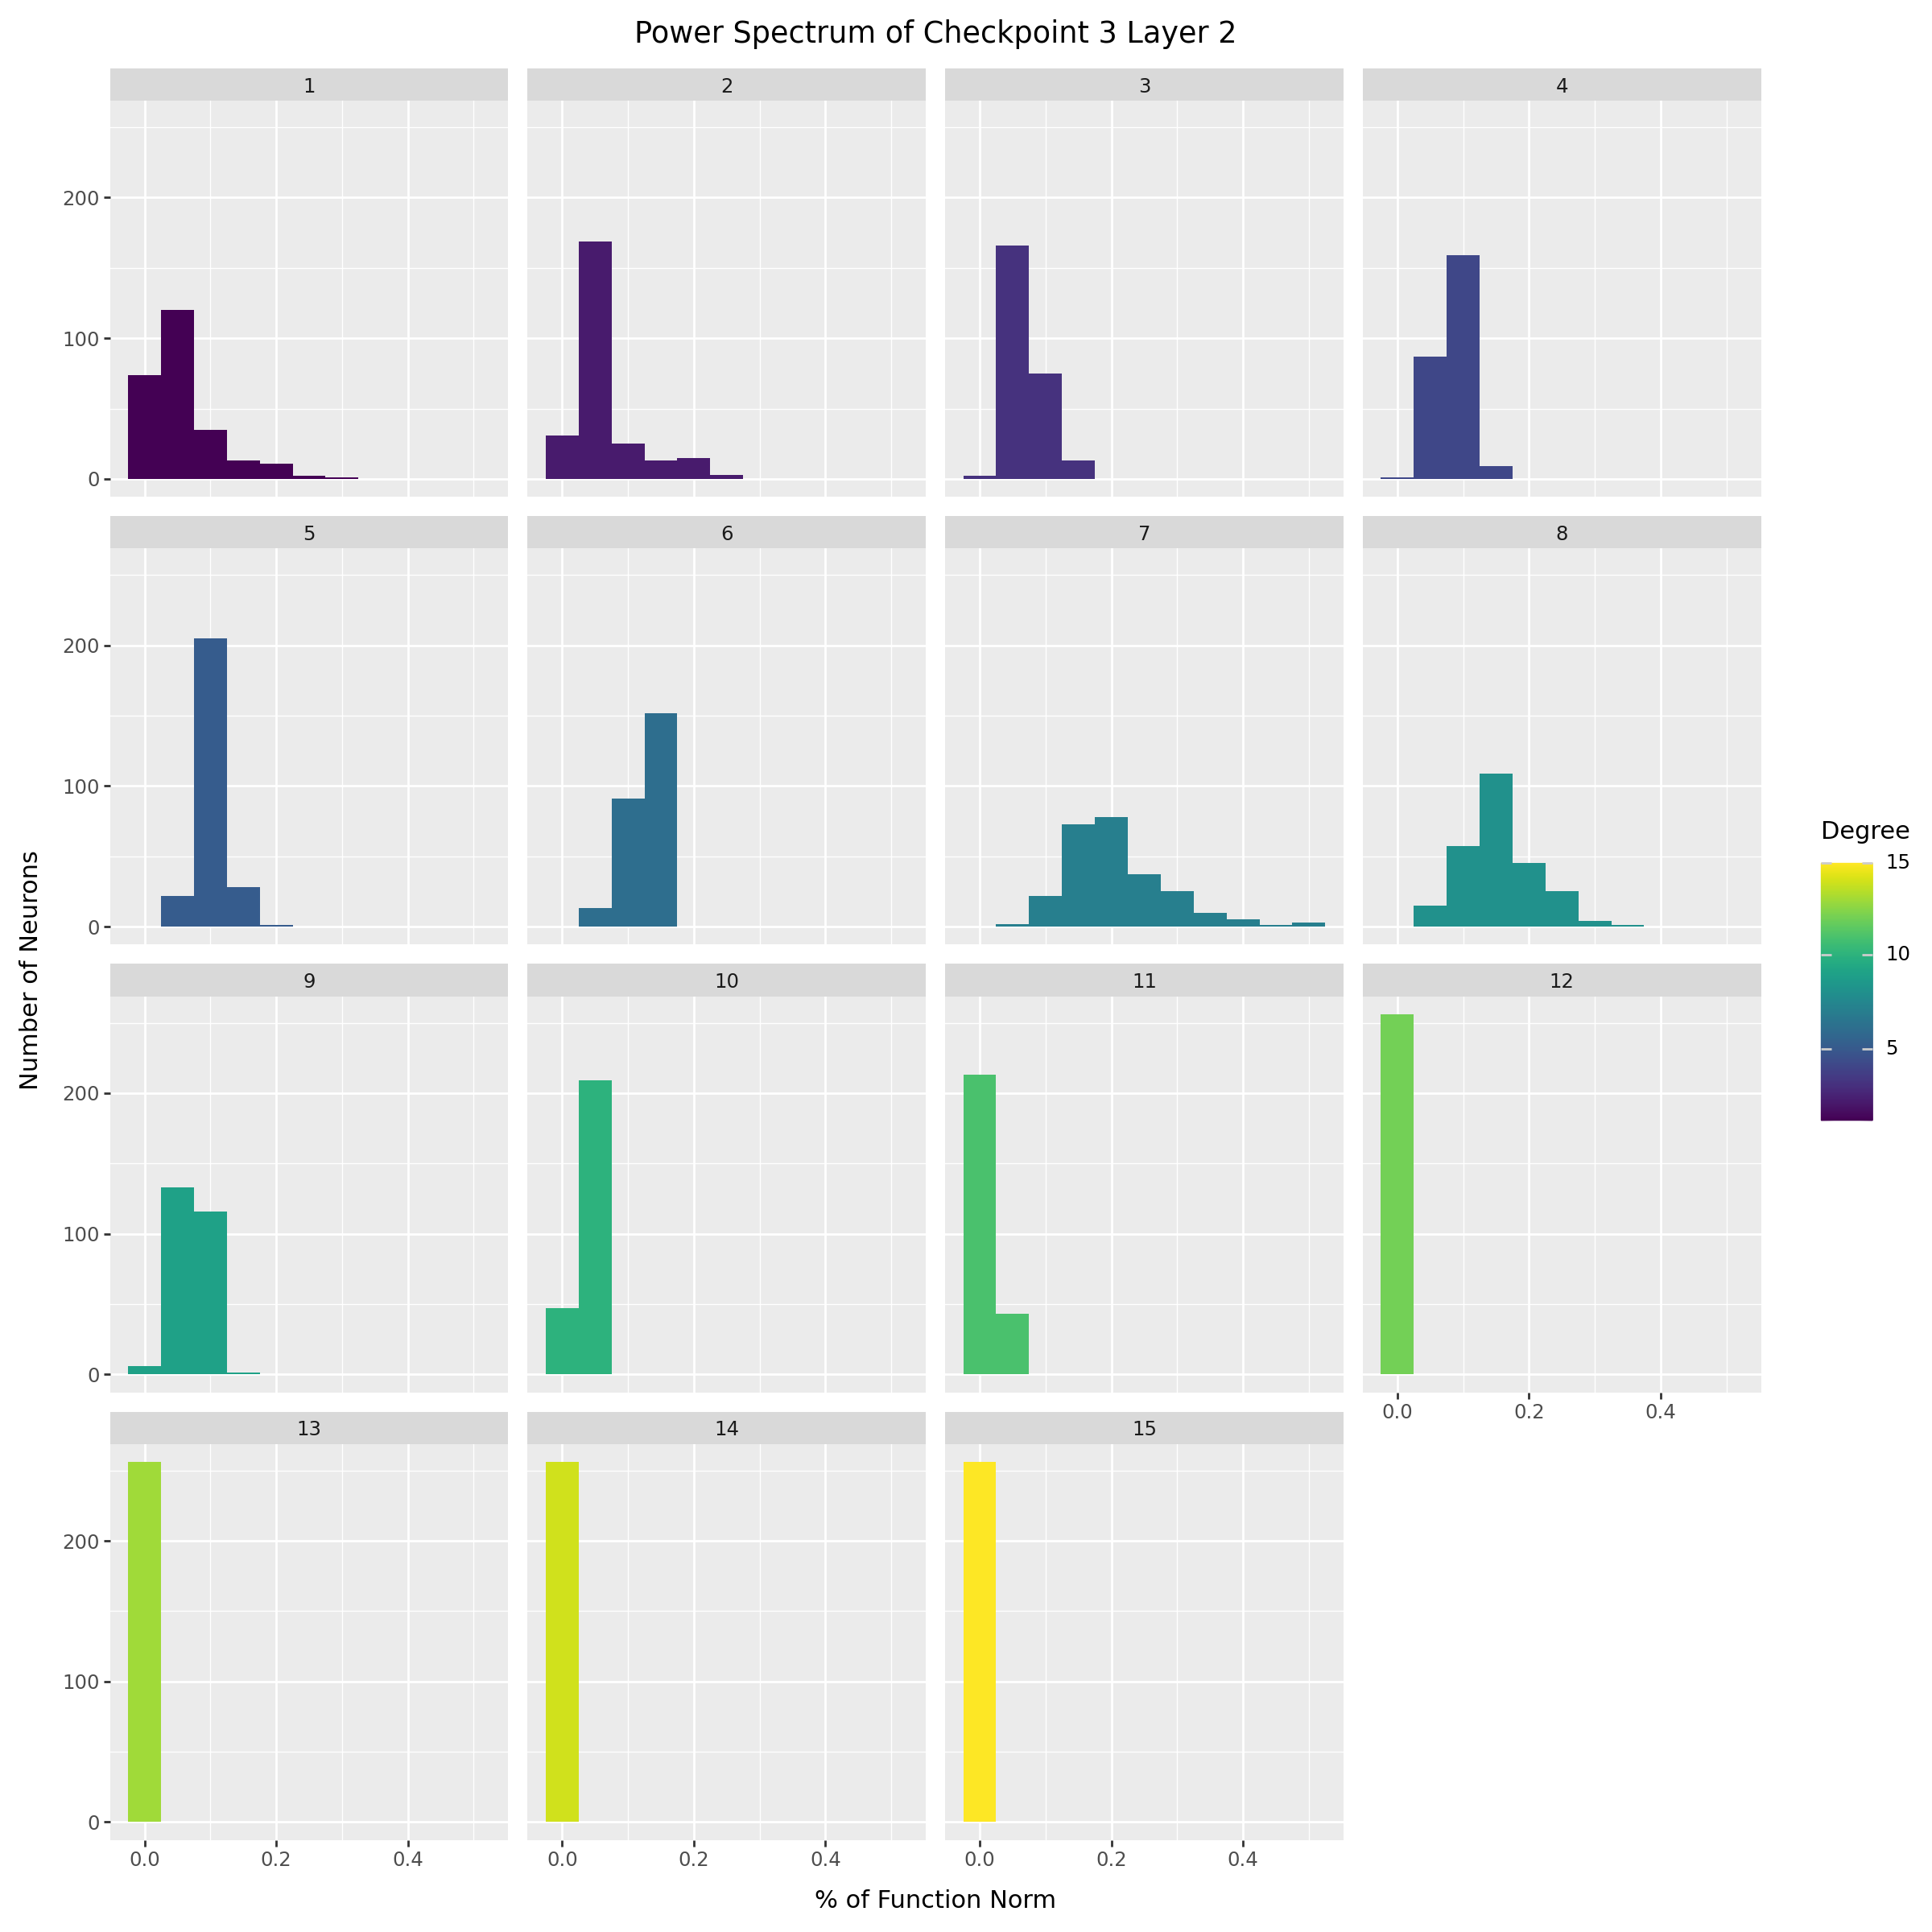

In [56]:
(
    ggplot(spectrum3_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 3 Layer 2')
)

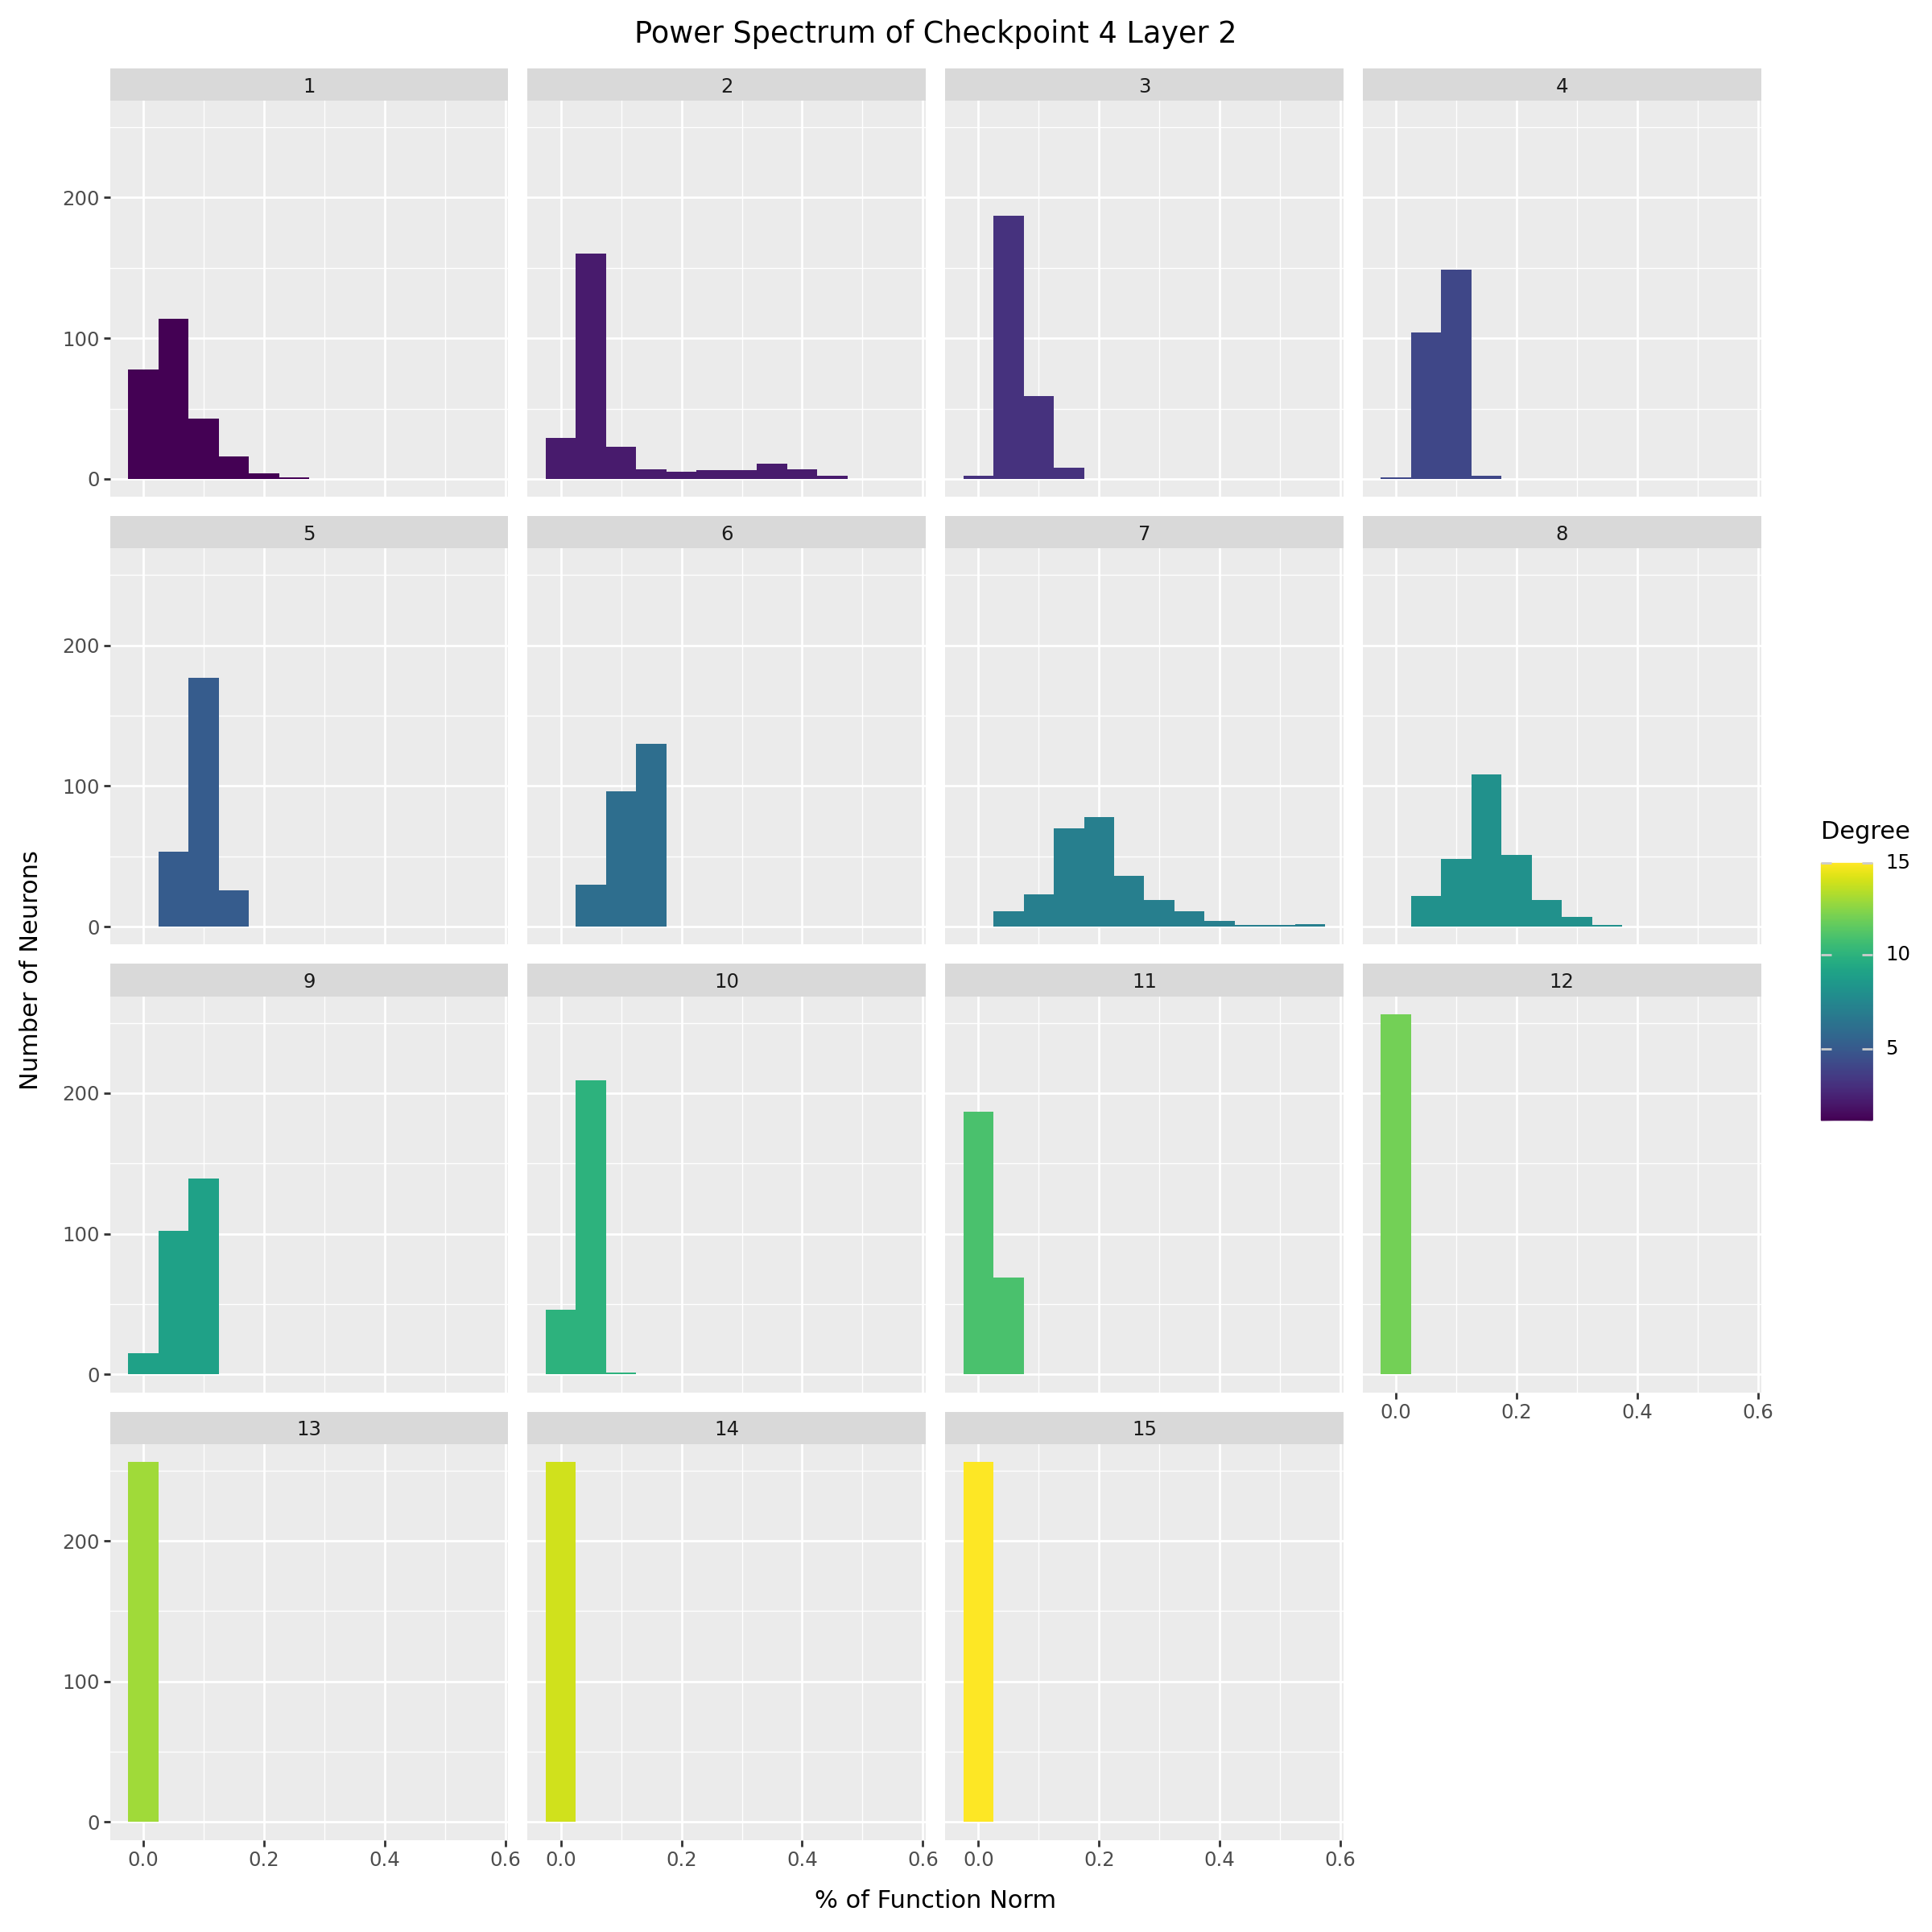

In [58]:
(
    ggplot(spectrum4_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 4 Layer 2')
)

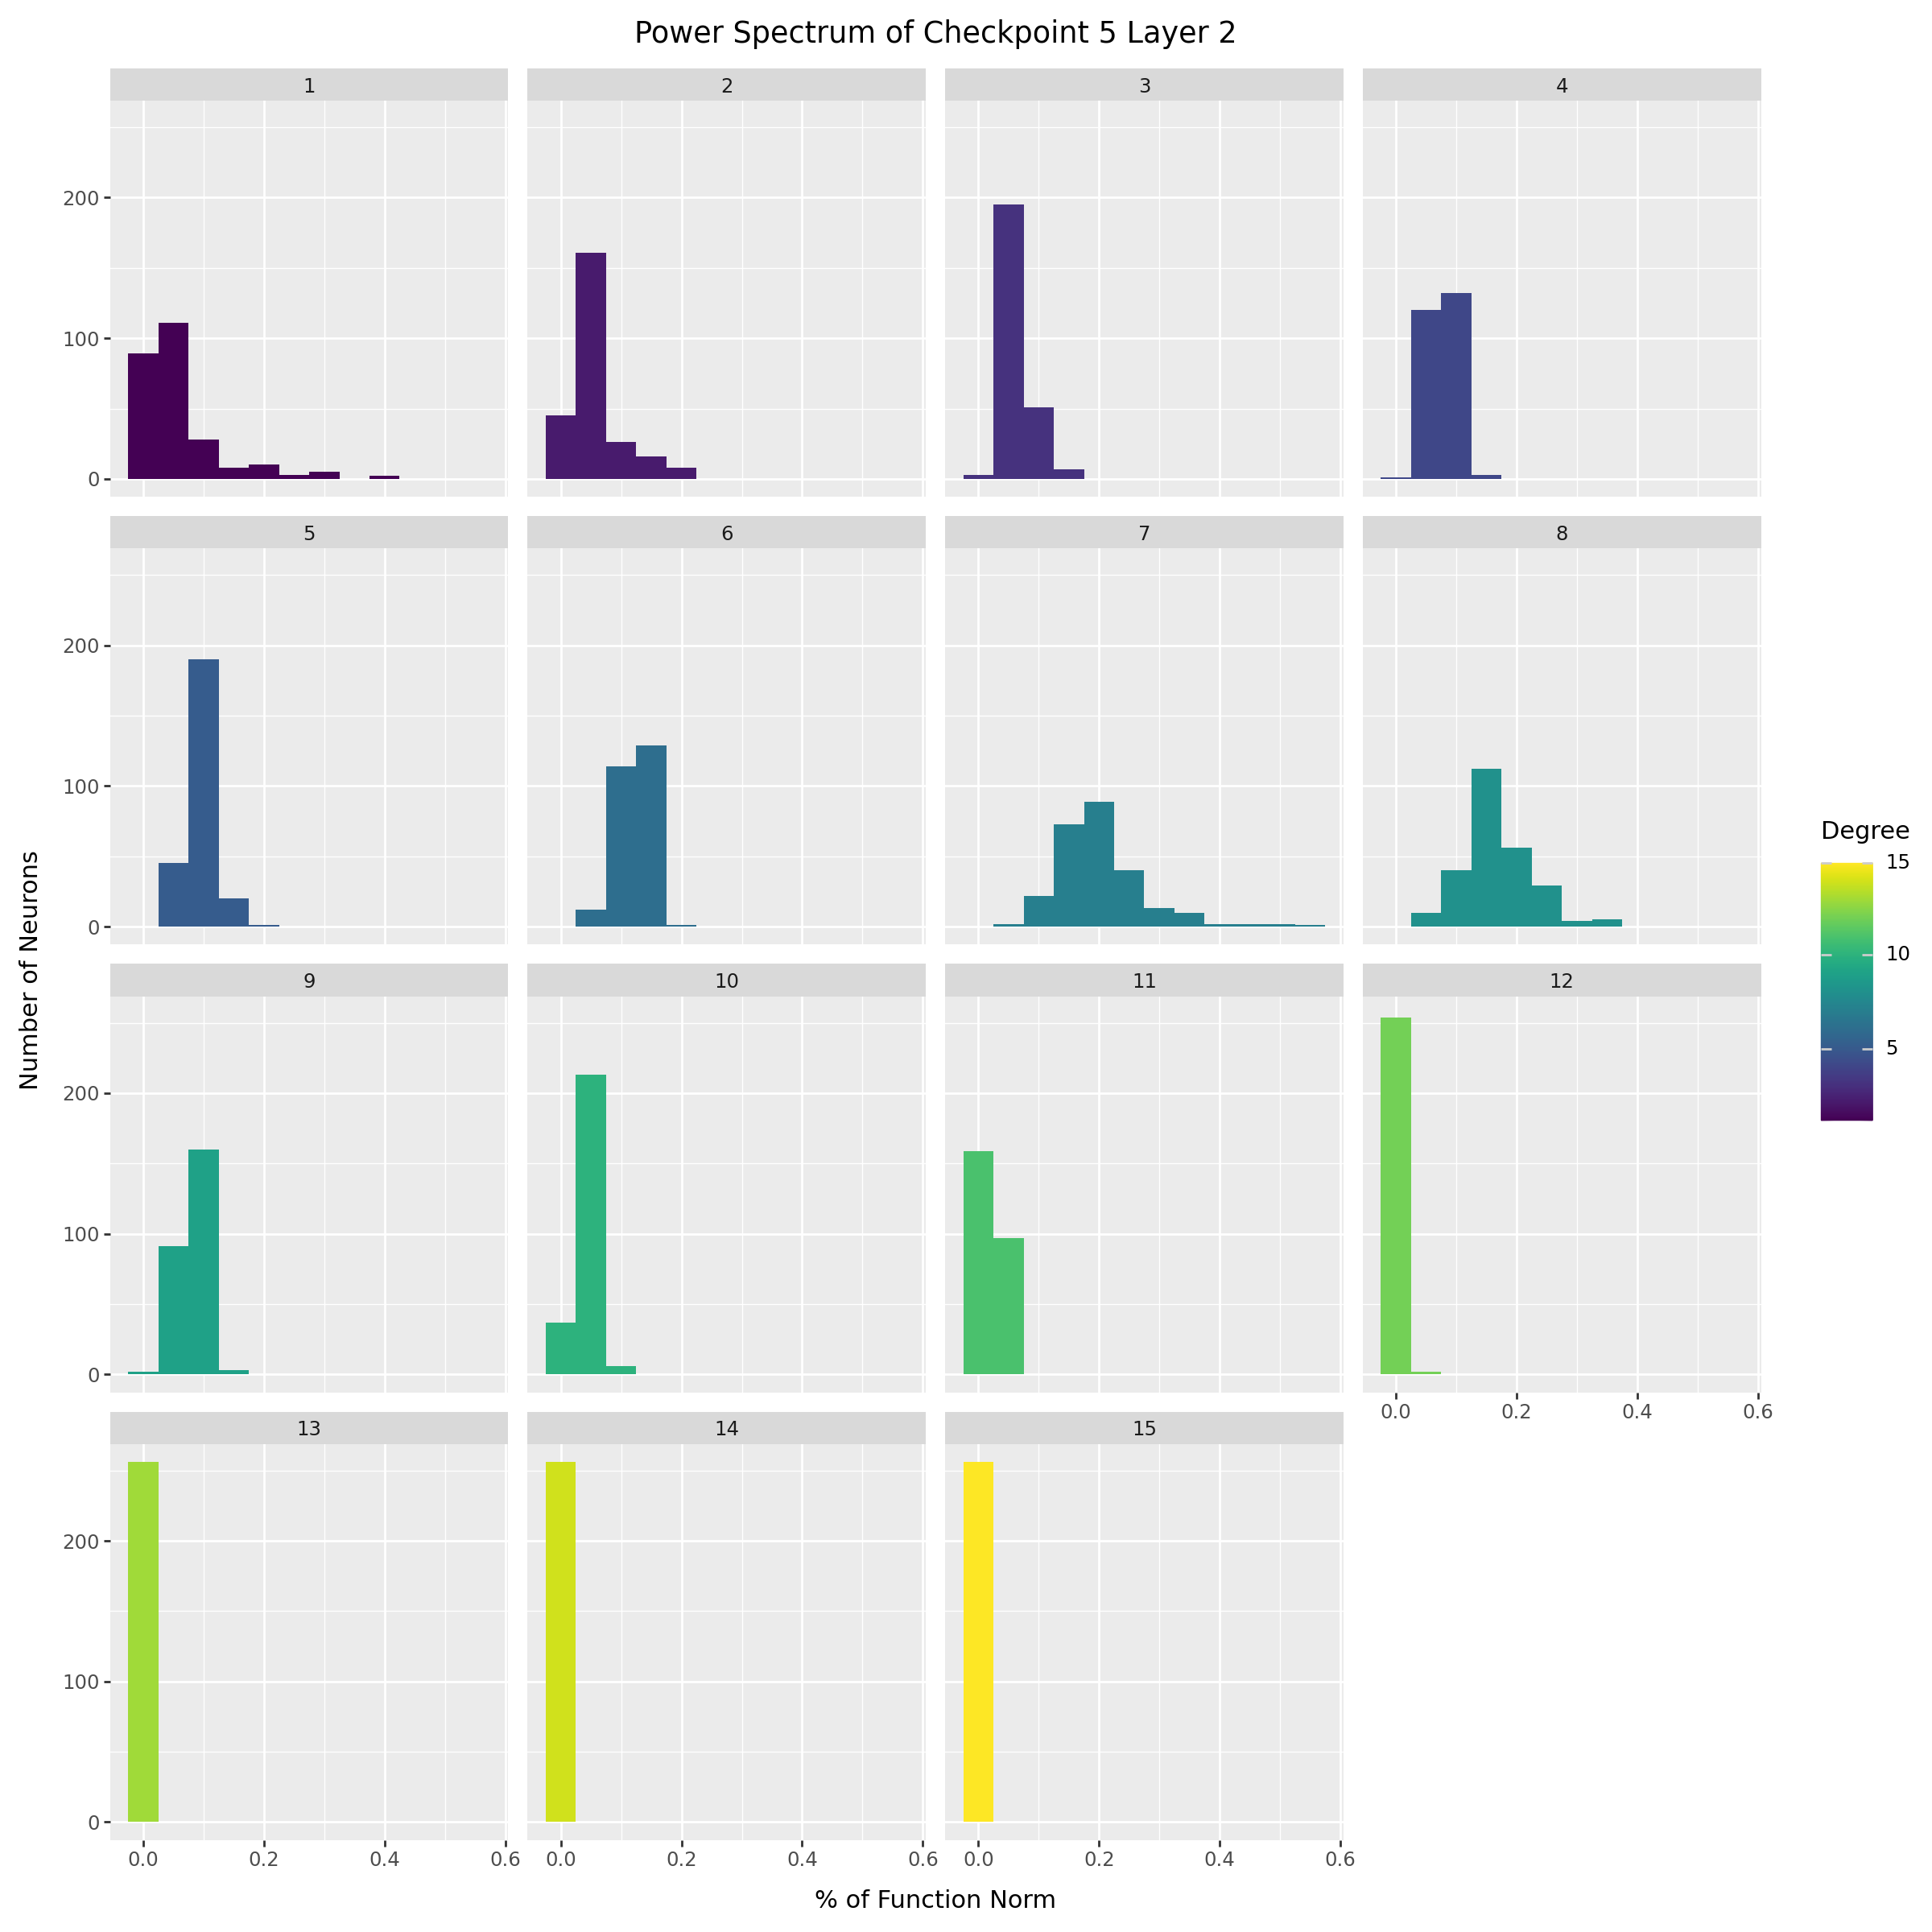

In [59]:
(
    ggplot(spectrum5_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 5 Layer 2')
)

In [44]:
#model0_mlp0_fourier = hadamard_df(model0_activations[0], all_labels[:, -1], 15)
#model0_mlp1_fourier = hadamard_df(model0_activations[1], all_labels[:, -1], 15)
#model0_mlp2_fourier = hadamard_df(model0_activations[2], all_labels[:, -1], 15)

In [46]:


ggplot()

index,label,actions,bits,degree,parity,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,…,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
u32,str,list[str],list[i64],i64,i64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
0,"""s""","[""s"", ""s"", … ""s""]","[0, 0, … 0]",0,0,276.509125,112.039871,561.969666,-355.198242,-338.972168,-96.488396,-471.5336,-859.855469,-52.488274,402.838593,608.90155,1045.753418,-386.057739,-222.953583,411.044556,-167.332123,195.095093,172.957581,-584.119507,115.957893,79.544853,-9.801736,568.132324,155.072159,-138.000534,89.007713,599.75531,199.939697,-647.765137,1290.973022,91.002678,…,154.74678,410.74707,-416.201141,-250.751389,258.887085,-482.987152,445.888489,-767.332031,11.21615,-527.814209,-562.420044,884.276794,-399.796844,-456.318115,289.773895,-838.35437,377.319061,481.746918,-64.277191,-461.220917,-526.668152,-933.681152,-533.362915,-400.673035,-354.529572,582.354126,-543.730164,-919.978455,129.507416,263.245575,-150.017838,176.103638,-413.323853,-32.899799,-445.796509,157.714493,-169.024277
1,"""r""","[""r"", ""s"", … ""s""]","[1, 0, … 0]",1,1,-3.44351,35.466499,10.989511,29.47401,17.890438,-14.321224,-8.873779,30.018215,1.1253,-13.542555,15.940849,-2.389288,19.355705,15.176071,-6.254235,27.161139,4.584384,-14.351982,12.277381,-13.750535,-25.180645,-17.77338,19.063051,16.572483,18.88113,15.888465,-21.969252,21.838287,19.580416,12.919472,-20.477812,…,-18.01721,-44.336208,-7.125171,-4.274495,23.097557,-30.660223,-18.404079,4.344867,17.305176,14.533958,-9.994309,11.76146,-11.682714,-38.004593,6.781107,24.371742,42.508499,-5.279115,-19.447794,-29.847031,-46.574604,21.224979,4.209926,5.480251,4.644069,37.896721,-27.503246,17.570539,8.587712,59.029701,-20.596983,-24.252886,-9.010415,20.481848,-9.669672,-12.232229,32.418537
2,"""r**4""","[""s"", ""r"", … ""s""]","[0, 1, … 0]",1,1,0.060013,0.60752,1.414786,0.674322,1.055981,0.695536,0.424865,1.953243,0.300032,-0.233541,0.18812,-1.163182,-1.778359,1.493637,0.723676,0.637914,1.113648,-2.259431,0.213699,-0.698493,0.360662,1.034513,-0.757999,-1.162262,0.747861,-1.20811,0.192084,1.17329,0.836666,-1.267015,1.025064,…,-0.815113,-1.259277,3.02138,-1.43275,0.848591,-1.081542,0.466032,2.188566,-1.663899,0.61897,-0.76733,0.258585,-0.182118,0.216658,1.479171,0.228023,0.213495,2.983645,-0.619852,-0.184627,0.563565,-0.293881,0.296275,2.08352,-1.606043,0.536783,0.267935,-0.46971,1.390943,-0.625114,1.895617,-0.357334,0.52575,-0.583617,0.146542,-0.04659,0.387024
3,"""sr**2""","[""r"", ""r"", … ""s""]","[1, 1, … 0]",2,0,-0.133367,0.019828,0.114827,-0.106361,0.025733,-0.186838,0.035812,0.066346,0.23835,0.027366,-0.067064,-0.263159,-0.160277,-0.037105,0.039079,0.084652,-0.264238,0.109714,-0.148055,0.13243,0.033185,-0.146078,-0.017721,-0.022242,0.05989,-0.088247,0.029328,0.08592,0.137334,0.048007,0.021513,…,-0.234632,-0.05068,0.228349,-0.229006,-0.11826,-0.32372,-0.110871,0.145416,-0.280708,0.28103,0.195033,0.155377,-0.093591,0.080931,0.264111,0.00953,0.056941,-0.088446,0.102627,-0.062872,0.07766,-0.221206,-0.094176,-0.027308,-0.055917,0.265157,0.054876,-0.012708,-0.167167,0.024417,-0.076684,-0.06031,0.016137,-0.073635,0.15237,0.0946,-0.124588
4,"""r""","[""s"", ""s"", … ""s""]","[0, 0, … 0]",1,1,0.914102,-0.374746,0.372909,-0.321953,-0.23592,-0.311772,-0.570934,-0.250326,-0.03609,-0.896818,-0.737384,0.219481,0.777851,-0.632162,-0.232055,0.374858,0.091733,0.644951,-0.569695,-0.093932,-0.48894,-2.211318,1.113448,-0.021266,-0.336879,-0.000347,-0.711932,-1.126908,-0.483861,0.714687,0.30614,…,1.841847,0.557767,-1.120697,0.830863,0.710035,-0.004749,0.029705,-0.397961,0.666718,-0.201729,-0.180549,-0.038748,-0.516064,1.

In [48]:
power0_df = (
    model0_mlp0_fourier
    .filter(pl.col('degree') != 0)
    .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
    .melt(variable_name='column').group_by('column')
    .agg(pl.col('value').pow(2).sum().alias('total_power'))
)

df0 = (
    model0_mlp0_fourier
    .filt(
    ggplot(spectrum0_df.filter(pl.col('mlp_layer') == 2), aes(x='pcnt_power', fill='degree')) 
    + geom_histogram(binwidth=0.05) 
    + facet_wrap('~degree') 
    + theme(figure_size=(12, 12))
    + labs(x = '% of Function Norm', y='Number of Neurons', fill='Degree', title='Power Spectrum of Checkpoint 0 Layer 2')
)er(pl.col('degree') != 0)    
    .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
    #.select(['degree'] + randcols)
    #.filter(pl.col('degree') != 0)
    .melt(id_vars='degree', variable_name='column')
    .group_by(['degree', 'column'])
    .agg(
        [
            pl.col('value').pow(2).sum().alias('power')
        ]
    )
    .join(power0_df, on='column')
    .with_columns((pl.col('power') / pl.col('total_power')).alias('pcnt_power'))
    
)

In [ ]:
def calculate_hadamard_power_df(fourier_df):
    power = (
        fourier_df
        .filter(pl.col('degree') != 0)
        .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
        .melt(variable_name='column').group_by('column')
        .agg(pl.col('value').pow(2).sum().alias('total_power'))
    )
    
    data = (
        fourier_df
        .filter(pl.col('degree') != 0)    
        .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
        #.select(['degree'] + randcols)
        #.filter(pl.col('degree') != 0)
        .melt(id_vars='degree', variable_name='column')
        .group_by(['degree', 'column'])
        .agg(
            [
                pl.col('value').pow(2).sum().alias('power')
            ]
        )
        .join(power, on='column')
        .with_columns((pl.col('power') / pl.col('total_power')).alias('pcnt_power'))
    )
    return data





def get_checkpoint_parity_power_spectrum(model, sequence_length: int, mlp_layers: list[int]) -> pl.DataFrame:
    all_seqs = get_all_bits(sequence_length)
    all_labels = torch.stack([actions_to_labels(t) for t in all_seqs], dim= 0)
    activations = get_activations(model, all_seqs, mlp_layers)
    activation_data = []
    for layer_idx, tensor in activations.items():
        fourier_df = hadamard_df(tensor, all_labels[:, -1], sequence_length)
        power_df = calculate_hadamard_power_df(fourier_df).with_columns(pl.lit('layer_idx').alias('mlp_layer'))
        activation_data.append(power_df)
    return pl.concat(activation_data)
        

    

In [49]:
power1_df = (
    model0_mlp1_fourier
    .filter(pl.col('degree') != 0)
    .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
    .melt(variable_name='column').group_by('column')
    .agg(pl.col('value').pow(2).sum().alias('total_power'))
)

df1 = (
    model0_mlp1_fourier
    .filter(pl.col('degree') != 0)    
    .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
    #.select(['degree'] + randcols)
    #.filter(pl.col('degree') != 0)
    .melt(id_vars='degree', variable_name='column')
    .group_by(['degree', 'column'])
    .agg(
        [
            pl.col('value').pow(2).sum().alias('power')
        ]
    )
    .join(power1_df, on='column')
    .with_columns((pl.col('power') / pl.col('total_power')).alias('pcnt_power'))
)
    

In [50]:
power2_df = (
    model0_mlp2_fourier
    .filter(pl.col('degree') != 0)
    .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
    .melt(variable_name='column').group_by('column')
    .agg(pl.col('value').pow(2).sum().alias('total_power'))
)

df2 = (
    model0_mlp2_fourier
    .filter(pl.col('degree') != 0)    
    .select(pl.exclude(['index', 'bits', 'label', 'actions', 'parity']))
    #.select(['degree'] + randcols)
    #.filter(pl.col('degree') != 0)
    .melt(id_vars='degree', variable_name='column')
    .group_by(['degree', 'column'])
    .agg(
        [
            pl.col('value').pow(2).sum().alias('power')
        ]
    )
    .join(power2_df, on='column')
    .with_columns((pl.col('power') / pl.col('total_power')).alias('pcnt_power'))
)

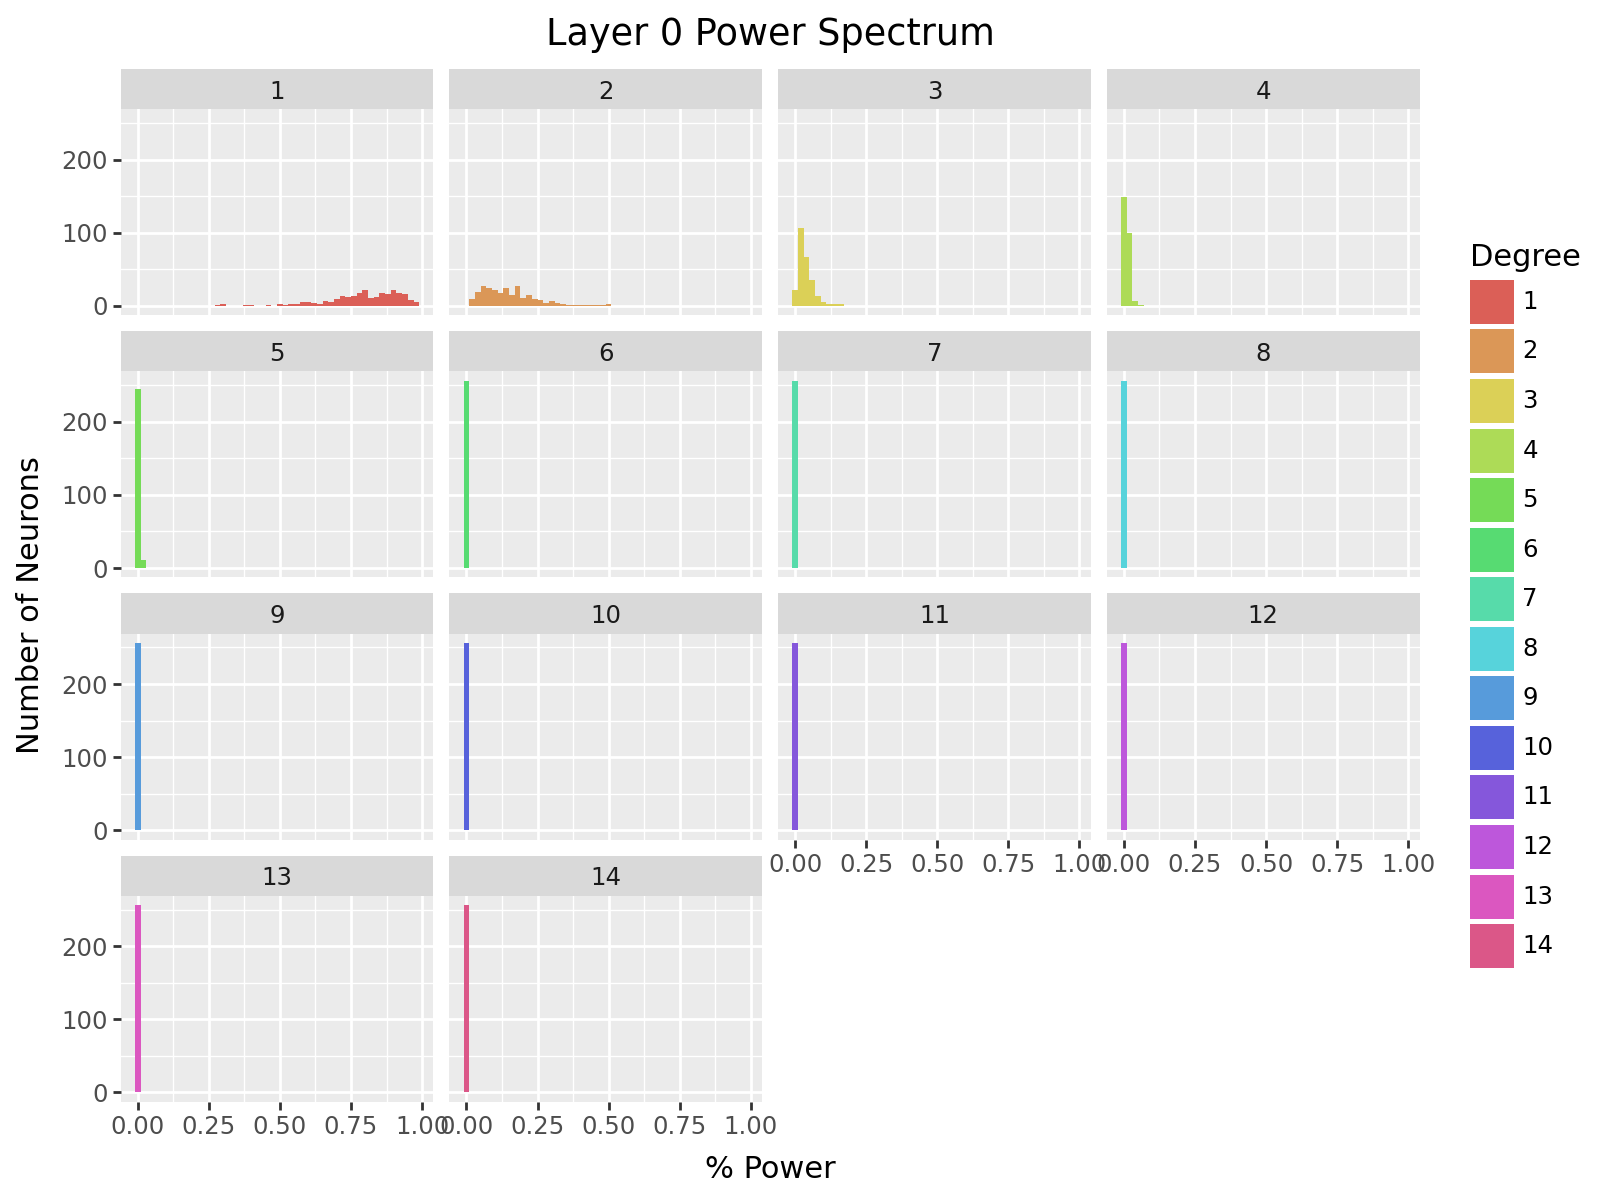

In [52]:
from plotnine import labs, ggplot, aes, geom_histogram, theme, facet_wrap

(
    ggplot(
        df0.filter(pl.col('degree').lt(15)), 
        aes(x='pcnt_power', fill='factor(degree)')
    ) 
    + geom_histogram(binwidth=0.02) 
    + facet_wrap('~degree') 
    + theme(figure_size=(8, 6))
    + labs(x= '% Power', y='Number of Neurons', title='Layer 0 Power Spectrum', fill='Degree')
)

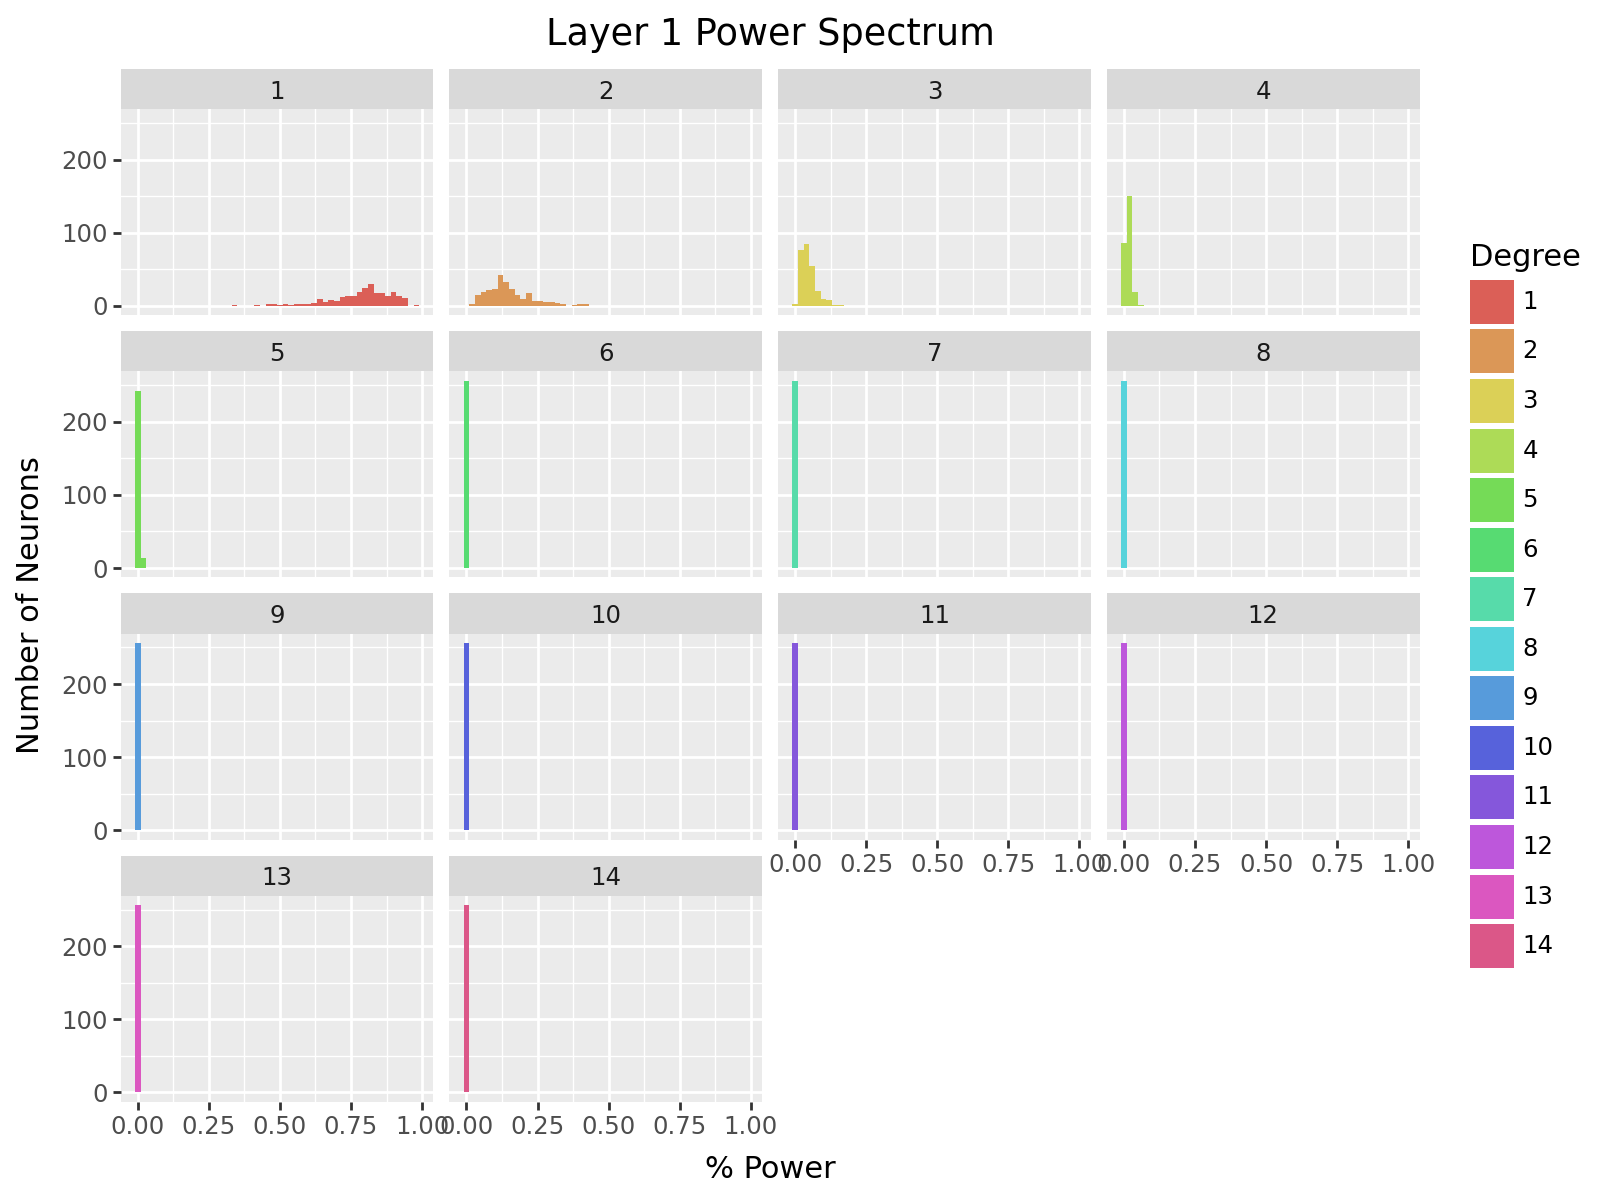

In [53]:
from plotnine import labs

(
    ggplot(
        df1.filter(pl.col('degree').lt(15)), 
        aes(x='pcnt_power', fill='factor(degree)')
    ) 
    + geom_histogram(binwidth=0.02) 
    + facet_wrap('~degree') 
    + theme(figure_size=(8, 6))
    + labs(x= '% Power', y='Number of Neurons', title='Layer 1 Power Spectrum', fill='Degree')
)

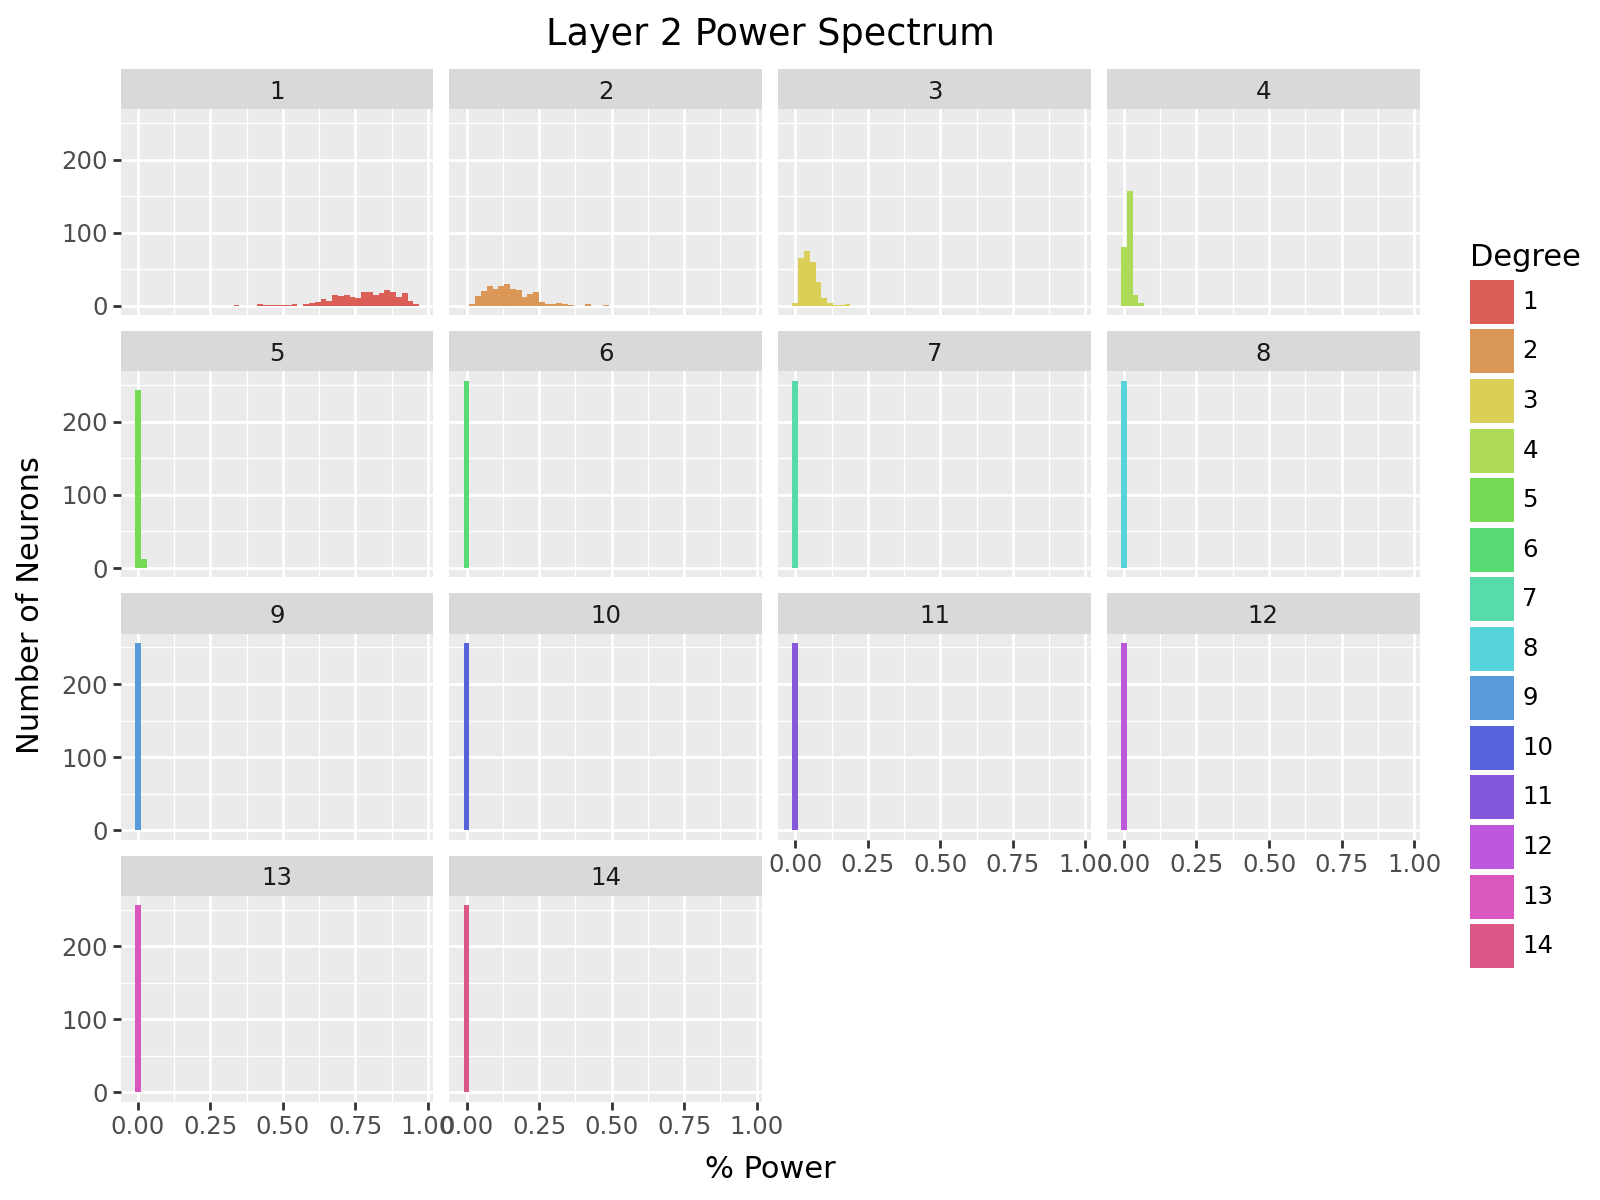

In [54]:
from plotnine import labs

(
    ggplot(
        df2.filter(pl.col('degree').lt(15)), 
        aes(x='pcnt_power', fill='factor(degree)')
    ) 
    + geom_histogram(binwidth=0.02) 
    + facet_wrap('~degree') 
    + theme(figure_size=(8, 6))
    + labs(x= '% Power', y='Number of Neurons', title='Layer 2 Power Spectrum', fill='Degree')
)

In [182]:
act_mean = torch.mean(mlp2_acts, dim=0)
act_stddev = torch.std(mlp2_acts, dim=0)

data_scaled = (mlp2_acts - act_mean) / act_stddev

In [33]:
U, S, V = torch.svd(data_scaled)

In [37]:
( (S ** 2).cumsum(0) / (S ** 2).sum())[:16]

tensor([0.1520, 0.2885, 0.4126, 0.5348, 0.6312, 0.7110, 0.7805, 0.8237, 0.8626,
        0.8830, 0.8992, 0.9129, 0.9241, 0.9346, 0.9409, 0.9456])

In [38]:
data_projected = data_scaled @ V[:, :16]

In [41]:
group

[(0, 0),
 (0, 1),
 (1, 0),
 (1, 1),
 (2, 0),
 (2, 1),
 (3, 0),
 (3, 1),
 (4, 0),
 (4, 1)]

In [76]:
from plotnine import ggplot, aes, geom_histogram, geom_line, labs, facet_wrap
import polars as pl

# [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# [0, 5, 1, 6, 2, 7, 3, 8, 4, 9]


translation = {
    (0,0):0,
    (1,0):1,
    (2,0):2,
    (3,0):3,
    (4,0):4,
    (0,1):5,
    (1,1):6,
    (2,1):7,
    (3,1):8,
    (4,1):9,
}


def actions_to_elements(actions):
    return ['r' if act else 's' for act in actions]

def make_dihedral_df(tensor, labels, m):
    tensor_df = pl.DataFrame(tensor.detach().cpu().numpy(), schema = [str(i) for i in range(tensor.shape[1])])
    idx_to_el = {
        0: 'e', #(0,0),
        1: 'r', #(1,0),
        2: 'r**2', #(2,0),
        3: 'r**3', #(3,0),
        4: 'r**4', #(4,0),
        5: 's', #(0,1),
        6: 'sr', #(1,1),
        7: 'sr**2', #(2,1),
        8: 'sr**3', #(3,1),
        9: 'sr**4', #(4,1)
    }
    all_seqs = get_all_bits(15)
    actions = [actions_to_elements(seq) for seq in all_seqs.tolist()]
    label_df = (
        pl.DataFrame({'label': labels.cpu().numpy(), 'actions': actions})
        .with_columns([
            pl.col('label').replace(idx_to_el)
        ])
    )
    return pl.concat([label_df, tensor_df], how='horizontal')
    



In [106]:
mlp2_df = make_dihedral_df(mlp2_acts, all_labels[:, -1], 15)
mlp2_df.head()

label,actions,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,…,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255
str,list[str],f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""s""","[""s"", ""s"", … ""s""]",4.595992,-4.192276,-3.578617,0.607184,2.137938,-4.922388,-6.194739,0.932892,0.045556,-3.446851,-0.881104,0.607188,-0.562767,-1.17687,-5.173928,-3.588208,1.450408,-1.716178,-2.625173,8.272294,0.942868,-5.039779,-2.066076,-1.540712,2.236324,-5.898036,-7.734102,1.969921,-3.794976,-4.589148,-3.40343,-1.745211,-4.040778,-1.824277,7.709375,…,6.580497,5.758751,-0.279065,-0.034792,3.541285,-0.735219,-1.660544,2.214636,-3.968826,-3.514783,4.256265,6.005115,0.439447,-3.309436,-1.323614,6.637263,4.556893,1.27925,2.187699,3.978617,2.047701,-8.606427,-3.012953,-0.830471,-8.59376,8.853994,-2.682448,-7.796217,-0.504932,9.460233,-0.542921,-1.728862,9.892659,-5.242825,-1.988837,-7.947936,6.444261
"""r""","[""r"", ""s"", … ""s""]",7.155899,-2.759865,-4.654216,-3.791811,0.894671,-0.376682,-3.990393,0.583974,0.843966,1.606948,-7.838767,5.521605,-2.319798,-4.869898,-8.469213,0.779215,8.54497,16.740543,1.645282,5.716579,1.729024,1.661878,-2.96283,1.963164,1.990335,-2.87471,-1.252294,3.523706,-2.9526,-5.351494,2.857513,-8.823497,1.730853,4.198032,4.099207,…,7.53003,4.328575,-2.657864,7.319814,14.896555,-5.083203,2.196884,4.768893,2.33143,-0.761078,6.697421,5.878559,1.707126,-3.355912,4.900562,6.883435,5.728757,-3.389079,5.179778,-1.677069,2.616446,-7.599339,-3.587693,-2.372734,-0.290415,7.07326,-5.061919,-2.134023,-1.426842,6.76752,6.80183,-4.09552,5.731305,-4.534645,4.831323,-3.640491,4.820804
"""r**4""","[""s"", ""r"", … ""s""]",-2.984407,-4.114678,-5.920206,0.869048,1.969962,-4.690275,-1.243762,-0.860817,-3.100908,-6.71982,4.930879,-2.36779,-3.290516,3.83162,2.224188,-4.940067,-1.239851,0.522004,-4.383893,-2.245372,4.143535,-4.173647,-1.35483,-8.148245,-2.004948,-4.518774,-8.058679,2.926663,1.326261,0.05485,-5.853967,5.540593,-3.467738,-2.470449,8.76669,…,5.112556,0.9508,0.055537,-0.147911,8.838078,0.795791,-1.652282,-0.938238,-2.57248,-2.874233,-0.856264,0.075007,-3.158122,-4.017706,-5.408905,7.11665,1.805131,3.618598,-0.190766,1.698291,-0.610675,-10.138528,-3.866244,0.814271,-8.647216,3.663275,-2.903597,-6.96277,-0.414087,4.558223,-4.269927,-1.844139,2.236295,2.811054,-3.181456,-3.356543,5.774955
"""sr**2""","[""r"", ""r"", … ""s""]",5.417818,-0.185515,-8.590392,-5.472206,-7.093856,-2.551339,-0.699182,-3.484925,-0.947855,3.68816,-3.142698,3.873528,-9.297066,-2.680845,-5.854071,2.95228,6.614268,24.613604,-2.517088,-4.254427,6.814428,0.241649,0.47939,-1.966093,1.793238,1.377093,0.18342,3.774125,-0.587874,-4.378412,-1.258289,-5.098765,-0.138691,6.62678,1.943308,…,-0.263888,-0.822556,-3.276071,9.022517,24.380077,-7.494635,2.60616,5.005383,3.810548,-2.748433,5.562879,-1.288107,-0.731395,1.138765,2.592005,5.567407,3.957065,-6.173054,9.775227,-9.126354,4.49804,-6.733933,-5.597094,-3.459252,0.866474,5.122898,-6.306448,0.971039,-1.971051,2.601876,9.764221,-13.926966,0.674392,-3.628515,6.045377,2.222998,0.092119
"""r""","[""s"", ""s"", … ""s""]",5.942575,-2.393828,-3.874628,-2.577722,0.318573,-0.251627,-3.927213,0.032247,0.354633,1.354809,-6.701506,4.825752,-0.949138,-3.6162,-7.730608,0.970653,7.32732,14.151655,0.859174,5.79088,1.199651,1.173045,-2.794282,0.920854,1.78649,-2.918703,-0.655257,3.174351,-2.660509,-5.252728,1.281465,-7.737578,1.244607,3.08821,3.918628,…,5.914759,3.325732,-2.354947,6.086899,11.320226,-4.344053,1.530157,3.997679,1.614014,-0.63638,4.947932,5.813302,0.03447,-2.79291,3.778574,6.663393,5.075921,-2.7774,4.421117,-1.508241,2.076043,-5.93083,-3.067

In [107]:
labels.shape

torch.Size([64, 25])

In [108]:
mlp2_df['label'].unique()

label
str
"""r**4"""
"""r**3"""
"""s"""
"""sr**3"""
"""sr**4"""
"""sr**2"""
"""sr"""
"""r**2"""
"""e"""


In [128]:
irrep = DihedralIrrep(5, (1, 0)).matrix_representations()
ref = irrep[(0, 1)]
rot = irrep[(1, 0)]

In [133]:
torch.kron(rot, ref)

tensor([[ 0.3090,  0.0000, -0.9511, -0.0000],
        [ 0.0000, -0.3090, -0.0000,  0.9511],
        [ 0.9511,  0.0000,  0.3090,  0.0000],
        [ 0.0000, -0.9511,  0.0000, -0.3090]])

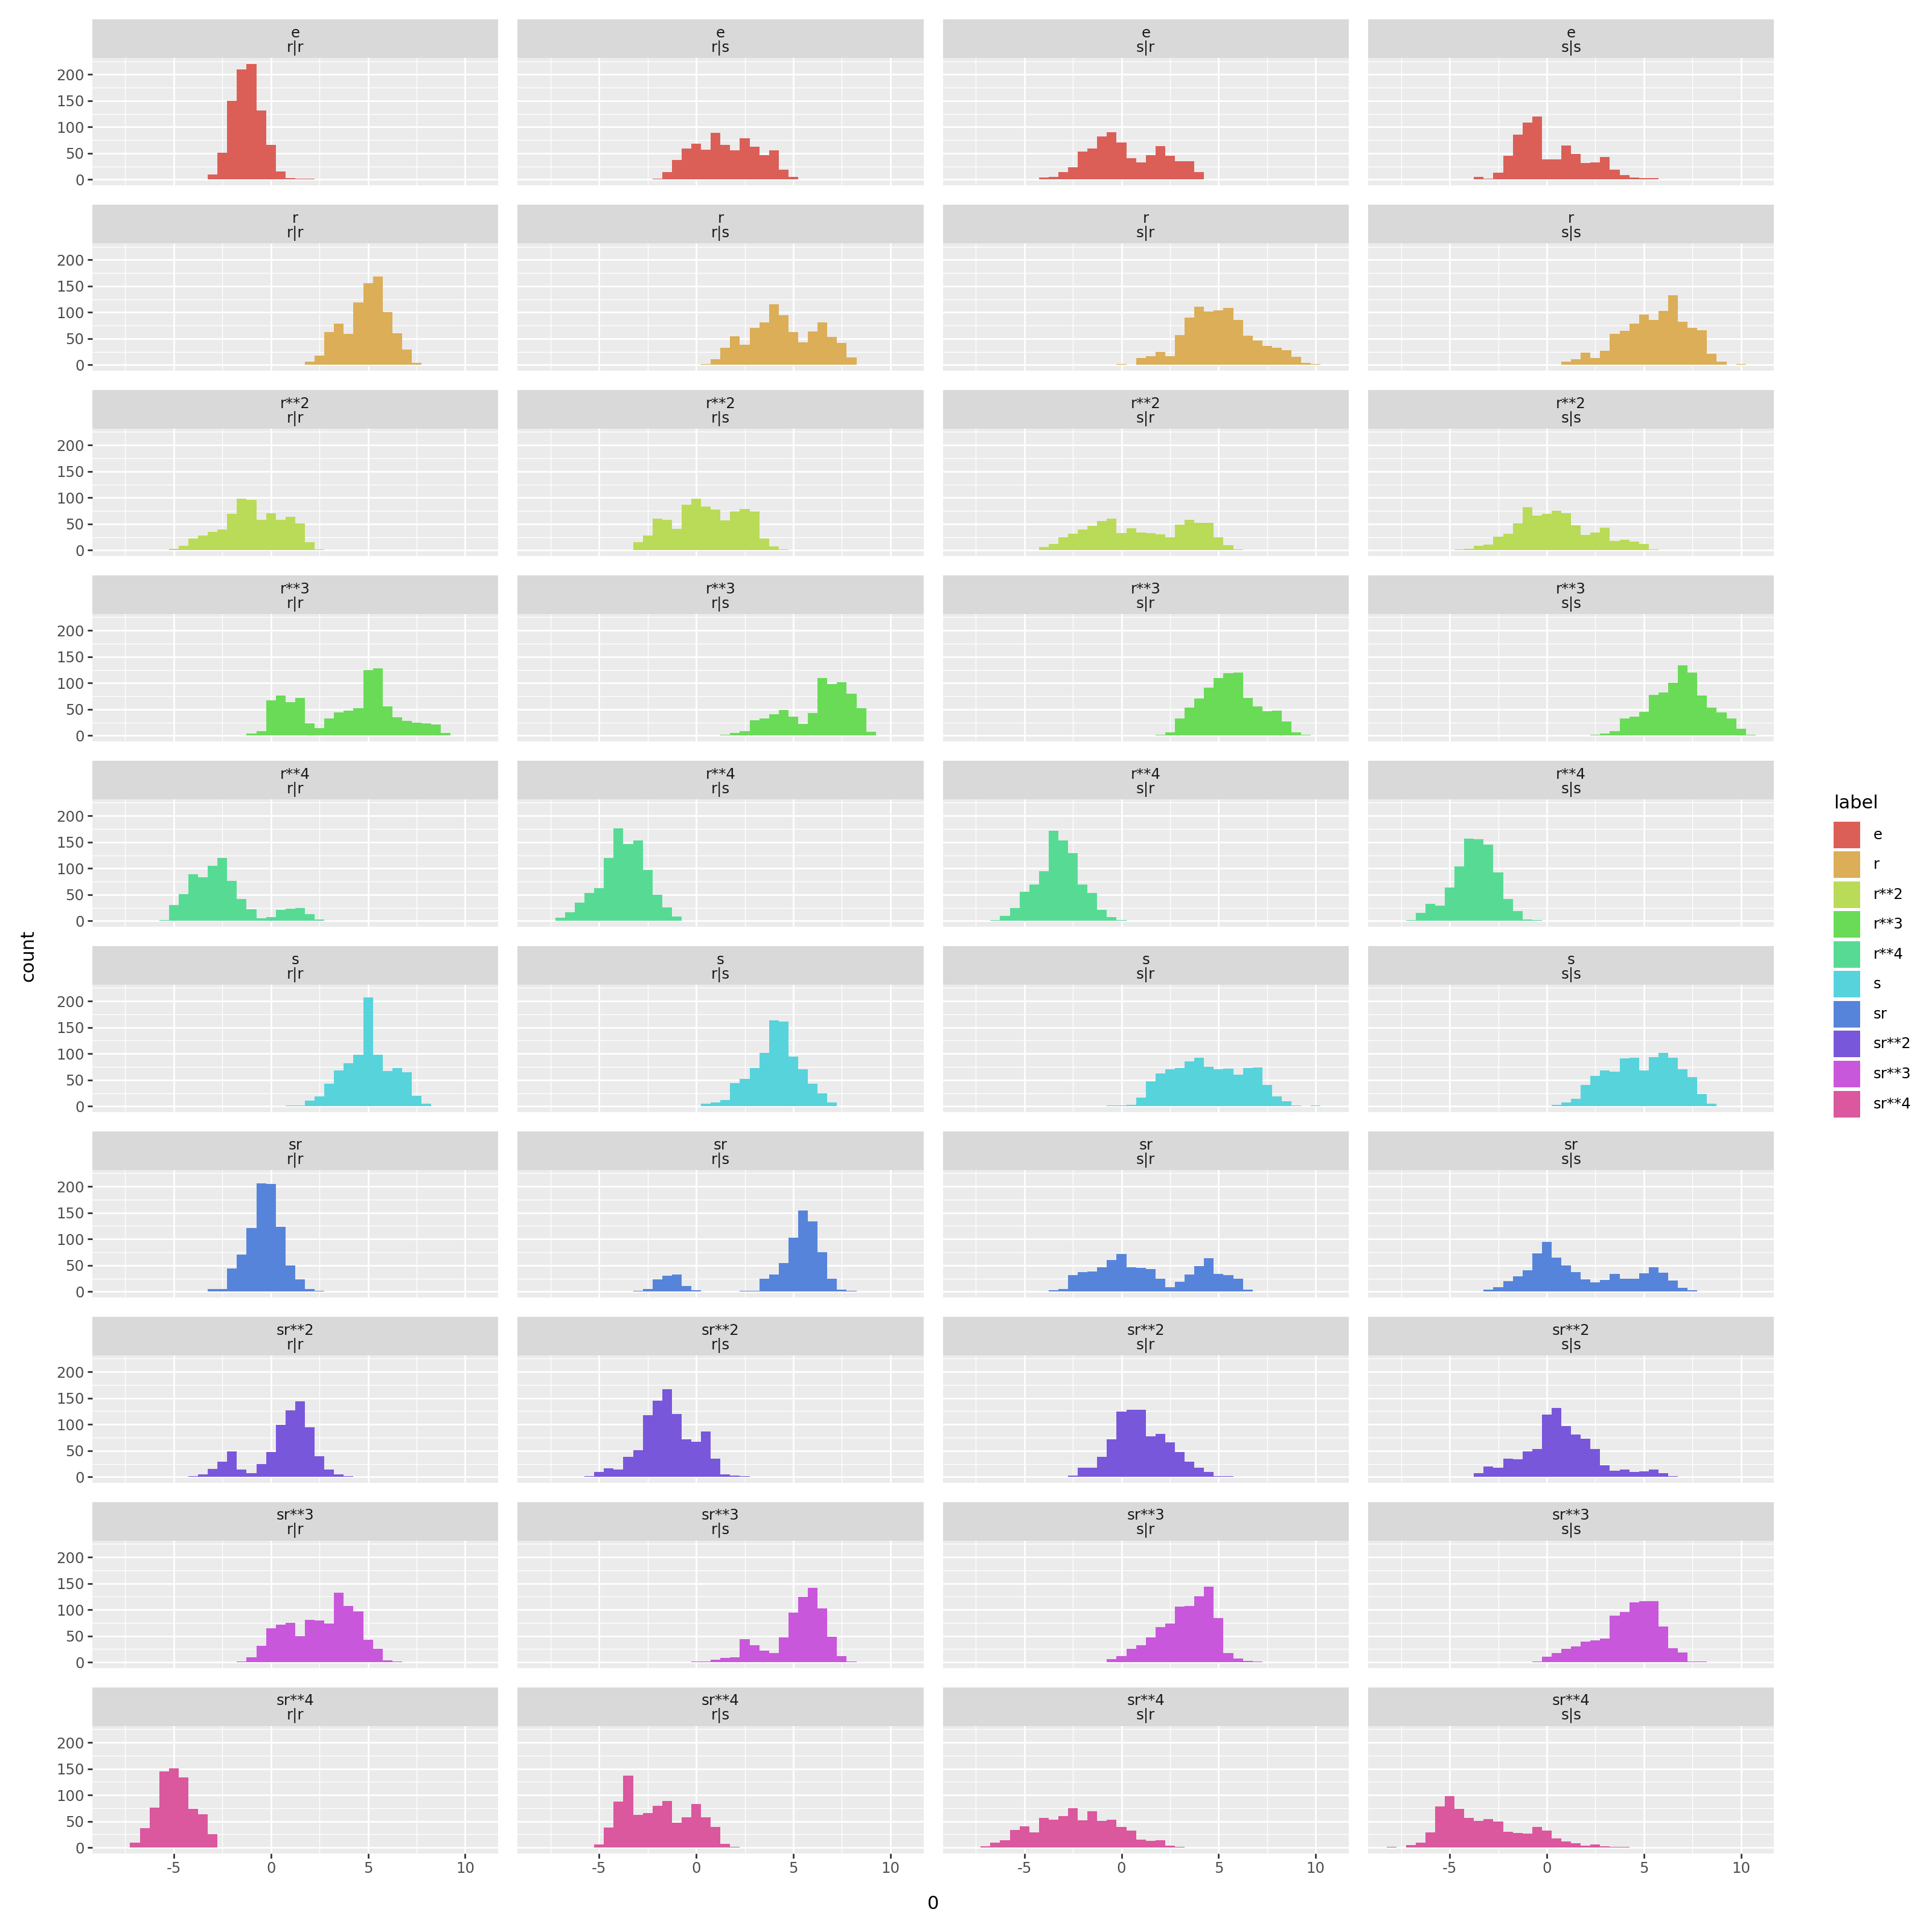

In [142]:

df = mlp2_df.with_columns((pl.col('actions').list.get(-2) + '|' + pl.col('actions').list.get(-1)).alias('last_act'))

ggplot(df, aes(x='0', fill='label')) + geom_histogram(binwidth=0.5) + facet_wrap('~label+last_act', ncol=4) + theme(figure_size=(16, 16), )

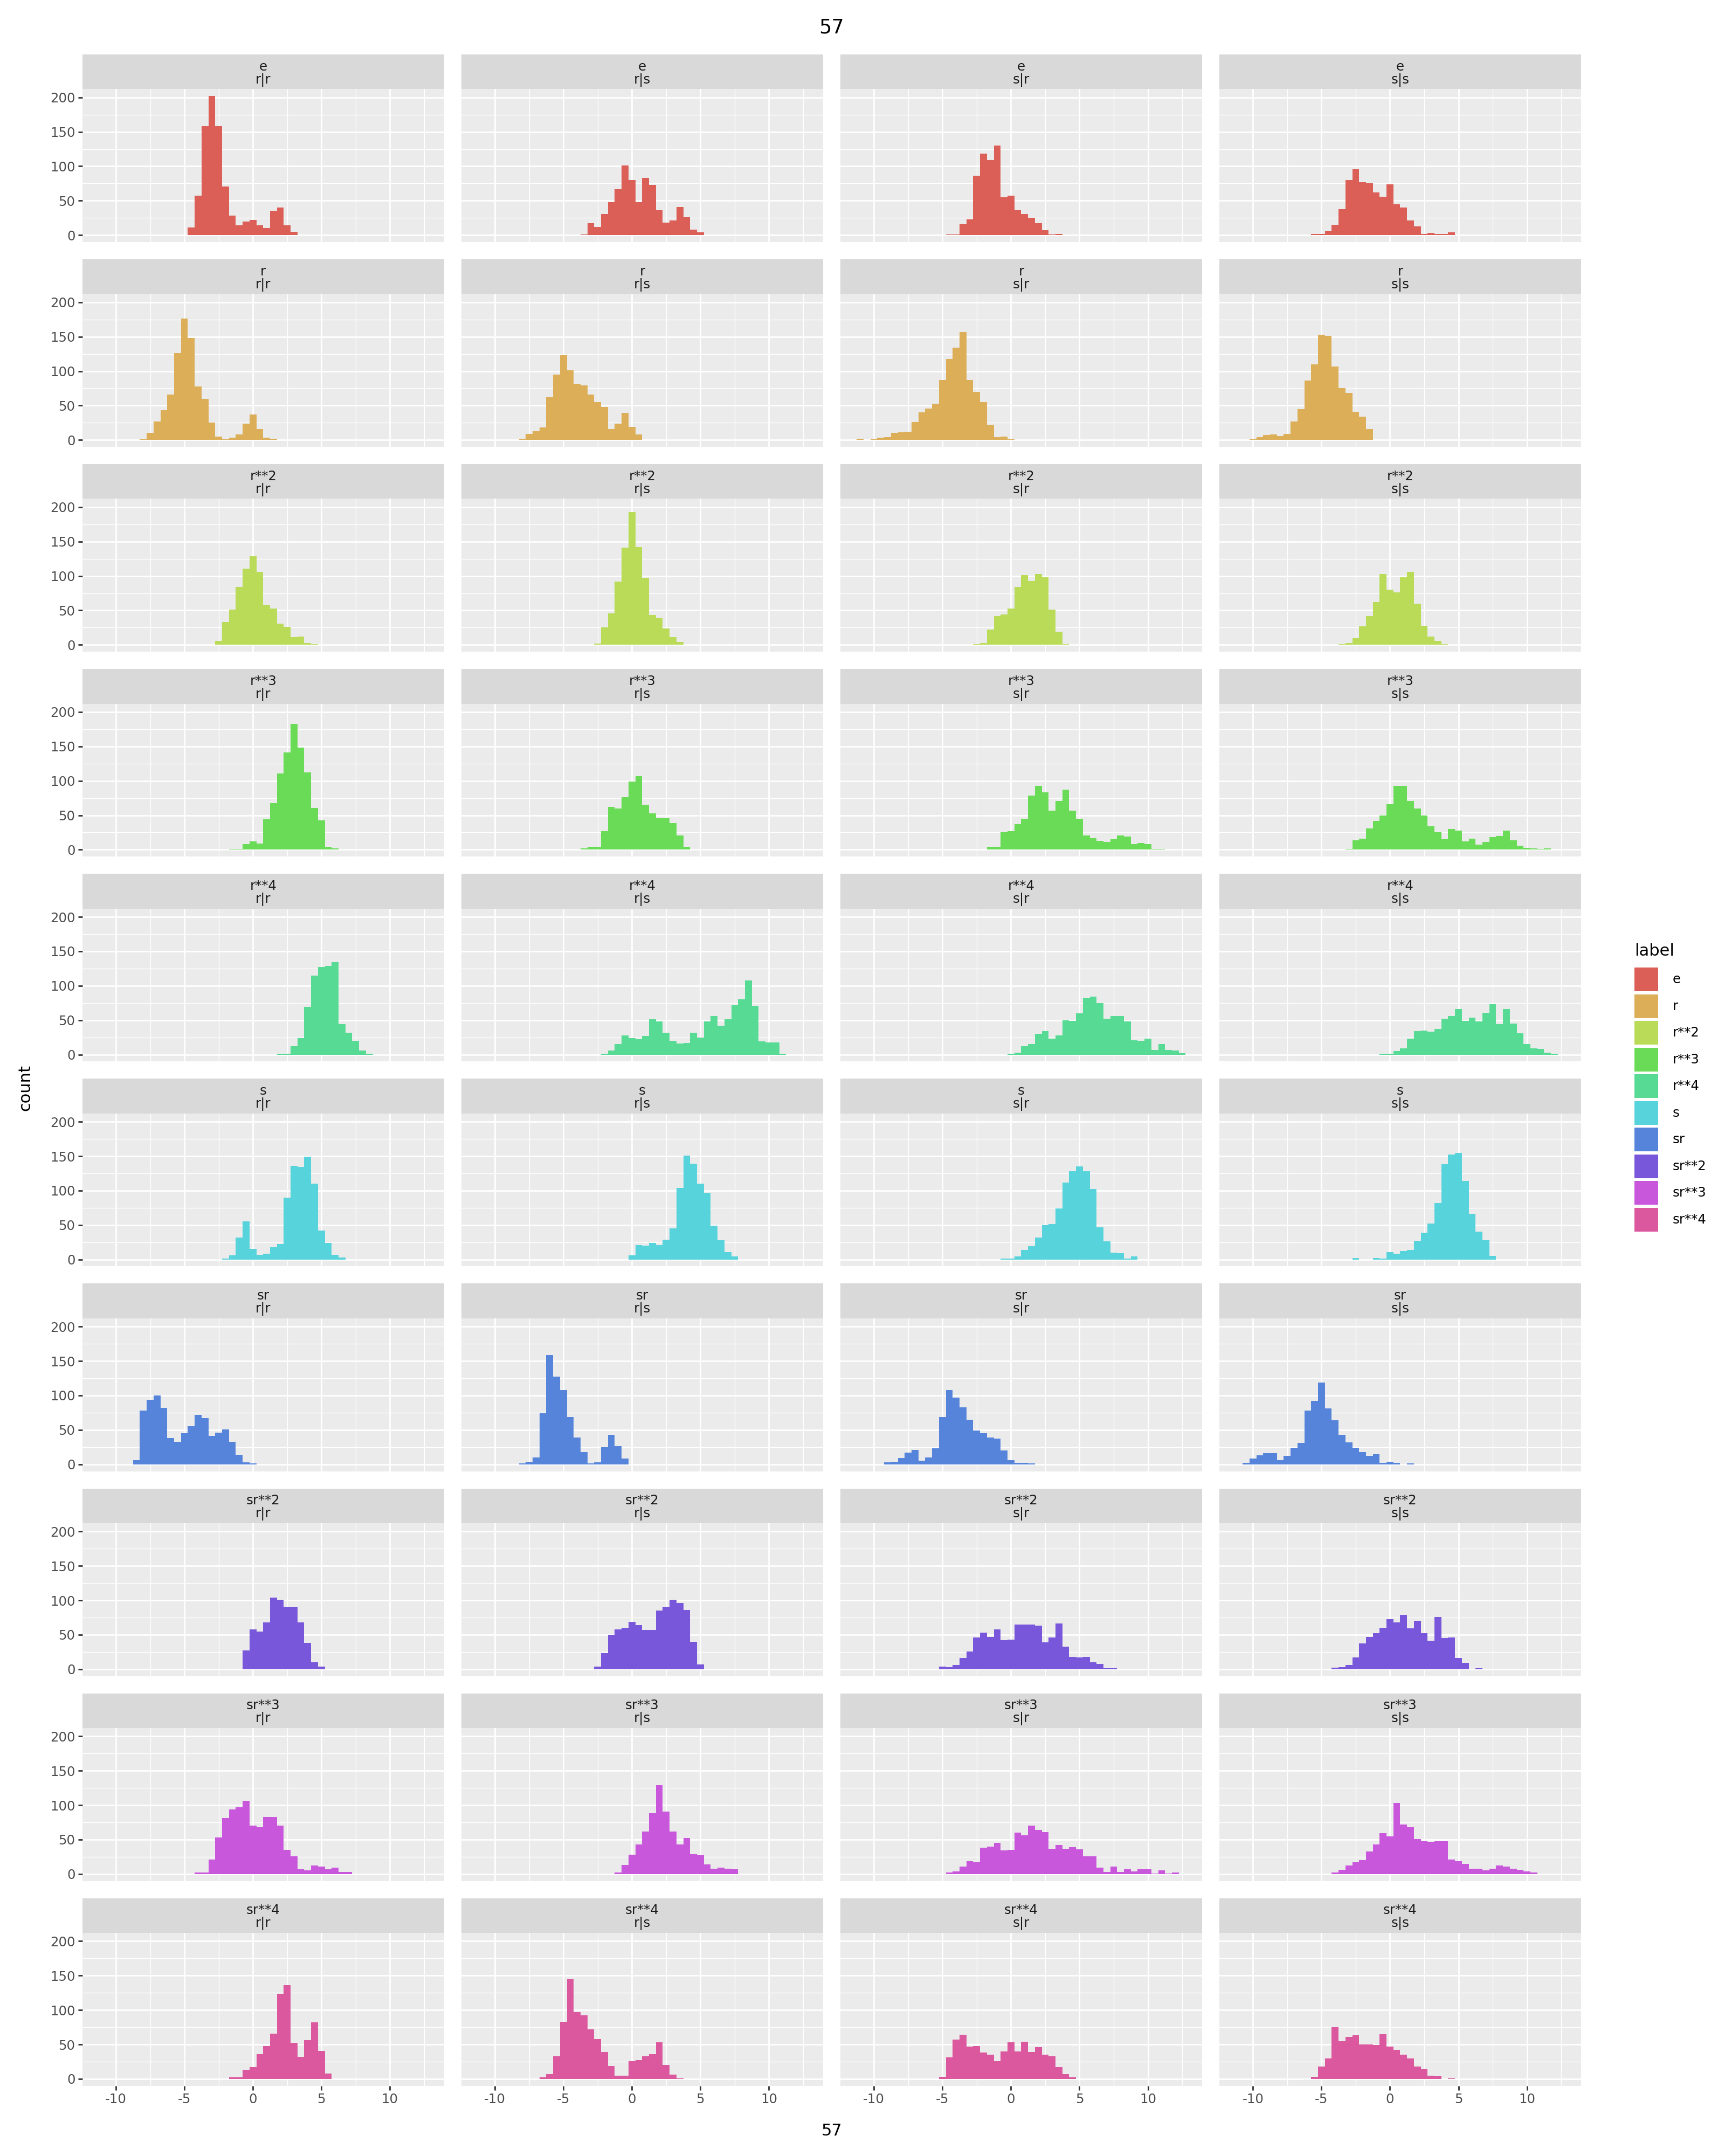

In [148]:
import random


randcol = str(random.randint(0, 255))


(
    ggplot(df, aes(x=randcol, fill='label')) 
    + geom_histogram(binwidth=0.5)
    + facet_wrap('~label+last_act', ncol=4) 
    + labs(title=f'{randcol}')
    + theme(figure_size=(16, 20))
)

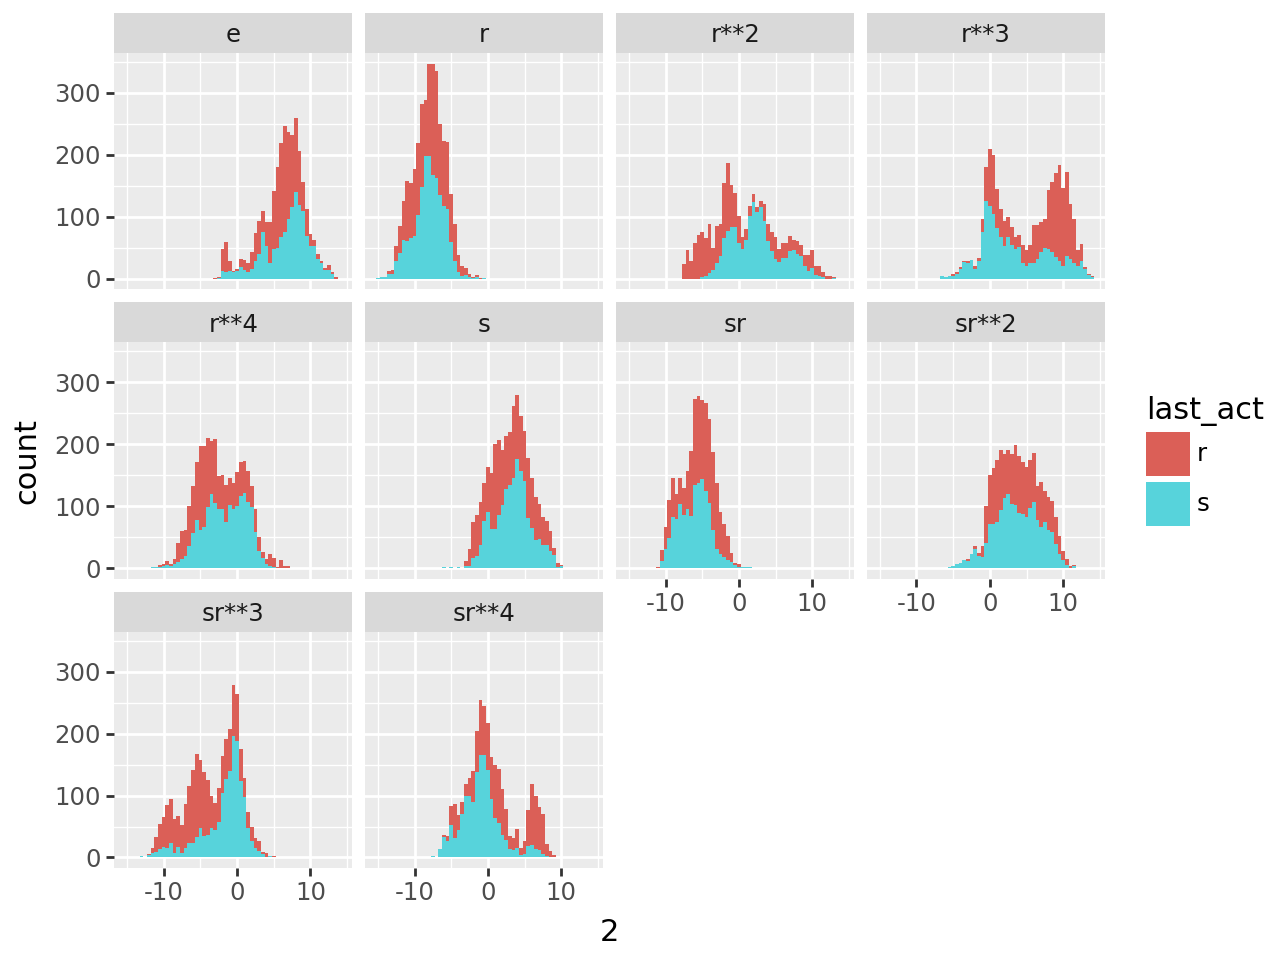

In [86]:
ggplot(df, aes(x='2', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

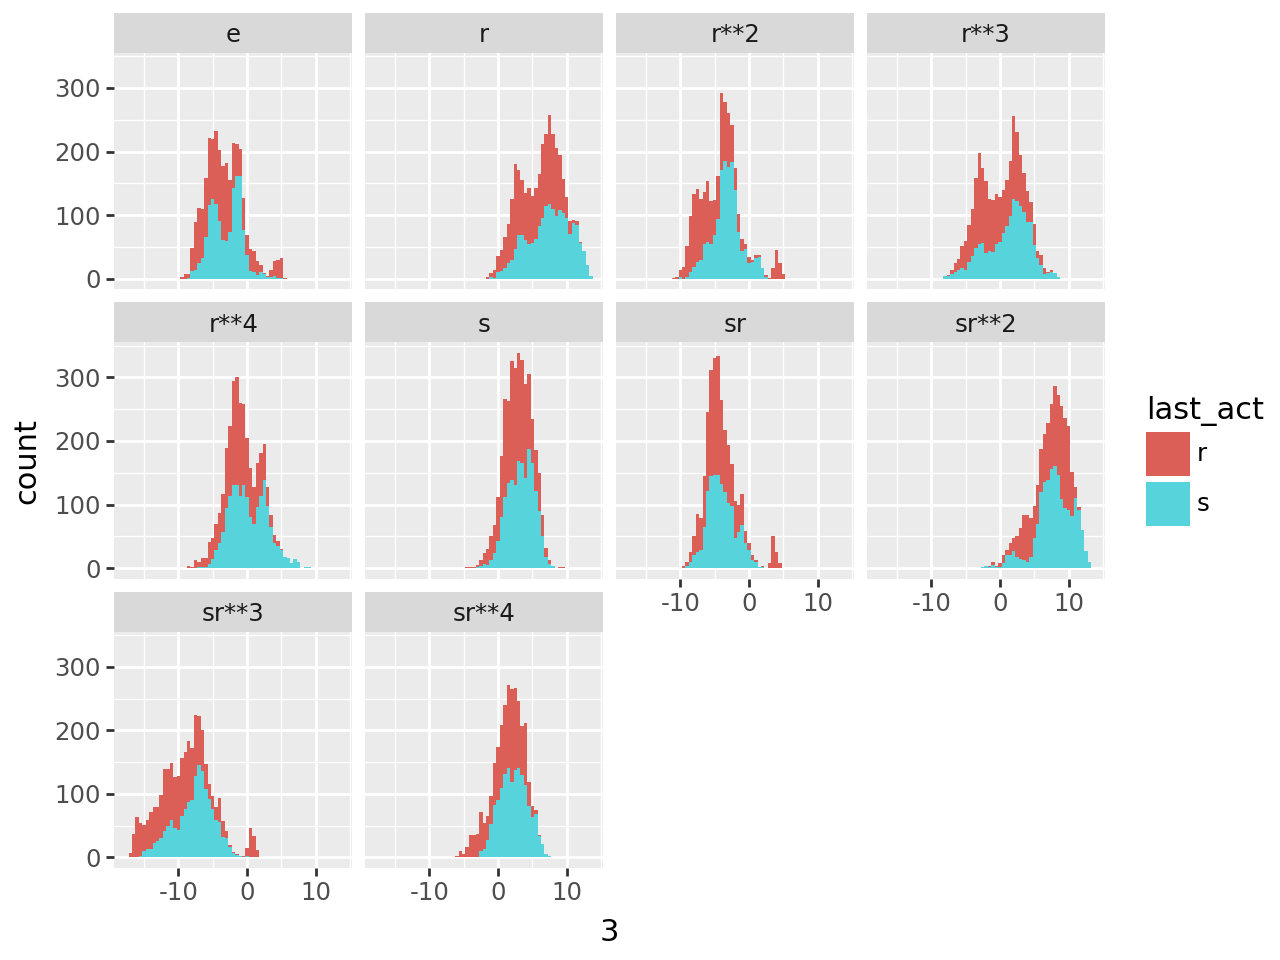

In [87]:
ggplot(df, aes(x='3', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

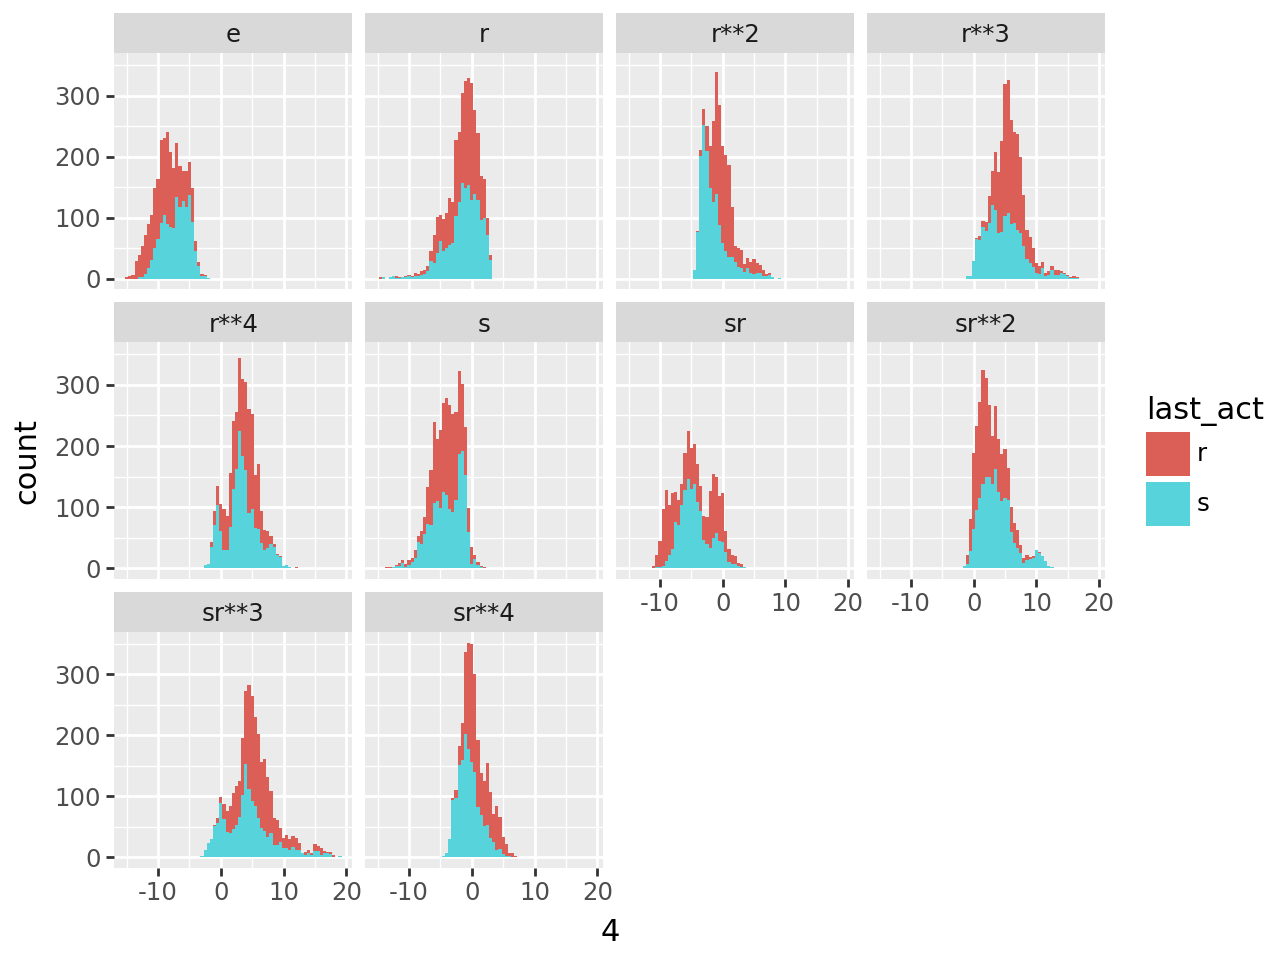

In [88]:
ggplot(df, aes(x='4', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

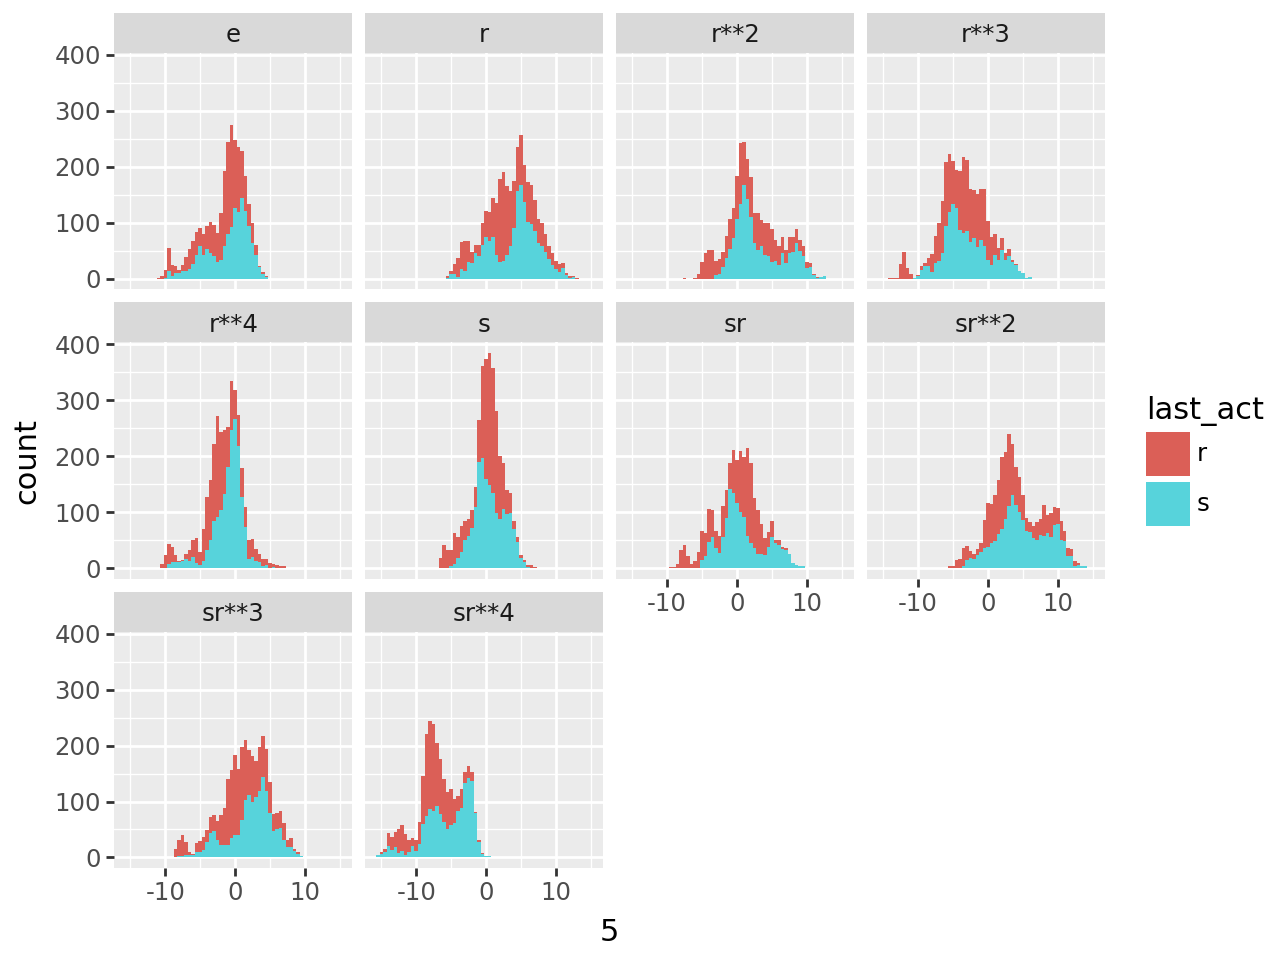

In [89]:
ggplot(df, aes(x='5', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

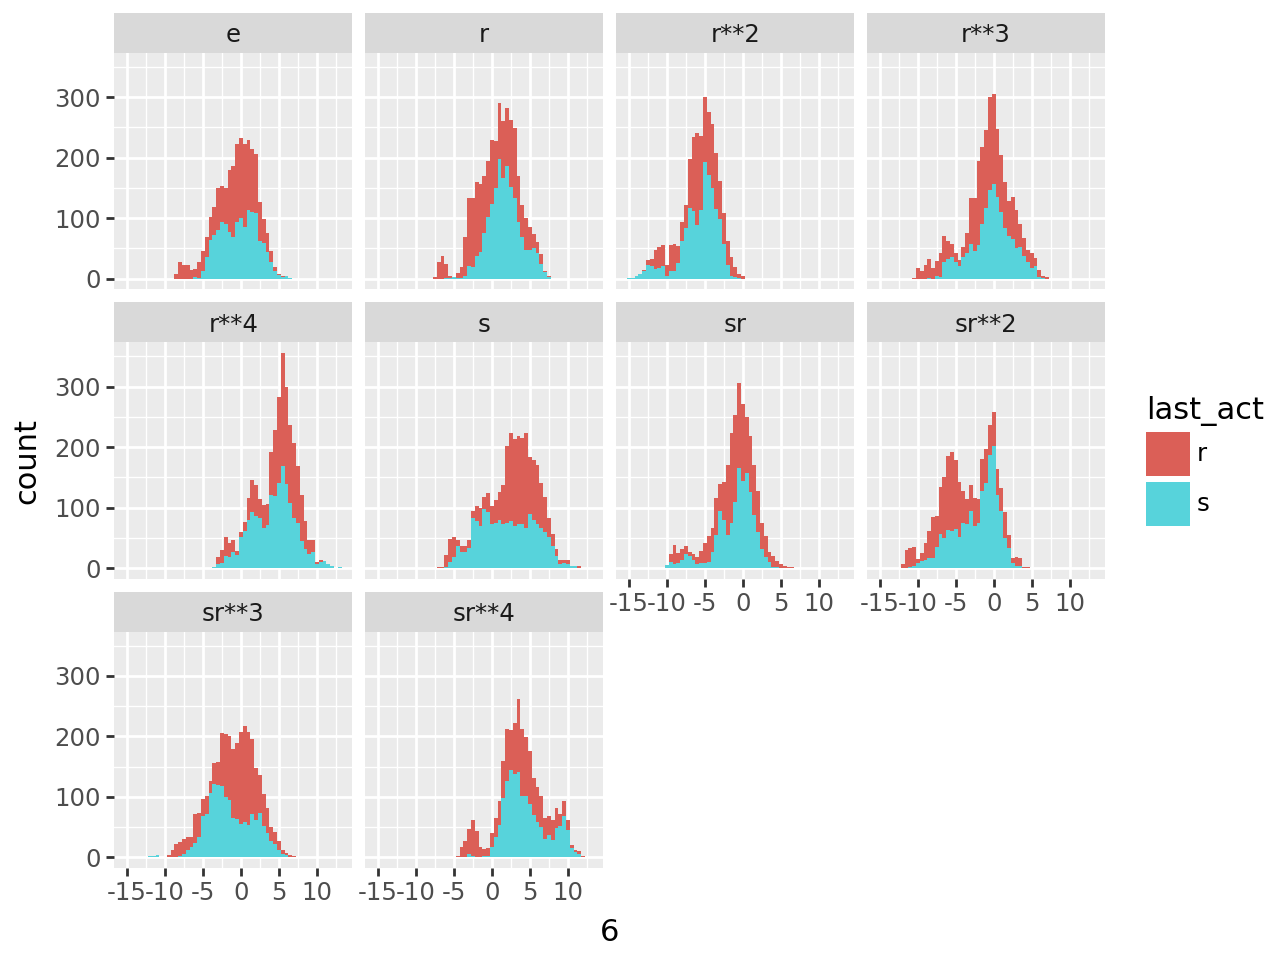

In [90]:
ggplot(df, aes(x='6', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

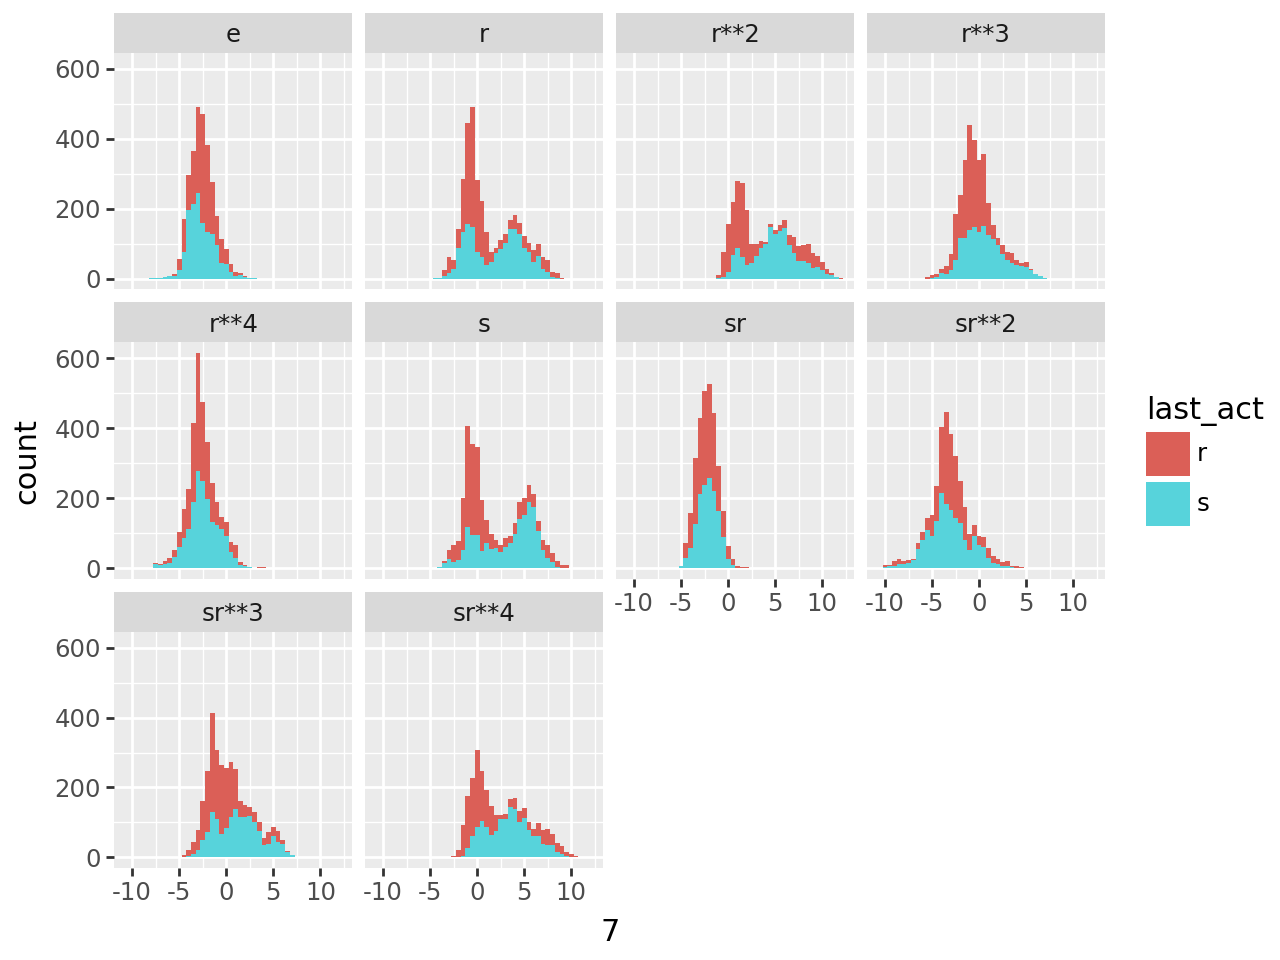

In [91]:
ggplot(df, aes(x='7', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

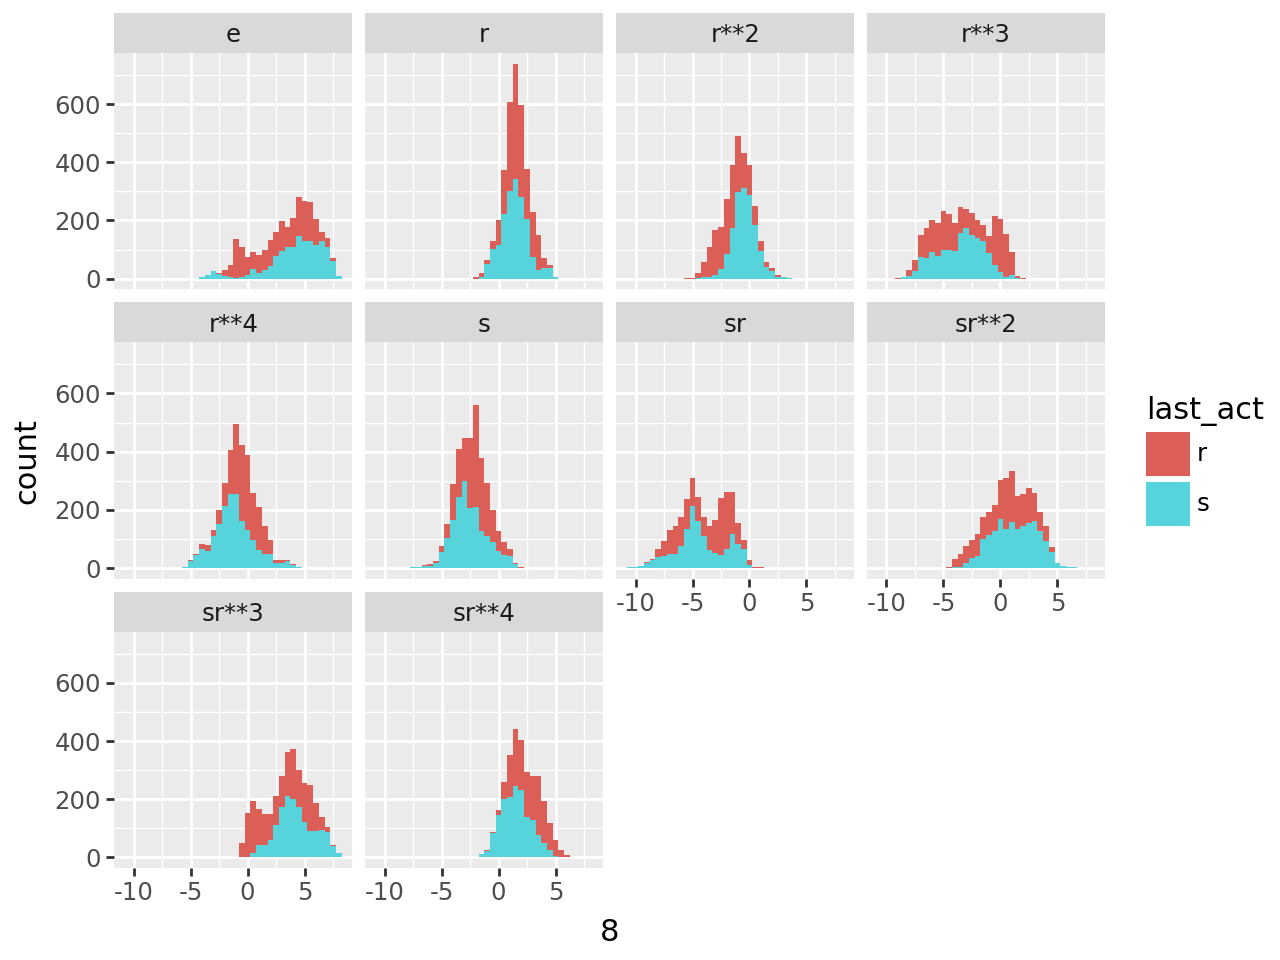

In [92]:
ggplot(df, aes(x='8', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~label')

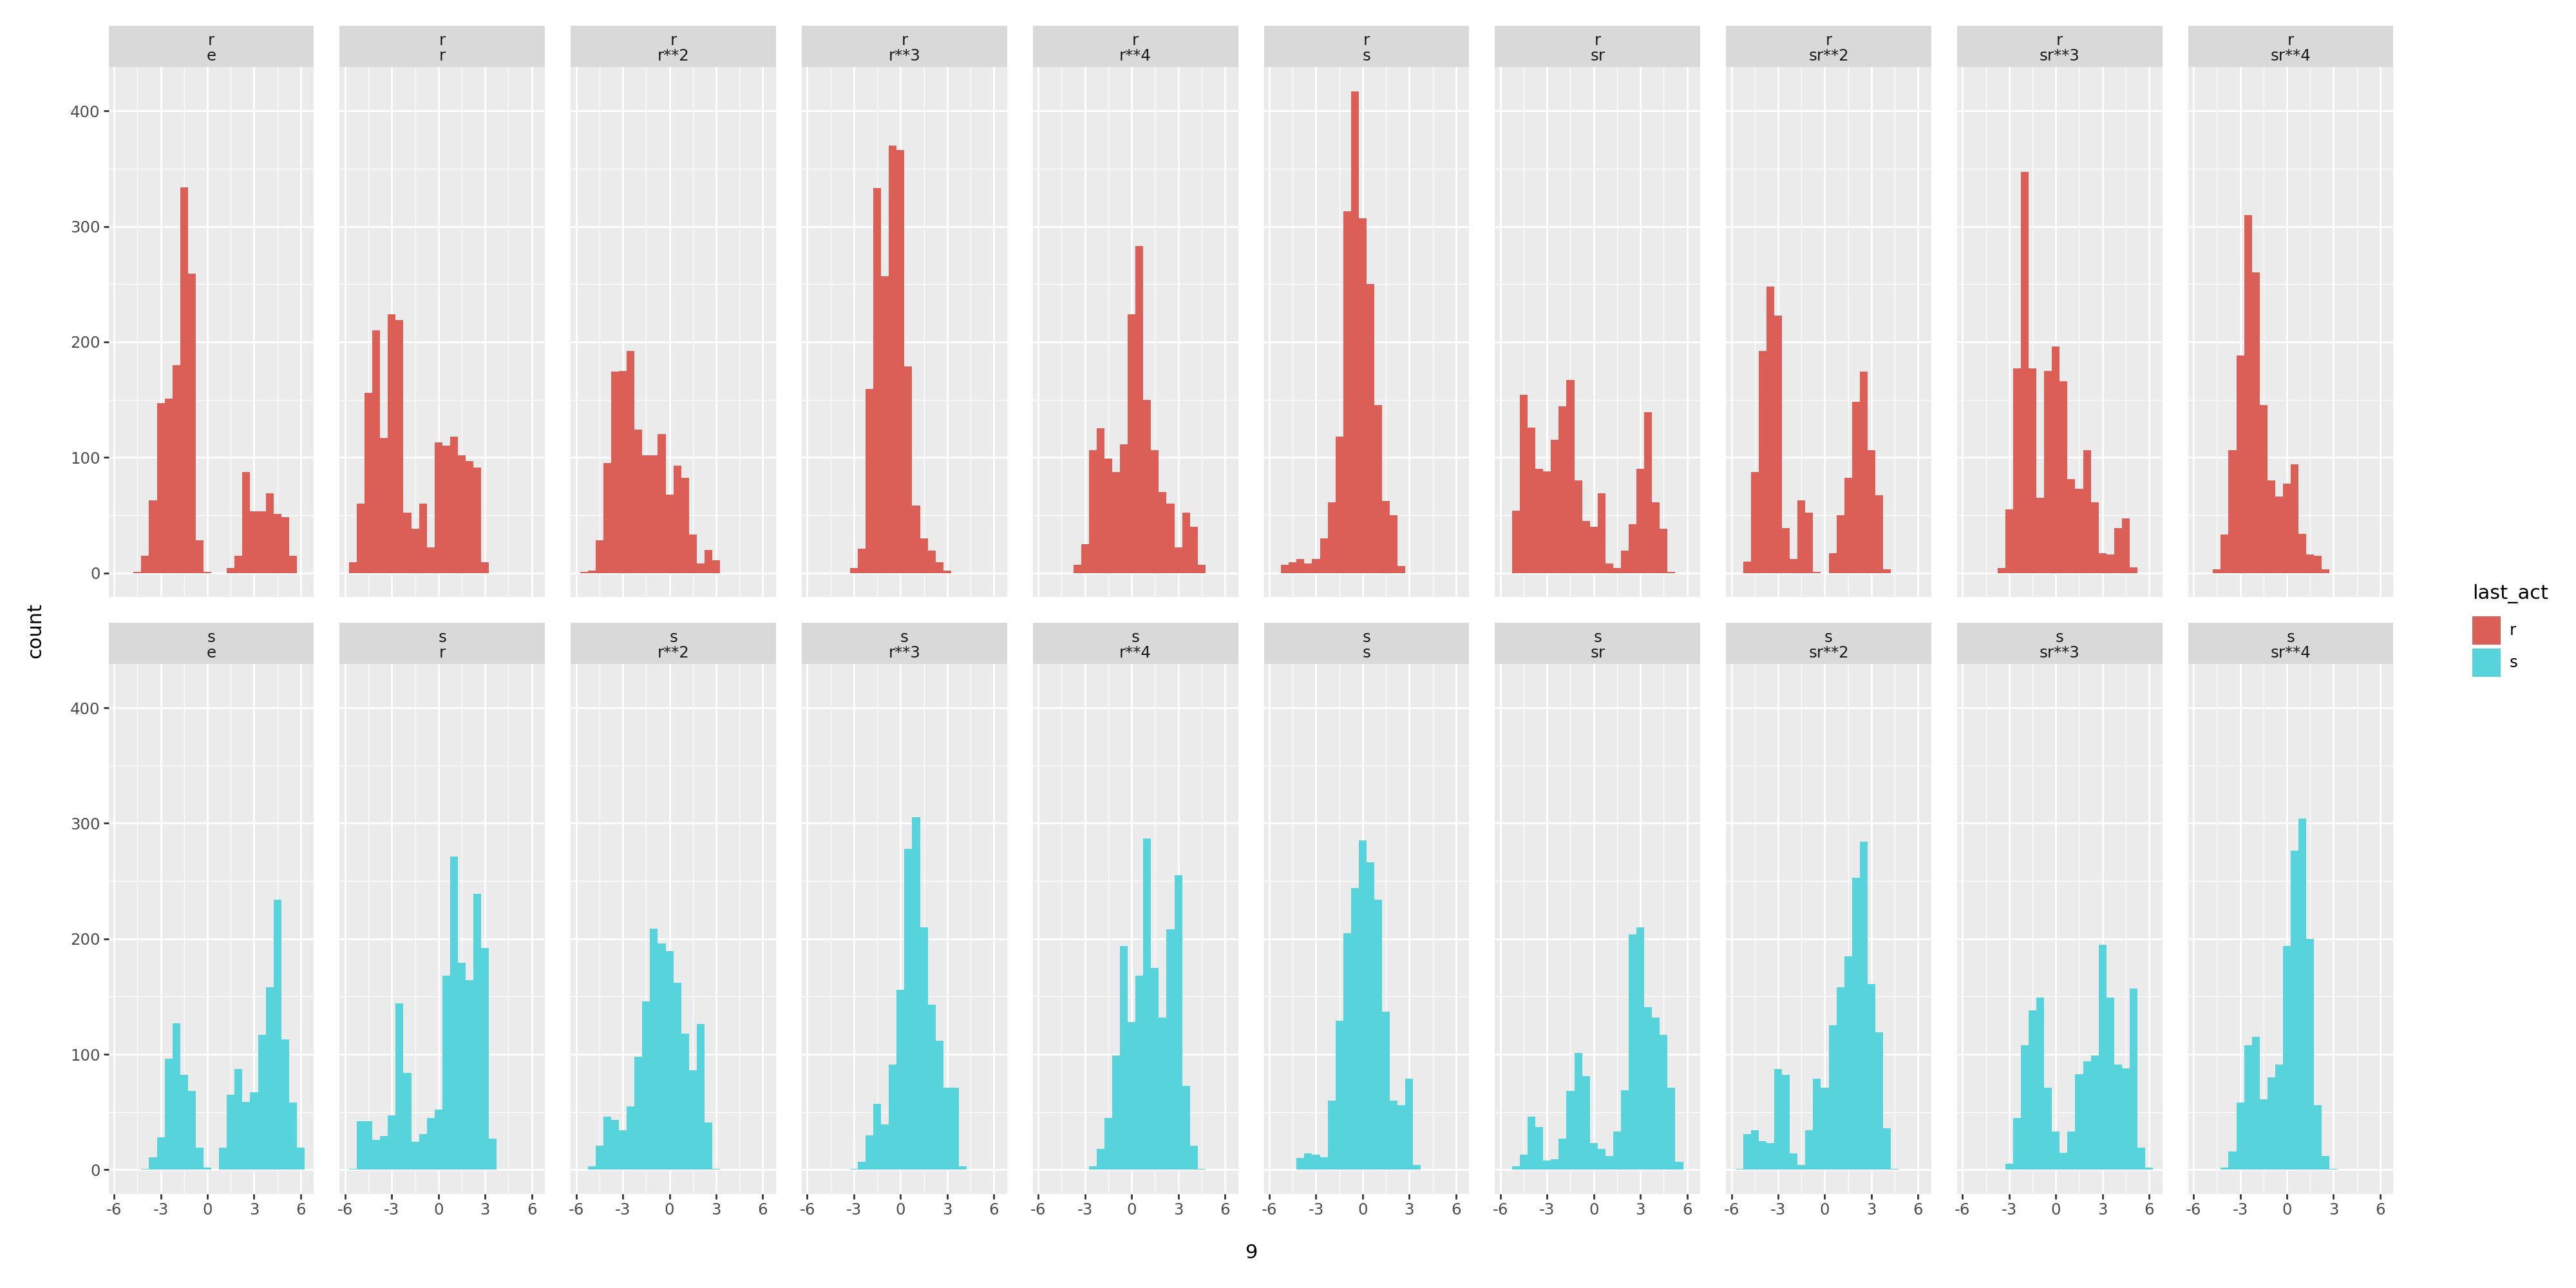

In [102]:
from plotnine import theme


ggplot(df, aes(x='9', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~last_act+label', nrow=2) + theme(figure_size = (20, 10))

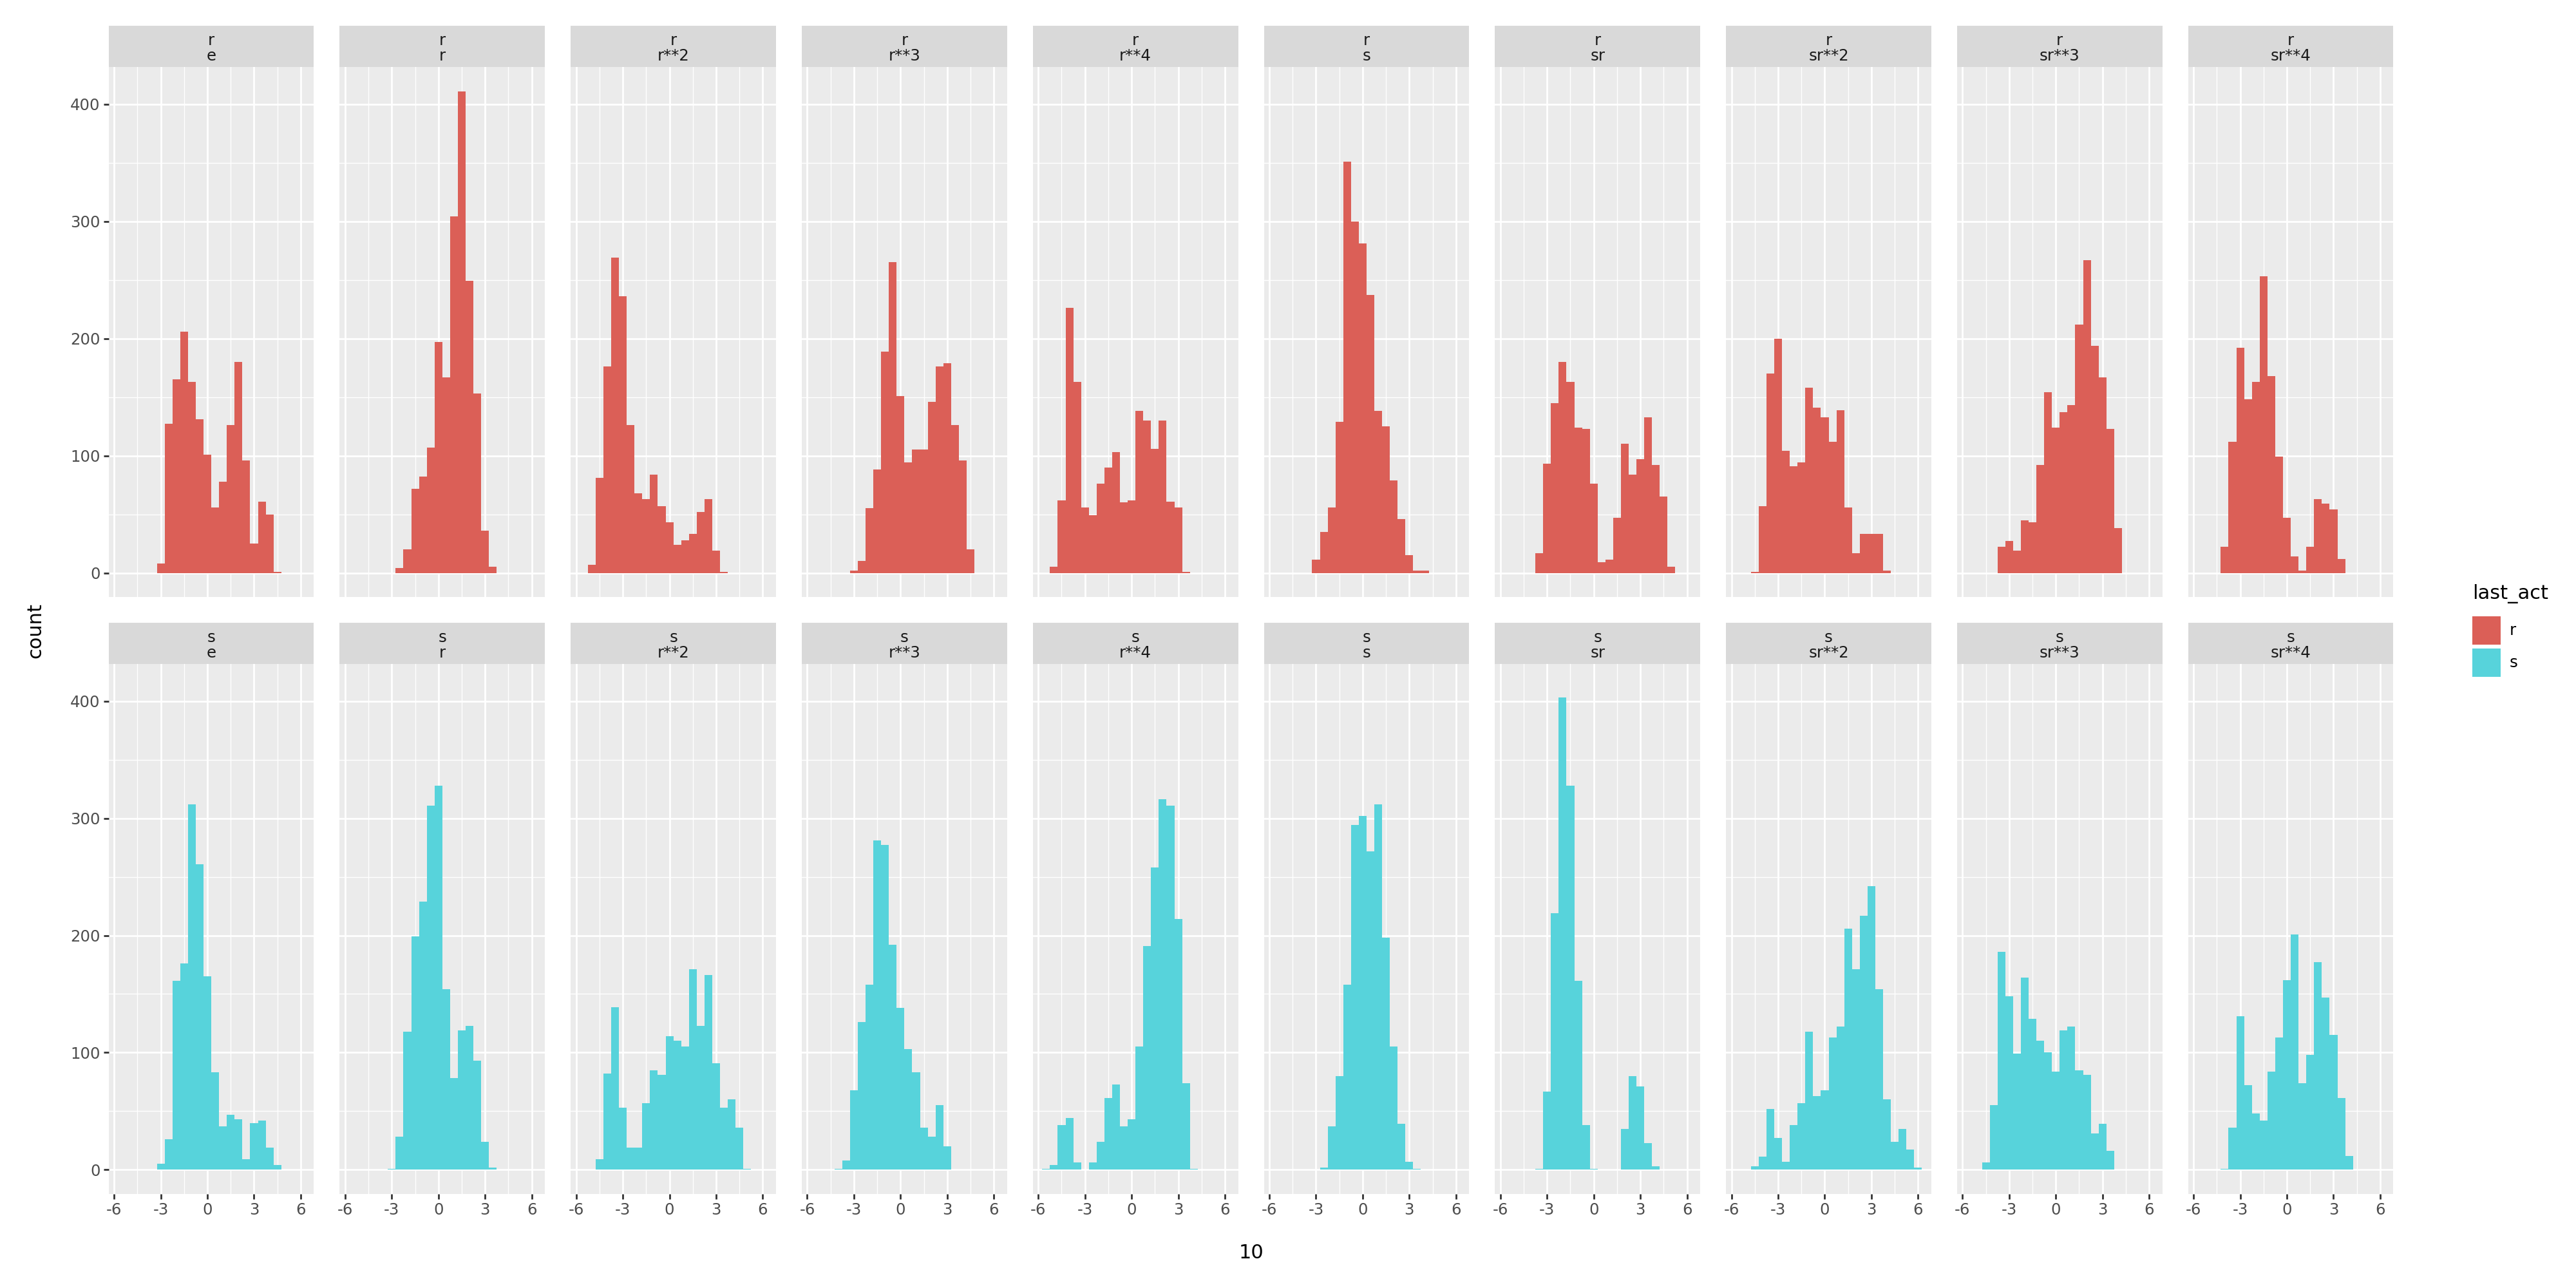

In [103]:
ggplot(df, aes(x='10', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~last_act+label', nrow=2) + theme(figure_size = (20, 10))

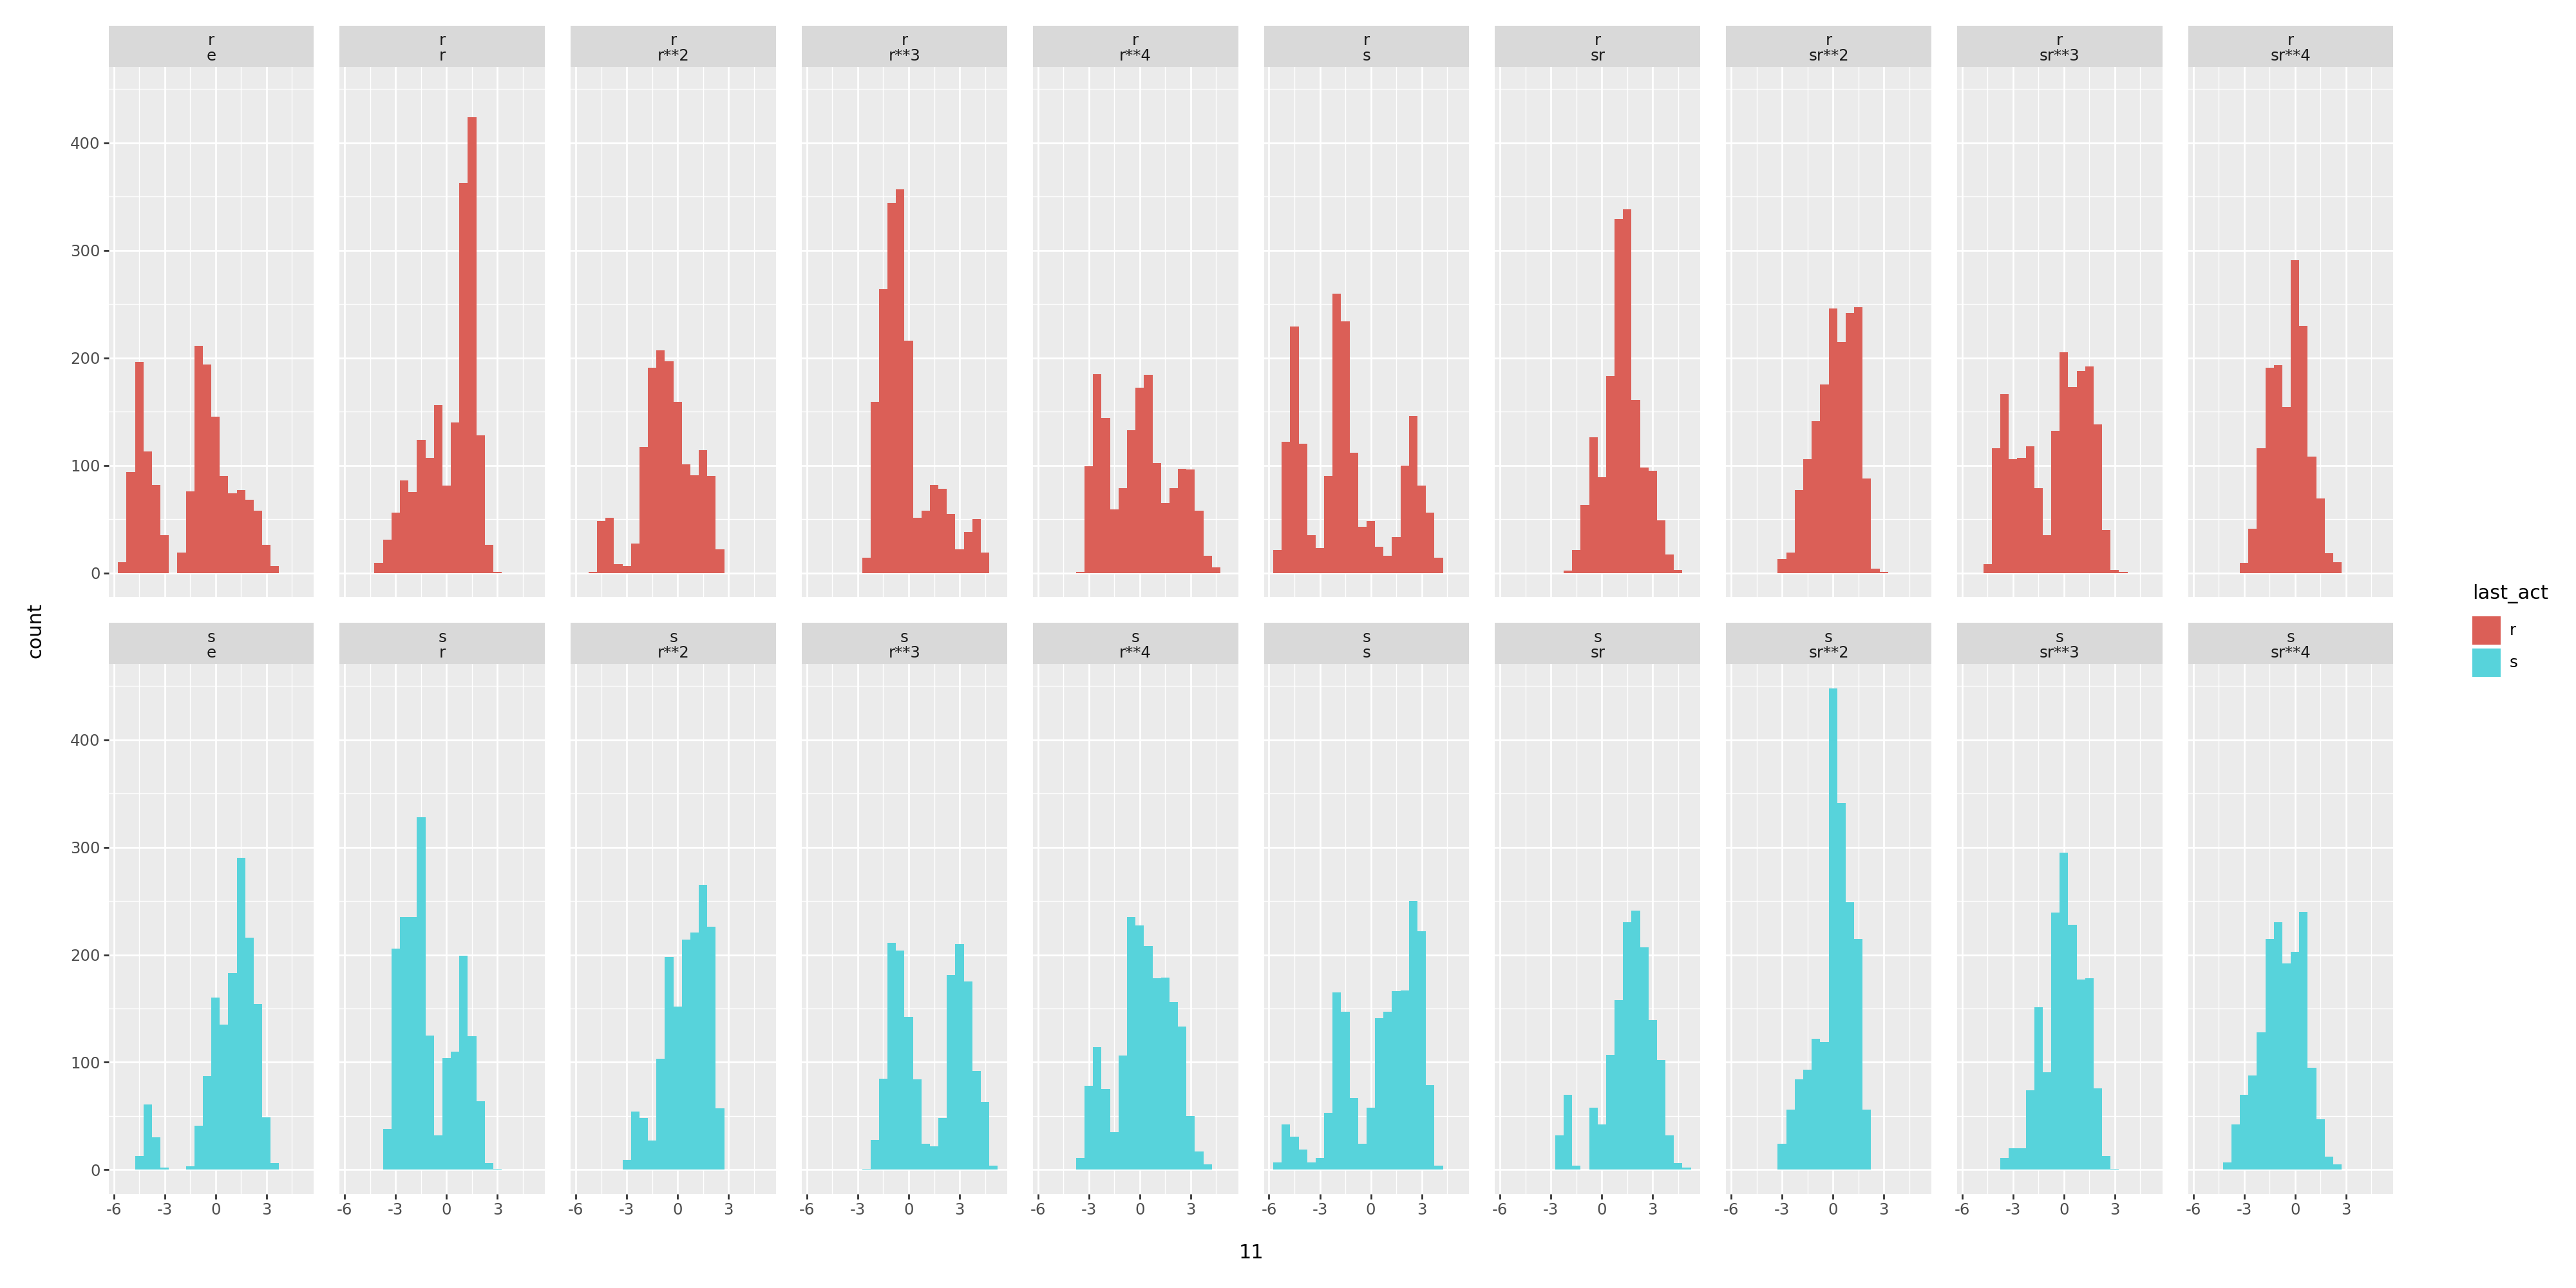

In [104]:
ggplot(df, aes(x='11', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~last_act+label', nrow=2) + theme(figure_size = (20, 10))

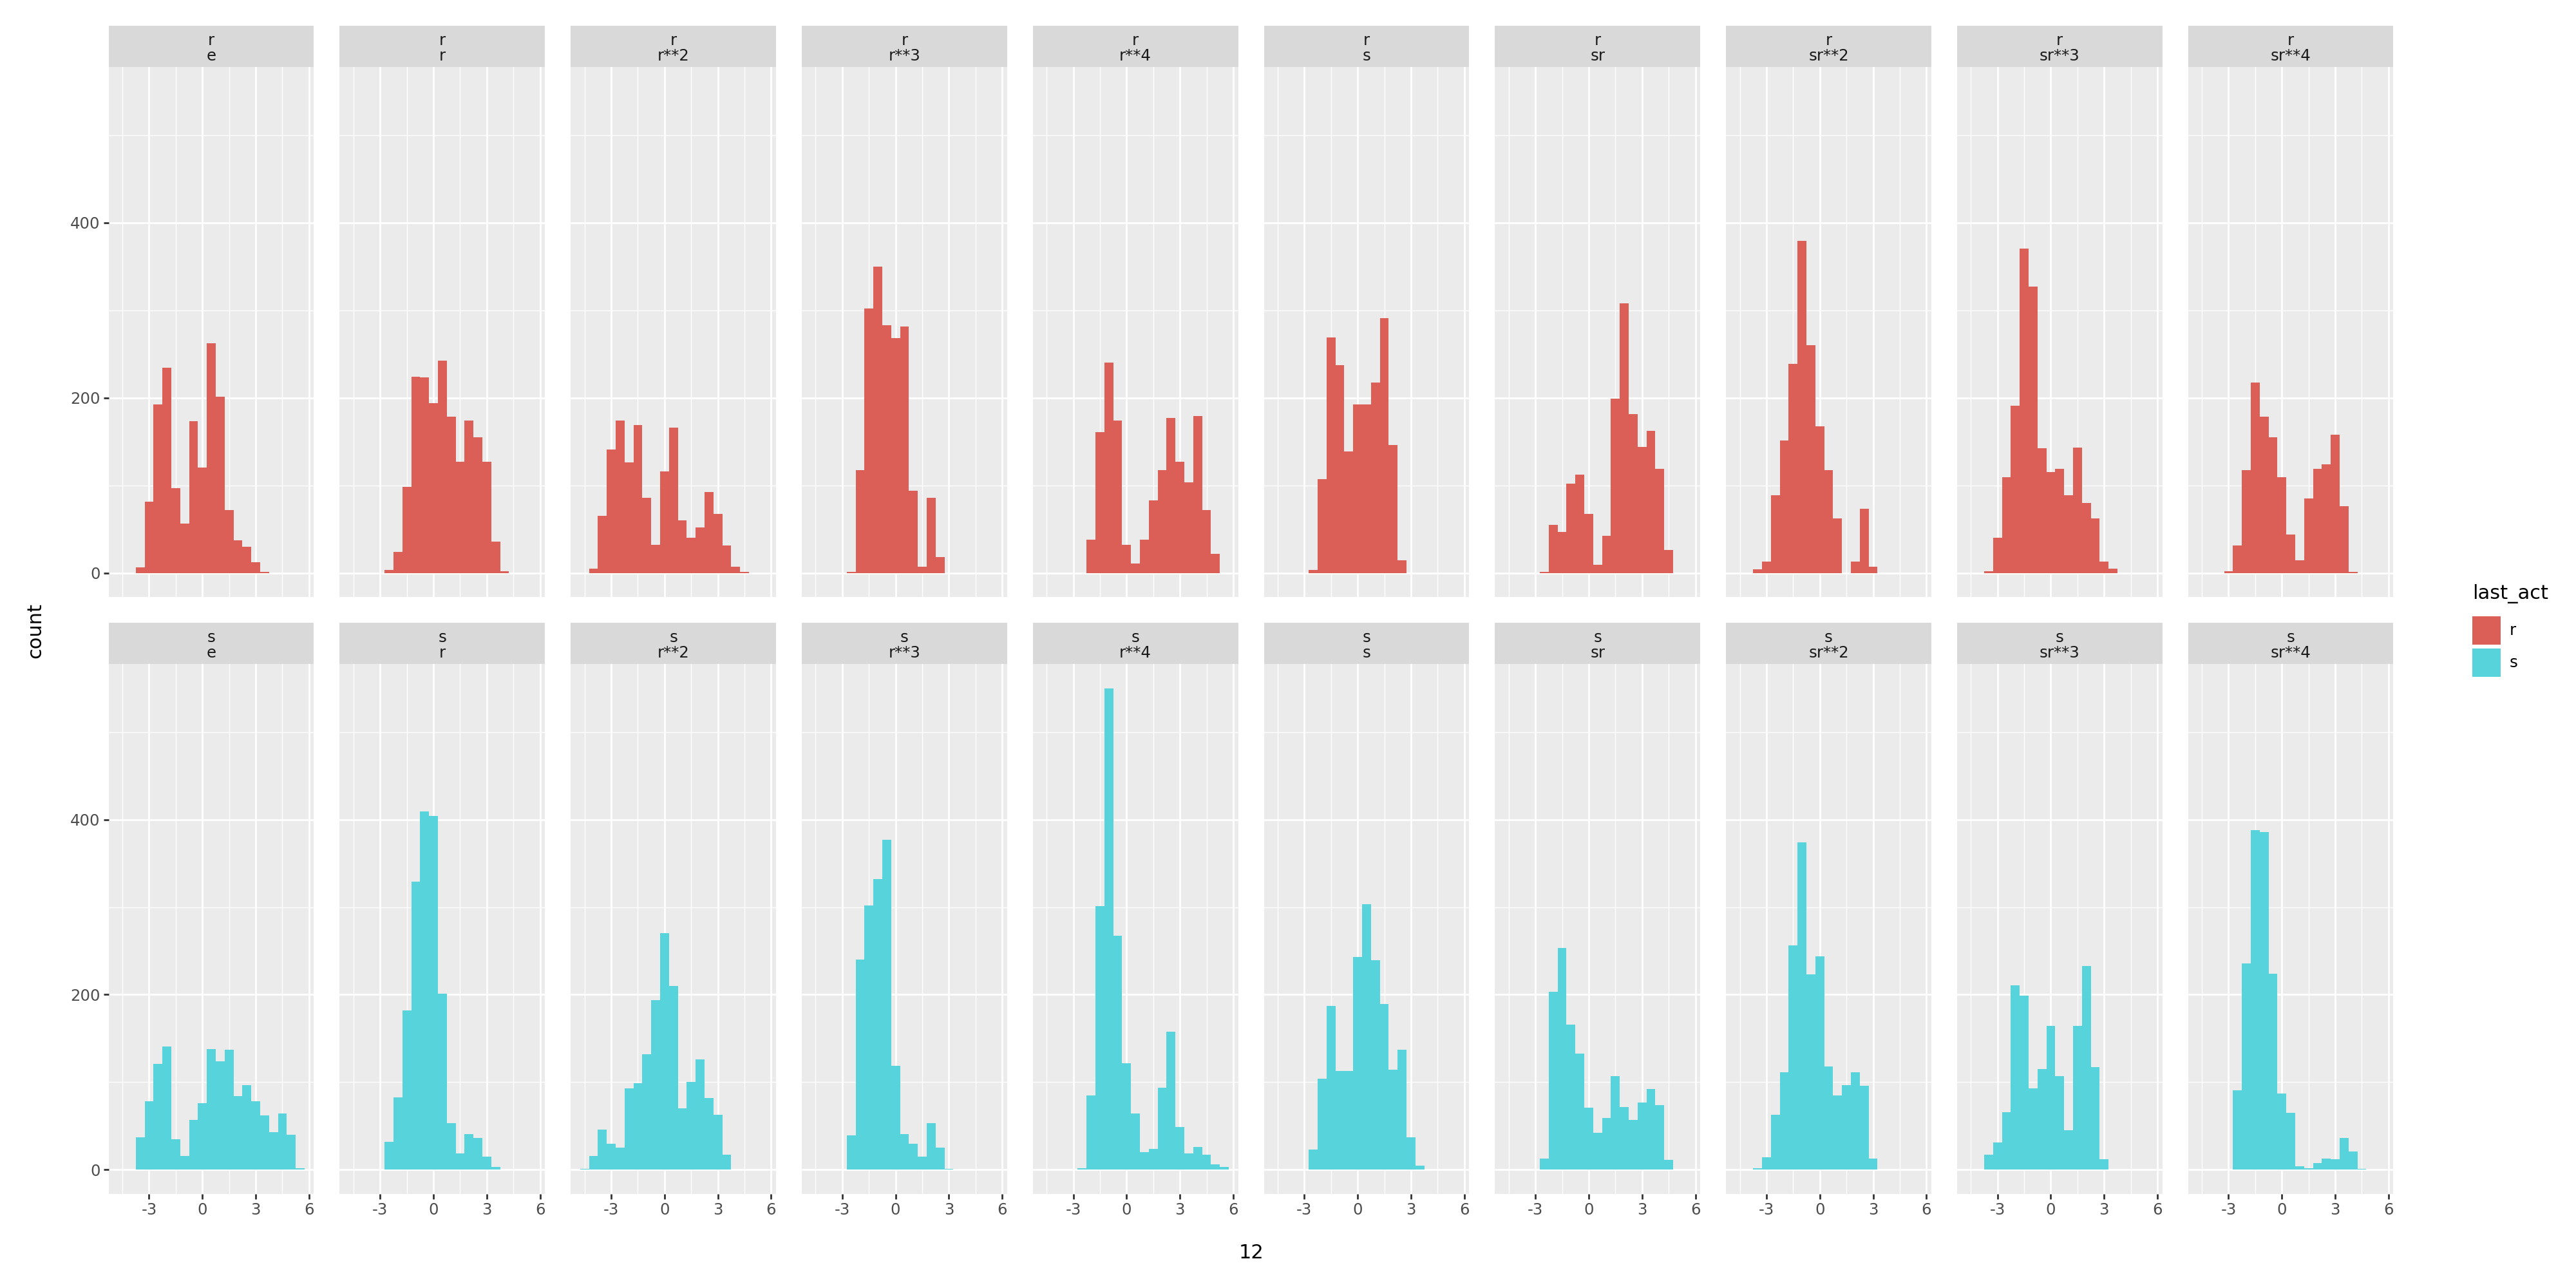

In [105]:
ggplot(df, aes(x='12', fill='last_act')) + geom_histogram(binwidth=0.5) + facet_wrap('~last_act+label', nrow=2) + theme(figure_size = (20, 10))

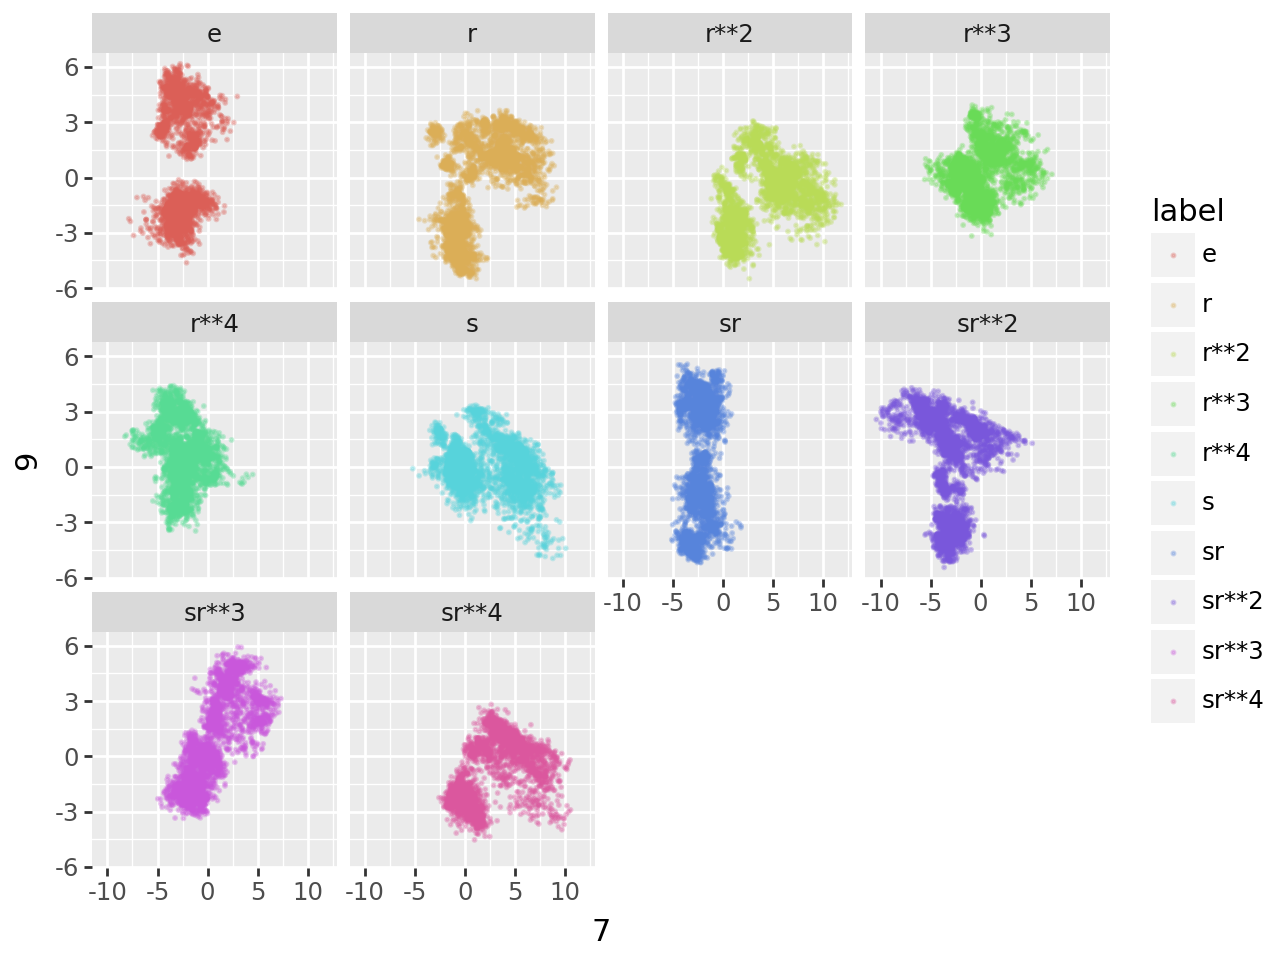

In [72]:
from plotnine import geom_point

ggplot(mlp2_df, aes(x='7', y='9', color='label')) + geom_point(alpha=0.3, size=0.2) + facet_wrap('~label')


In [75]:
from math import comb

comb(9, 2)

36

### Get logits for forms

In [ ]:
import pickle
from einops import rearrange

base_path = Path.cwd().parent
pca_path = base_path / Path(f"di_automata/ed_data/{run_name}_{time}/pca")
with open(pca_path, 'rb') as f:
    pca = torch.load(f)
pca_vectors = pca.components_

In [ ]:
def load_form(form_num: int):
    form_path = base_path / Path(f"di_automata/ed_data/{run_name}_{time}/forms/form_{cp_idxs[form_num]}")
    with open(form_path, 'rb') as f:
        form = pickle.load(f)
    form_logits = pca_vectors[0,:] * form[0] + pca_vectors[1,:] * form[1] + pca_vectors[2,:] * form[2]
    form_logits = rearrange(form_logits, '(n b c s) -> n b s c', n=config.rlct_config.ed_config.batches_per_checkpoint, b=config.dataloader_config.train_bs, c=config.tflens_config.d_vocab_out, s=config.task_config.length)
    return form_logits

Get forms.
Logits have shape 150 (number of evaluation batches) x 64 (batch size) x 25 (sequence length) x 10 (class number) = (2.4e6,).

In [ ]:
form_1_logits = torch.from_numpy(load_form(1))
form_2_logits = torch.from_numpy(load_form(2))
form_3_logits = torch.from_numpy(load_form(3))
form_4_logits = torch.from_numpy(load_form(4))

## Fourier transform of form logits

In [ ]:
def get_labels(form_logits):
    """Get labels for ed dataset used to create form logits."""
    ed_loader = create_dataloader_hf(config, deterministic=True)
    labels = [] # Stores all batches of labels
    for data in take_n(ed_loader, form_logits.shape[0]):
        labels.append(data["label_ids"])
    return torch.stack(labels)

In [ ]:
ed_labels = get_labels(form_1_logits)

In [ ]:
analyse_power(*get_fourier_spectrum(form_1_logits, ed_labels, form=True))

In [ ]:
analyse_power(*get_fourier_spectrum(form_2_logits, ed_labels, form=True))

In [ ]:
analyse_power(*get_fourier_spectrum(form_3_logits, ed_labels, form=True))

In [ ]:
analyse_power(*get_fourier_spectrum(form_4_logits, ed_labels, form=True))

These unfortunately aren't that informative - it may be that I need more PCA directions.

## Fourier transform of closest checkpoint logits


In [ ]:
# Pass data through
for data in take_n(eval_loader, 1):
    eval_inputs = data["input_ids"]
    eval_labels = data["label_ids"]
    break

logits_eval_1, cache_eval_1 = model_1.run_with_cache(eval_inputs)
logits_eval_2, cache_eval_2 = model_2.run_with_cache(eval_inputs)
logits_eval_3, cache_eval_3 = model_3.run_with_cache(eval_inputs)
logits_eval_4, cache_eval_4 = model_4.run_with_cache(eval_inputs)
logits_eval_5, cache_eval_5 = model_5.run_with_cache(eval_inputs)

In [ ]:
logits_eval_1.shape

In [ ]:
# Where labela are class 0
mask = eval_labels == 0
mean_vals_1 = logits_eval_1.mean(dim=(0,1))
mean_vals_1 = mean_vals_1[torch.tensor([0, 5, 1, 6, 2, 7, 3, 8, 4, 9])]

Split up Fourier transform by even or odd label. In reality to fully carve this up we should have a grid where rows correspond to labels and columns to predicions. This is also done below.

In [ ]:
values = torch.tensor([0., 1., 2., 3., 4.], dtype=torch.float32)
even_mask = torch.zeros(eval_labels.size(), dtype=torch.bool)
for value in values:
    even_mask = even_mask | (eval_labels == value)

transform_all = dihedral_fourier(mean_vals_1.to('cpu').unsqueeze(1), 5)
transform_all

even_mean_1 = logits_eval_1[even_mask].mean(dim=0)
even_transform = dihedral_fourier(even_mean_1.to('cpu').unsqueeze(1), 5)
even_transform
# even_mean_1 -= mean_vals_1

odd_mean_1 = logits_eval_1[~even_mask].mean(dim=(0))
odd_transform = dihedral_fourier(odd_mean_1.to('cpu').unsqueeze(1), 5)
odd_transform

In [ ]:
transforms_1, means_1 = get_fourier_spectrum(logits_eval_1, eval_labels)

In [ ]:
analyse_power(transforms_1, means_1)

In [ ]:
transforms_2, means_2 = get_fourier_spectrum(logits_eval_2, eval_labels)

In [ ]:
analyse_power(transforms_2, means_2)

In [ ]:
analyse_power(*get_fourier_spectrum(logits_eval_3, eval_labels))

In [ ]:
analyse_power(*get_fourier_spectrum(logits_eval_4, eval_labels))

In [ ]:
analyse_power(*get_fourier_spectrum(logits_eval_5, eval_labels))

These logit results don't quite make sense - the zero power on the parity (0,1) mode for all checkpoints doesn't check out with its ability to learn the parity feature.

# Trial inputs

In [ ]:
all1 = torch.ones((25), dtype=torch.int32)
all0 = torch.zeros((25), dtype=torch.int32)
all1_label = (torch.cumsum(all1, dim=0)) % 5
all0_label = torch.tensor([5,0]*12+[5], dtype=torch.int32)
print(all1_label)
print(all0_label)

# All zeros except a single one at one position
all_zero_except1 = deepcopy(all0)
all_zero_except1[8] = 1
all_zero_except1_label = actions_to_labels(all_zero_except1, translation, dtype="int")
print(all_zero_except1_label)


# All ones except a single zero at one position
all_one_except1 = deepcopy(all1)
all_one_except1[8] = 0
all_one_except1_label = actions_to_labels(all_one_except1, translation, dtype="int",)
print(all_one_except1_label)

### Early in training

In [ ]:
l_all1_0, cache_all1_0 = model_0.run_with_cache(all1)
l_all0_0, cache_all0_0 = model_0.run_with_cache(all0)
pred_all1_0 = torch.argmax(l_all1_0, dim=-1).squeeze().cpu()
pred_all0_0 = torch.argmax(l_all0_0, dim=-1).squeeze().cpu()
print(pred_all0_0.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_0)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_0)

l_all_zero_except1_0, c_zero_except1_0 = model_0.run_with_cache(all_zero_except1)
l_all_one_except1_0 , c_all_one_except1_0 = model_0.run_with_cache(all_one_except1)
pred_all_zero_except1_0 = torch.argmax(l_all_zero_except1_0, dim=-1).squeeze().cpu()
pred_all_one_except1_0 = torch.argmax(l_all_one_except1_0, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_0)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_0)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_0, all0_label, pred_all0_0, all_zero_except1_label, pred_all_zero_except1_0, all_one_except1_label, pred_all_one_except1_0])
plot_tensor_heatmap(tensor_matrix)

### Form 1

In [ ]:
l_all1_1, cache_all1_1 = model_1.run_with_cache(all1)
l_all0_1, cache_all0_1 = model_1.run_with_cache(all0)
pred_all1_1 = torch.argmax(l_all1_1, dim=-1).squeeze().cpu()
pred_all0_1 = torch.argmax(l_all0_1, dim=-1).squeeze().cpu()
print(pred_all0_1.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_1)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_1)

l_all_zero_except1_1, c_zero_except1_1 = model_1.run_with_cache(all_zero_except1)
l_all_one_except1_1 , c_all_one_except1_1 = model_1.run_with_cache(all_one_except1)
pred_all_zero_except1_1 = torch.argmax(l_all_zero_except1_1, dim=-1).squeeze().cpu()
pred_all_one_except1_1 = torch.argmax(l_all_one_except1_1, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_1)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_1)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_1, all0_label, pred_all0_1, all_zero_except1_label, pred_all_zero_except1_1, all_one_except1_label, pred_all_one_except1_1])
plot_tensor_heatmap(tensor_matrix)

### Form 2

In [ ]:
l_all1_2, cache_all1_2 = model_2.run_with_cache(all1)
l_all0_2, cache_all0_2 = model_2.run_with_cache(all0)
pred_all1_2 = torch.argmax(l_all1_2, dim=-1).squeeze().cpu()
pred_all0_2 = torch.argmax(l_all0_2, dim=-1).squeeze().cpu()
print(pred_all0_2.shape)
print("all one labels", all1_label)
print("predicted all ones", pred_all1_2)
print("all zero labels", all0_label)
print("predicted all zeros", pred_all0_2)

l_all_zero_except1_2, c_zero_except1_2 = model_2.run_with_cache(all_zero_except1)
l_all_one_except1_2 , c_all_one_except1_2 = model_2.run_with_cache(all_one_except1)
pred_all_zero_except1_2 = torch.argmax(l_all_zero_except1_2, dim=-1).squeeze().cpu()
pred_all_one_except1_2 = torch.argmax(l_all_one_except1_2, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_2)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_2)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_2, all0_label, pred_all0_2, all_zero_except1_label, pred_all_zero_except1_2, all_one_except1_label, pred_all_one_except1_2])
plot_tensor_heatmap(tensor_matrix)

### Form 3

In [ ]:
l_all1_3, cache_all1_3 = model_3.run_with_cache(all1)
l_all0_3, cache_all0_3 = model_3.run_with_cache(all0)
pred_all1_3 = torch.argmax(l_all1_3, dim=-1).squeeze().cpu()
pred_all0_3 = torch.argmax(l_all0_3, dim=-1).squeeze().cpu()
print(pred_all0_3.shape)
print("all one labels", all1_label)
print("predicted all 1s", pred_all1_3)
print("all zero labels", all0_label)
print("predicted all 0s", pred_all0_3)

l_all_zero_except1_3, c_zero_except1_3 = model_3.run_with_cache(all_zero_except1)
l_all_one_except1_3 , c_all_one_except1_3 = model_3.run_with_cache(all_one_except1)
pred_all_zero_except1_3 = torch.argmax(l_all_zero_except1_3, dim=-1).squeeze().cpu()
pred_all_one_except1_3 = torch.argmax(l_all_one_except1_3, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_3)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_3)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_3, all0_label, pred_all0_3, all_zero_except1_label, pred_all_zero_except1_3, all_one_except1_label, pred_all_one_except1_3])
plot_tensor_heatmap(tensor_matrix)

### Form 4

In [ ]:
l_all1_4, cache_all1_4 = model_4.run_with_cache(all1)
l_all0_4, cache_all0_4 = model_4.run_with_cache(all0)
pred_all1_4 = torch.argmax(l_all1_4, dim=-1).squeeze().cpu()
pred_all0_4 = torch.argmax(l_all0_4, dim=-1).squeeze().cpu()
print(pred_all0_4.shape)
print("all one labels", all1_label)
print("predicted all 1s", pred_all1_4)
print("all zero labels", all0_label)
print("predicted all 0s", pred_all0_4)

l_all_zero_except1_4, c_zero_except1_4 = model_4.run_with_cache(all_zero_except1)
l_all_one_except1_4 , c_all_one_except1_4 = model_4.run_with_cache(all_one_except1)
pred_all_zero_except1_4 = torch.argmax(l_all_zero_except1_4, dim=-1).squeeze().cpu()
pred_all_one_except1_4 = torch.argmax(l_all_one_except1_4, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_4)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_4)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_4, all0_label, pred_all0_4, all_zero_except1_label, pred_all_zero_except1_4, all_one_except1_label, pred_all_one_except1_4])
plot_tensor_heatmap(tensor_matrix)

### End of training

In [ ]:
l_all1_5, cache_all1_5 = model_5.run_with_cache(all1)
l_all0_5, cache_all0_5 = model_5.run_with_cache(all0)
pred_all1_5 = torch.argmax(l_all1_5, dim=-1).squeeze().cpu()
pred_all0_5 = torch.argmax(l_all0_5, dim=-1).squeeze().cpu()
print(pred_all0_5.shape)
print("all one labels", all1_label)
print("predicted all 1s", pred_all1_5)
print("all zero labels", all0_label)
print("predicted all 0s", pred_all0_5)

l_all_zero_except1_5, c_zero_except1_5 = model_5.run_with_cache(all_zero_except1)
l_all_one_except1_5 , c_all_one_except1_5 = model_5.run_with_cache(all_one_except1)
pred_all_zero_except1_5 = torch.argmax(l_all_zero_except1_5, dim=-1).squeeze().cpu()
pred_all_one_except1_5 = torch.argmax(l_all_one_except1_5, dim=-1).squeeze().cpu()
print(all_zero_except1_label)
print("predicted all 0s except 1", pred_all_zero_except1_5)
print(all_one_except1_label)
print("predicted all 1s except 1", pred_all_one_except1_5)

# Convert tensors to numpy arrays for easier handling with seaborn
tensor_matrix = torch.stack([all1_label, pred_all1_5, all0_label, pred_all0_5, all_zero_except1_label, pred_all_zero_except1_5, all_one_except1_label, pred_all_one_except1_5])
plot_tensor_heatmap(tensor_matrix)